# Set up

In [9]:
# Basic imports
import os
import math
import importlib
import random
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging

# Machine learning imports
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Financial imports
import yfinance as yf
import pandas_datareader as pdr

# Self Packages
import data
importlib.reload(data)
from data import load_data

# Setting random seed for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Data & Feature Generation

In [5]:
# 1. Data Preparation
def prepare_data(df, features = ["Price"]):
    # Select the relevant columns
    data = df[features].copy().dropna()

    # Normalize the data
    scaler_dict = {}
    for column in data.columns:
        scaler = MinMaxScaler()
        data[column] = scaler.fit_transform(data[column].values.reshape(-1, 1))
        scaler_dict[column] = scaler
    
    return data, scaler_dict, features

# 2. Create sequences
def create_sequences(data, seq_length, target_column='Price'):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data.iloc[i:(i + seq_length)].values
        y = data.iloc[i + seq_length][target_column]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# 3. Define the Transformer model components
class PositionalEncoding(tf.keras.layers.Layer):
    
    def __init__(self, d_model, max_seq_length=1000):
        super().__init__()
        
        # Create positional encodings
        pos = np.arange(max_seq_length)[:, np.newaxis]  # Shape: [max_seq_length, 1]
        i = np.arange(d_model)[np.newaxis, :]  # Shape: [1, d_model]

        # Compute the angular frequencies
        div_term = np.exp(-np.log(10000.0) * (2 * (i // 2) / d_model))

        # Apply sine to even indices and cosine to odd indices
        pos_encoding = np.zeros((max_seq_length, d_model))
        pos_encoding[:, 0::2] = np.sin(pos * div_term[:, 0::2])  # Even indices
        pos_encoding[:, 1::2] = np.cos(pos * div_term[:, 1::2])  # Odd indices

        self.pos_encoding = tf.cast(pos_encoding[np.newaxis, :, :], tf.float32)  # Add batch dimension: [1, max_seq_len, d_model]
        self.d_model = d_model

    def call(self, inputs):
        seq_length = tf.shape(inputs)[1]
        return inputs + self.pos_encoding[:, :seq_length, :]

class TransformerEncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dropout_rate=0.1, attention_decay_factor=0.01, ff_dim=None):
        super().__init__()
        if ff_dim is None:
            ff_dim = 4 * d_model
        
        self.attention_decay_factor = attention_decay_factor

        self.mha = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=d_model//num_heads)
        
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=0.01)),
            tf.keras.layers.Dense(d_model, kernel_regularizer=tf.keras.regularizers.l2(l2=0.01))
        ])
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
        
        # Store attention weights
        self.attention_weights = None
        
    def call(self, inputs, training=None, mask=None):
        # Multi-head attention with residual connection and layer normalization
        attn_output, attention_weights = self.mha(
            inputs, inputs, 
            return_attention_scores=True,
            attention_mask=mask
        )
        
        # Store attention weights for later analysis
        self.attention_weights = attention_weights

        # Add attention decay regularization calculation
        if training:
            seq_length = tf.shape(attention_weights)[-1]
        
            # Create position indices
            positions = tf.range(seq_length, dtype=tf.float32)
            
            # Calculate distance matrix (how far each position is from other positions)
            pos_i = tf.expand_dims(positions, 0)  # [1, seq_len]
            pos_j = tf.expand_dims(positions, 1)  # [seq_len, 1]
            distance_matrix = tf.abs(pos_i - pos_j)  # [seq_len, seq_len]
            
            # Create decay mask - HIGHER weights for DISTANT positions
            decay_mask = 1.0 - tf.exp(-self.attention_decay_factor * distance_matrix)
            
            # Average attention across batch and heads
            avg_attention = tf.reduce_mean(attention_weights, axis=[0, 1])
            
            # Calculate penalty - higher when distant positions get low attention
            recency_penalty = tf.reduce_sum(avg_attention * decay_mask) 
            
            self.add_loss(self.attention_decay_factor * recency_penalty)
        
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        
        # Feed-forward network with residual connection and layer normalization
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class GoldPriceTransformer(tf.keras.Model):
    def __init__(self, input_dim, output_dim, d_model=128, num_heads=8, 
                 num_layers=3, dropout_rate=0.1, attention_decay_factor=0.01):
        super().__init__()
        
        self.input_projection = tf.keras.layers.Dense(d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        
        self.encoder_layers = [
            TransformerEncoderLayer(
                d_model, 
                num_heads, 
                dropout_rate, 
                attention_decay_factor=attention_decay_factor
            )
            for _ in range(num_layers)
        ]
        
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.output_projection = tf.keras.layers.Dense(output_dim)
        
    def call(self, inputs, training=None, mask=None):
        # inputs shape: [batch_size, seq_len, input_dim]
        x = self.input_projection(inputs)
        x = self.positional_encoding(x)
        x = self.dropout(x, training=training)
        
        for encoder_layer in self.encoder_layers:
            x = encoder_layer(x, training=training, mask=mask)
            
        # Extract the last time step for forecasting
        final_output = x[:, -1, :]
        return self.output_projection(final_output)

# 4. Feature Importance Analysis
def analyze_feature_importance(model, X_test, y_test, feature_names):
    """
    Analyze feature importance using permutation importance
    """
    # Get baseline predictions
    baseline_preds = model.predict(X_test)
    baseline_mse = mean_squared_error(y_test, baseline_preds)
    
    # Calculate importance by permuting each feature
    feature_importance = []
    
    for i in range(X_test.shape[2]):  # For each feature
        # Create a copy of the test data
        X_permuted = X_test.copy()
        
        # Permute the feature (shuffle its values)
        permuted_values = np.random.permutation(X_permuted[:, :, i].flatten())
        X_permuted[:, :, i] = permuted_values.reshape(X_permuted[:, :, i].shape)
        
        # Get predictions with permuted feature
        permuted_preds = model.predict(X_permuted)
        permuted_mse = mean_squared_error(y_test, permuted_preds)
        
        # Calculate importance (how much worse the model performs without this feature)
        importance = permuted_mse - baseline_mse
        feature_importance.append(importance)
    
    # Normalize to get relative importance
    if sum(feature_importance) > 0:
        feature_importance = [max(0, imp) for imp in feature_importance]  # Force positive values
        feature_importance = [imp / sum(feature_importance) for imp in feature_importance]
    
    # Plot feature importance
    plt.figure(figsize=(12, 6))
    plt.bar(feature_names, feature_importance)
    plt.xlabel('Features')
    plt.ylabel('Relative Importance')
    plt.title('Feature Importance (Permutation Method)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return feature_importance

def visualize_time_attention(model, X_sample):
    """
    Visualize which time steps the model is paying most attention to
    """
    # We need to run a forward pass to get attention weights
    _ = model(tf.convert_to_tensor(X_sample[np.newaxis, ...], dtype=tf.float32))
    
    # Extract attention weights from the last layer
    attention_weights = model.encoder_layers[-1].attention_weights
    
    # Average across heads to get one weight per timestep
    # Shape will be [batch, seq_len, seq_len]
    avg_weights = tf.reduce_mean(attention_weights, axis=1)[0]
    
    # The last row shows how much attention the prediction (last timestep) 
    # pays to each input timestep
    last_timestep_weights = avg_weights[-1, :].numpy()
    
    # Plot attention over time
    plt.figure(figsize=(14, 6))
    plt.bar(range(len(last_timestep_weights)), last_timestep_weights)
    plt.xlabel('Time Step')
    plt.ylabel('Attention Weight')
    plt.title('Attention Distribution Across Time Steps')
    
    # Add marker for significant time points
    plt.axhline(y=np.mean(last_timestep_weights), color='r', linestyle='--', 
                label='Average Attention')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Also create a heatmap for all timesteps
    plt.figure(figsize=(10, 8))
    plt.imshow(avg_weights, cmap='viridis')
    plt.colorbar()
    plt.xlabel('Input Time Step')
    plt.ylabel('Output Time Step')
    plt.title('Full Attention Matrix')
    plt.tight_layout()
    plt.show()
    
    return last_timestep_weights

# 5. Trading Strategy Backtest
def backtest_trading_strategy(y_true, y_pred, initial_capital=10000):
    """
    Simple backtest of a trading strategy based on predictions
    """
    capital = initial_capital
    position = 0  # 0: no position, 1: long
    trades = []
    equity_curve = [capital]
    
    for i in range(1, len(y_true)):
        # Strategy: Buy if prediction is up, sell if prediction is down
        pred_direction = y_pred[i] > y_pred[i-1]
        
        # Execute trades
        if pred_direction and position == 0:  # Buy signal
            position = 1
            entry_price = y_true[i]
            trades.append(('BUY', i, entry_price))
        elif not pred_direction and position == 1:  # Sell signal
            position = 0
            exit_price = y_true[i]
            profit = exit_price - trades[-1][2]  # Current price - entry price
            capital += profit * (initial_capital / trades[-1][2])  # Scale by position size
            trades.append(('SELL', i, exit_price, profit))
        
        # Update equity curve
        if position == 1:
            # If holding, update equity with unrealized gains/losses
            current_value = capital + (y_true[i] - trades[-1][2]) * (initial_capital / trades[-1][2])
            equity_curve.append(current_value)
        else:
            equity_curve.append(capital)
    
    # Calculate performance metrics
    returns = (capital - initial_capital) / initial_capital * 100
    
    # Calculate Sharpe ratio (simplified)
    daily_returns = np.diff(equity_curve) / np.array(equity_curve[:-1])
    sharpe_ratio = np.mean(daily_returns) / np.std(daily_returns) * np.sqrt(252)  # Annualized
    
    # Plot equity curve
    plt.figure(figsize=(14, 7))
    plt.plot(equity_curve)
    plt.xlabel('Time')
    plt.ylabel('Capital')
    plt.title(f'Equity Curve (Return: {returns:.2f}%, Sharpe: {sharpe_ratio:.2f})')
    plt.grid(True)
    plt.show()
    
    print(f"Final capital: ${capital:.2f}")
    print(f"Return: {returns:.2f}%")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Number of trades: {len(trades) // 2}")
    
    return trades, equity_curve

# 6a. Directional MSE Loss
def directional_mse_loss(alpha=0.5):
    def loss(y_true, y_pred):
        # Calculate MSE component manually
        mse = tf.reduce_mean(tf.square(y_true - y_pred))
        
        # For directional component, we need to reshape y_true and y_pred
        # as they are 1D in your backtesting context
        # Get true values for current and previous time steps
        y_true_current = y_true[1:]
        y_true_prev = y_true[:-1]
        
        # Get predicted values for current and previous time steps
        y_pred_current = y_pred[1:]
        y_pred_prev = y_pred[:-1]
        
        # Calculate directional component
        true_diff = y_true_current - y_true_prev
        pred_diff = y_pred_current - y_pred_prev
        
        # Get signs of differences
        true_sign = tf.sign(true_diff)
        pred_sign = tf.sign(pred_diff)
        
        # Calculate direction agreement (1 when directions match, 0 otherwise)
        dir_agree = tf.cast(tf.equal(true_sign, pred_sign), tf.float32)
        dir_loss = 1.0 - tf.reduce_mean(dir_agree)
        
        # Combine losses with weighting factor alpha
        return alpha * mse + (1 - alpha) * dir_loss
    
    return loss

# 7. Main Backtesting Process
def run_gold_price_backtesting(df, features, seq_length=60, test_size=0.2, 
                              d_model=64, num_heads=4, num_layers=2, 
                              dropout_rate=0.1, batch_size=32, epochs=50,
                              # use_one_cycle_lr=True, max_lr=0.01, min_lr=1e-6,
                              directional_loss_weight=0.5, attention_decay_factor=0.01):
    """
    Complete backtesting process for gold price prediction
    """
    # 1. Split raw data first
    train_size = int(len(df) * (1 - test_size))
    train_data = df.iloc[:train_size]
    test_data = df.iloc[train_size - seq_length:]

    # 2. Prepare training data
    if "Price" not in features:
        features.append("Price")
    train_data, scaler_dict, features = prepare_data(train_data, features)
    price_scaler = scaler_dict['Price']

    # 3. Apply the same scalers to test data
    test_data_scaled = test_data[features].copy()
    for column in test_data_scaled.columns:
        test_data_scaled[column] = scaler_dict[column].transform(
            test_data_scaled[column].values.reshape(-1, 1)
        )

    # 4. Create sequences for both sets
    X_train, y_train = create_sequences(train_data, seq_length)
    X_test, y_test = create_sequences(test_data_scaled, seq_length)
    
    print(f"Training data shape: {X_train.shape}")
    print(f"Testing data shape: {X_test.shape}")
    
    # 4. Initialize the model
    input_dim = X_train.shape[2]
    output_dim = 1
    
    model = GoldPriceTransformer(
        input_dim=input_dim,
        output_dim=output_dim,
        d_model=d_model,
        num_heads=num_heads,
        num_layers=num_layers,
        dropout_rate=dropout_rate,
        attention_decay_factor=attention_decay_factor
    )
    
    # 5. Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss="mean_squared_error", # directional_mse_loss(alpha=1-directional_loss_weight)
    )
    
    # 6. Define callbacks
    callbacks = []
    
    # Add early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    callbacks.append(early_stopping)

    # 7. Train the model
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )
    
    # 8. Evaluate on the test set
    y_pred = model.predict(X_test)
    
    # 9. Denormalize predictions and actual values
    y_test_denorm = price_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_pred_denorm = price_scaler.inverse_transform(y_pred).flatten()
    
    # 10. Calculate performance metrics
    mse = mean_squared_error(y_test_denorm, y_pred_denorm)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_test_denorm, y_pred_denorm)
    r2 = r2_score(y_test_denorm, y_pred_denorm)

    non_zero_indices = y_test_denorm != 0
    mape = np.mean(np.abs((y_test_denorm[non_zero_indices] - y_pred_denorm[non_zero_indices]) / y_test_denorm[non_zero_indices])) * 100

    
    print(f"Test MSE: {mse:.2f}")
    print(f"Test RMSE: {rmse:.2f}")
    print(f"Test MAE: {mae:.2f}")
    print(f"Test MAPE: {mape:.2f}%")
    print(f"Test R²: {r2:.4f}")
    
    # 11. Calculate directional accuracy
    def directional_accuracy(y_true, y_pred):
        y_true_changes = np.diff(y_true)
        y_pred_changes = np.diff(y_pred)
        correct_direction = (y_true_changes * y_pred_changes) > 0
        return np.mean(correct_direction) * 100
    
    da = directional_accuracy(y_test_denorm, y_pred_denorm)
    print(f"Directional Accuracy: {da:.2f}%")
    
    # 12. Plot results
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(y_test_denorm[-100:], label='Actual', color='blue')
    plt.plot(y_pred_denorm[-100:], label='Predicted', color='red')
    plt.grid(True)
    plt.xlabel('Time')
    plt.ylabel('Gold Price')
    plt.title('Last 100 Predictions')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # 13. Feature importance analysis
    print("\nAnalyzing feature importance...")
    feature_importance = analyze_feature_importance(model, X_test, y_test, features)
    
    # 14. Time attention visualization
    print("\nVisualizing attention over time...")
    time_attention = visualize_time_attention(model, X_test[0])
    
    # 15. Trading strategy backtest
    print("\nRunning trading strategy backtest...")
    trades, equity_curve = backtest_trading_strategy(y_test_denorm, y_pred_denorm)
    
    # Return everything for further analysis
    results = {
        'model': model,
        'features': features,
        'history': history,
        'y_test': y_test_denorm,
        'y_pred': y_pred_denorm,
        'metrics': {
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'directional_accuracy': da
        },
        'feature_importance': feature_importance,
        'time_attention': time_attention,
        'trading_results': {
            'trades': trades,
            'equity_curve': equity_curve
        }
    }
    
    return results

# Final Model

In [6]:
from sklearn.ensemble import RandomForestRegressor

def select_features_rf(data, target_column, k=5):
    """
    Selects top k important features using Random Forest Regressor.
    """
    X = data.drop(columns=[target_column])
    y = data[target_column]

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)

    feature_importances = model.feature_importances_
    selected_features = X.columns[np.argsort(feature_importances)[-k:]]  # Select top k features
    print(X.columns[np.argsort(feature_importances)])

    print(f"Selected Features (RF): {selected_features.tolist()}")
    
    return data[selected_features.tolist() + [target_column]]

select_features_rf(load_data().dropna(), "Price")

Index(['CPI', 'Sentiment_Score', 'DXY', 'VIX', 'band_spread', 'DFII10', 'RSI',
       'Exponential_Weighted_Score', 'EMA30', 'EMA252'],
      dtype='object')
Selected Features (RF): ['DFII10', 'RSI', 'Exponential_Weighted_Score', 'EMA30', 'EMA252']


DFII10        RSI  Exponential_Weighted_Score        EMA30  \
Date                                                                     
2003-01-02    2.43  68.471338                    1.150043   344.140157   
2003-01-03    2.43  68.370607                    1.112340   344.464016   
2003-01-06    2.46  69.631902                    0.738865   351.066402   
2003-01-07    2.42  65.988372                    0.714642   349.206640   
2003-01-08    2.29  58.510638                    0.691213   349.740664   
...            ...        ...                         ...          ...   
2019-01-28    0.97  64.093357                    1.111991  1301.264310   
2019-01-29    0.94  66.101695                    1.075535  1306.966431   
2019-01-30    0.86  65.986395                    1.426022  1310.326643   
2019-01-31    0.78  75.036496                    1.129843  1322.002664   
2019-02-01    0.82  68.686869                    1.090768  1319.030266   

                 EMA252   Price  
Date                             
2003-01-02   344.140157   343.8  
2003-01-03   344.464016   344.5  
2003-01-06   351.066402   351.8  
2003-01-07   349.206640   349.0  
2003-01-08   349.740664   349.8  
...                 ...     ...  
2019-01-28  1301.264310  1302.2  
2019-01-29  1306.966431  1307.6  
2019-01-30  1310.326643  1310.7  
2019-01-31  1322.002664  1323.3  
2019-02-01  1319.030266  1318.7  

[4197 rows x 6 columns]

# Hyperparameter Tuning

[I 2025-04-19 19:22:14,983] A new study created in memory with name: no-name-06018bbe-97d7-4437-a456-46e040e2c49c
[I 2025-04-19 19:23:30,907] Trial 0 finished with value: 0.036775968968868256 and parameters: {'d_model': 64, 'num_heads': 2, 'num_layers': 3, 'dropout_rate': 0.4, 'attention_decay_factor': 0.02808328372600098, 'batch_size': 64, 'learning_rate': 0.0011717476624915066}. Best is trial 0 with value: 0.036775968968868256.



Trial 0 finished:
  Value: 0.0368
  Params: {'d_model': 64, 'num_heads': 2, 'num_layers': 3, 'dropout_rate': 0.4, 'attention_decay_factor': 0.02808328372600098, 'batch_size': 64, 'learning_rate': 0.0011717476624915066}
  This is the best trial so far!
  Best value: 0.0368
  Best params: {'d_model': 64, 'num_heads': 2, 'num_layers': 3, 'dropout_rate': 0.4, 'attention_decay_factor': 0.02808328372600098, 'batch_size': 64, 'learning_rate': 0.0011717476624915066}



[I 2025-04-19 19:25:04,044] Trial 1 finished with value: 0.9246801137924194 and parameters: {'d_model': 64, 'num_heads': 8, 'num_layers': 4, 'dropout_rate': 0.2, 'attention_decay_factor': 0.02443833934131588, 'batch_size': 64, 'learning_rate': 0.0001754541828196111}. Best is trial 0 with value: 0.036775968968868256.



Trial 1 finished:
  Value: 0.9247
  Params: {'d_model': 64, 'num_heads': 8, 'num_layers': 4, 'dropout_rate': 0.2, 'attention_decay_factor': 0.02443833934131588, 'batch_size': 64, 'learning_rate': 0.0001754541828196111}
  Best value: 0.0368
  Best params: {'d_model': 64, 'num_heads': 2, 'num_layers': 3, 'dropout_rate': 0.4, 'attention_decay_factor': 0.02808328372600098, 'batch_size': 64, 'learning_rate': 0.0011717476624915066}



[I 2025-04-19 19:26:00,976] Trial 2 finished with value: 2.354440927505493 and parameters: {'d_model': 256, 'num_heads': 2, 'num_layers': 2, 'dropout_rate': 0.30000000000000004, 'attention_decay_factor': 0.030845527052345816, 'batch_size': 64, 'learning_rate': 0.00011987564457527117}. Best is trial 0 with value: 0.036775968968868256.



Trial 2 finished:
  Value: 2.3544
  Params: {'d_model': 256, 'num_heads': 2, 'num_layers': 2, 'dropout_rate': 0.30000000000000004, 'attention_decay_factor': 0.030845527052345816, 'batch_size': 64, 'learning_rate': 0.00011987564457527117}
  Best value: 0.0368
  Best params: {'d_model': 64, 'num_heads': 2, 'num_layers': 3, 'dropout_rate': 0.4, 'attention_decay_factor': 0.02808328372600098, 'batch_size': 64, 'learning_rate': 0.0011717476624915066}



[I 2025-04-19 19:27:41,581] Trial 3 finished with value: 0.2559743821620941 and parameters: {'d_model': 256, 'num_heads': 8, 'num_layers': 2, 'dropout_rate': 0.1, 'attention_decay_factor': 0.03710106731702892, 'batch_size': 32, 'learning_rate': 0.0003624177462242412}. Best is trial 0 with value: 0.036775968968868256.



Trial 3 finished:
  Value: 0.2560
  Params: {'d_model': 256, 'num_heads': 8, 'num_layers': 2, 'dropout_rate': 0.1, 'attention_decay_factor': 0.03710106731702892, 'batch_size': 32, 'learning_rate': 0.0003624177462242412}
  Best value: 0.0368
  Best params: {'d_model': 64, 'num_heads': 2, 'num_layers': 3, 'dropout_rate': 0.4, 'attention_decay_factor': 0.02808328372600098, 'batch_size': 64, 'learning_rate': 0.0011717476624915066}



[I 2025-04-19 19:29:22,734] Trial 4 finished with value: 0.08009166270494461 and parameters: {'d_model': 256, 'num_heads': 8, 'num_layers': 2, 'dropout_rate': 0.4, 'attention_decay_factor': 0.04623971321600274, 'batch_size': 32, 'learning_rate': 0.0004102498019813476}. Best is trial 0 with value: 0.036775968968868256.



Trial 4 finished:
  Value: 0.0801
  Params: {'d_model': 256, 'num_heads': 8, 'num_layers': 2, 'dropout_rate': 0.4, 'attention_decay_factor': 0.04623971321600274, 'batch_size': 32, 'learning_rate': 0.0004102498019813476}
  Best value: 0.0368
  Best params: {'d_model': 64, 'num_heads': 2, 'num_layers': 3, 'dropout_rate': 0.4, 'attention_decay_factor': 0.02808328372600098, 'batch_size': 64, 'learning_rate': 0.0011717476624915066}



[I 2025-04-19 19:30:36,873] Trial 5 finished with value: 0.3281455636024475 and parameters: {'d_model': 128, 'num_heads': 6, 'num_layers': 3, 'dropout_rate': 0.4, 'attention_decay_factor': 0.020223296306761205, 'batch_size': 64, 'learning_rate': 0.00046320136603964483}. Best is trial 0 with value: 0.036775968968868256.



Trial 5 finished:
  Value: 0.3281
  Params: {'d_model': 128, 'num_heads': 6, 'num_layers': 3, 'dropout_rate': 0.4, 'attention_decay_factor': 0.020223296306761205, 'batch_size': 64, 'learning_rate': 0.00046320136603964483}
  Best value: 0.0368
  Best params: {'d_model': 64, 'num_heads': 2, 'num_layers': 3, 'dropout_rate': 0.4, 'attention_decay_factor': 0.02808328372600098, 'batch_size': 64, 'learning_rate': 0.0011717476624915066}



[I 2025-04-19 19:33:25,859] Trial 6 finished with value: 0.5290336608886719 and parameters: {'d_model': 64, 'num_heads': 8, 'num_layers': 4, 'dropout_rate': 0.2, 'attention_decay_factor': 0.02963256633070271, 'batch_size': 32, 'learning_rate': 0.00026727054610001553}. Best is trial 0 with value: 0.036775968968868256.



Trial 6 finished:
  Value: 0.5290
  Params: {'d_model': 64, 'num_heads': 8, 'num_layers': 4, 'dropout_rate': 0.2, 'attention_decay_factor': 0.02963256633070271, 'batch_size': 32, 'learning_rate': 0.00026727054610001553}
  Best value: 0.0368
  Best params: {'d_model': 64, 'num_heads': 2, 'num_layers': 3, 'dropout_rate': 0.4, 'attention_decay_factor': 0.02808328372600098, 'batch_size': 64, 'learning_rate': 0.0011717476624915066}



[I 2025-04-19 19:34:23,476] Trial 7 finished with value: 0.022808164358139038 and parameters: {'d_model': 256, 'num_heads': 8, 'num_layers': 2, 'dropout_rate': 0.2, 'attention_decay_factor': 0.013374611505167434, 'batch_size': 64, 'learning_rate': 0.0031232121860527164}. Best is trial 7 with value: 0.022808164358139038.



Trial 7 finished:
  Value: 0.0228
  Params: {'d_model': 256, 'num_heads': 8, 'num_layers': 2, 'dropout_rate': 0.2, 'attention_decay_factor': 0.013374611505167434, 'batch_size': 64, 'learning_rate': 0.0031232121860527164}
  This is the best trial so far!
  Best value: 0.0228
  Best params: {'d_model': 256, 'num_heads': 8, 'num_layers': 2, 'dropout_rate': 0.2, 'attention_decay_factor': 0.013374611505167434, 'batch_size': 64, 'learning_rate': 0.0031232121860527164}



[I 2025-04-19 19:35:18,074] Trial 8 finished with value: 1.8174934387207031 and parameters: {'d_model': 128, 'num_heads': 2, 'num_layers': 2, 'dropout_rate': 0.1, 'attention_decay_factor': 0.040728224010225966, 'batch_size': 64, 'learning_rate': 0.0001316619019444959}. Best is trial 7 with value: 0.022808164358139038.



Trial 8 finished:
  Value: 1.8175
  Params: {'d_model': 128, 'num_heads': 2, 'num_layers': 2, 'dropout_rate': 0.1, 'attention_decay_factor': 0.040728224010225966, 'batch_size': 64, 'learning_rate': 0.0001316619019444959}
  Best value: 0.0228
  Best params: {'d_model': 256, 'num_heads': 8, 'num_layers': 2, 'dropout_rate': 0.2, 'attention_decay_factor': 0.013374611505167434, 'batch_size': 64, 'learning_rate': 0.0031232121860527164}



[I 2025-04-19 19:36:51,117] Trial 9 finished with value: 0.005119129549711943 and parameters: {'d_model': 128, 'num_heads': 2, 'num_layers': 4, 'dropout_rate': 0.30000000000000004, 'attention_decay_factor': 0.01945091764460742, 'batch_size': 64, 'learning_rate': 0.0049754523389997545}. Best is trial 9 with value: 0.005119129549711943.



Trial 9 finished:
  Value: 0.0051
  Params: {'d_model': 128, 'num_heads': 2, 'num_layers': 4, 'dropout_rate': 0.30000000000000004, 'attention_decay_factor': 0.01945091764460742, 'batch_size': 64, 'learning_rate': 0.0049754523389997545}
  This is the best trial so far!
  Best value: 0.0051
  Best params: {'d_model': 128, 'num_heads': 2, 'num_layers': 4, 'dropout_rate': 0.30000000000000004, 'attention_decay_factor': 0.01945091764460742, 'batch_size': 64, 'learning_rate': 0.0049754523389997545}



[I 2025-04-19 19:39:07,055] Trial 10 finished with value: 0.0935392826795578 and parameters: {'d_model': 128, 'num_heads': 4, 'num_layers': 4, 'dropout_rate': 0.30000000000000004, 'attention_decay_factor': 0.01648954931219607, 'batch_size': 16, 'learning_rate': 0.00936146427532559}. Best is trial 9 with value: 0.005119129549711943.



Trial 10 finished:
  Value: 0.0935
  Params: {'d_model': 128, 'num_heads': 4, 'num_layers': 4, 'dropout_rate': 0.30000000000000004, 'attention_decay_factor': 0.01648954931219607, 'batch_size': 16, 'learning_rate': 0.00936146427532559}
  Best value: 0.0051
  Best params: {'d_model': 128, 'num_heads': 2, 'num_layers': 4, 'dropout_rate': 0.30000000000000004, 'attention_decay_factor': 0.01945091764460742, 'batch_size': 64, 'learning_rate': 0.0049754523389997545}



[I 2025-04-19 19:42:43,504] Trial 11 finished with value: 0.0002004991692956537 and parameters: {'d_model': 128, 'num_heads': 4, 'num_layers': 3, 'dropout_rate': 0.2, 'attention_decay_factor': 0.010126209602228212, 'batch_size': 16, 'learning_rate': 0.004105687268668155}. Best is trial 11 with value: 0.0002004991692956537.



Trial 11 finished:
  Value: 0.0002
  Params: {'d_model': 128, 'num_heads': 4, 'num_layers': 3, 'dropout_rate': 0.2, 'attention_decay_factor': 0.010126209602228212, 'batch_size': 16, 'learning_rate': 0.004105687268668155}
  This is the best trial so far!
  Best value: 0.0002
  Best params: {'d_model': 128, 'num_heads': 4, 'num_layers': 3, 'dropout_rate': 0.2, 'attention_decay_factor': 0.010126209602228212, 'batch_size': 16, 'learning_rate': 0.004105687268668155}



[I 2025-04-19 19:45:13,549] Trial 12 finished with value: 0.0030965928453952074 and parameters: {'d_model': 128, 'num_heads': 4, 'num_layers': 3, 'dropout_rate': 0.30000000000000004, 'attention_decay_factor': 0.010317113239207577, 'batch_size': 16, 'learning_rate': 0.005304750372313432}. Best is trial 11 with value: 0.0002004991692956537.



Trial 12 finished:
  Value: 0.0031
  Params: {'d_model': 128, 'num_heads': 4, 'num_layers': 3, 'dropout_rate': 0.30000000000000004, 'attention_decay_factor': 0.010317113239207577, 'batch_size': 16, 'learning_rate': 0.005304750372313432}
  Best value: 0.0002
  Best params: {'d_model': 128, 'num_heads': 4, 'num_layers': 3, 'dropout_rate': 0.2, 'attention_decay_factor': 0.010126209602228212, 'batch_size': 16, 'learning_rate': 0.004105687268668155}



[I 2025-04-19 19:49:14,566] Trial 13 finished with value: 0.00023706481442786753 and parameters: {'d_model': 128, 'num_heads': 4, 'num_layers': 3, 'dropout_rate': 0.2, 'attention_decay_factor': 0.010730520055373014, 'batch_size': 16, 'learning_rate': 0.0017568027990594699}. Best is trial 11 with value: 0.0002004991692956537.



Trial 13 finished:
  Value: 0.0002
  Params: {'d_model': 128, 'num_heads': 4, 'num_layers': 3, 'dropout_rate': 0.2, 'attention_decay_factor': 0.010730520055373014, 'batch_size': 16, 'learning_rate': 0.0017568027990594699}
  Best value: 0.0002
  Best params: {'d_model': 128, 'num_heads': 4, 'num_layers': 3, 'dropout_rate': 0.2, 'attention_decay_factor': 0.010126209602228212, 'batch_size': 16, 'learning_rate': 0.004105687268668155}



[I 2025-04-19 19:53:36,192] Trial 14 finished with value: 0.00011978310794802383 and parameters: {'d_model': 128, 'num_heads': 4, 'num_layers': 3, 'dropout_rate': 0.1, 'attention_decay_factor': 0.010083797196341672, 'batch_size': 16, 'learning_rate': 0.00162517201124459}. Best is trial 14 with value: 0.00011978310794802383.



Trial 14 finished:
  Value: 0.0001
  Params: {'d_model': 128, 'num_heads': 4, 'num_layers': 3, 'dropout_rate': 0.1, 'attention_decay_factor': 0.010083797196341672, 'batch_size': 16, 'learning_rate': 0.00162517201124459}
  This is the best trial so far!
  Best value: 0.0001
  Best params: {'d_model': 128, 'num_heads': 4, 'num_layers': 3, 'dropout_rate': 0.1, 'attention_decay_factor': 0.010083797196341672, 'batch_size': 16, 'learning_rate': 0.00162517201124459}



[I 2025-04-19 19:57:55,408] Trial 15 finished with value: 0.00015022035222500563 and parameters: {'d_model': 128, 'num_heads': 6, 'num_layers': 3, 'dropout_rate': 0.1, 'attention_decay_factor': 0.01334401881319434, 'batch_size': 16, 'learning_rate': 0.0020035914426614946}. Best is trial 14 with value: 0.00011978310794802383.



Trial 15 finished:
  Value: 0.0002
  Params: {'d_model': 128, 'num_heads': 6, 'num_layers': 3, 'dropout_rate': 0.1, 'attention_decay_factor': 0.01334401881319434, 'batch_size': 16, 'learning_rate': 0.0020035914426614946}
  Best value: 0.0001
  Best params: {'d_model': 128, 'num_heads': 4, 'num_layers': 3, 'dropout_rate': 0.1, 'attention_decay_factor': 0.010083797196341672, 'batch_size': 16, 'learning_rate': 0.00162517201124459}



[I 2025-04-19 20:02:11,731] Trial 16 finished with value: 0.0006108590750955045 and parameters: {'d_model': 128, 'num_heads': 6, 'num_layers': 3, 'dropout_rate': 0.1, 'attention_decay_factor': 0.013797665163675275, 'batch_size': 16, 'learning_rate': 0.0007998624186149393}. Best is trial 14 with value: 0.00011978310794802383.



Trial 16 finished:
  Value: 0.0006
  Params: {'d_model': 128, 'num_heads': 6, 'num_layers': 3, 'dropout_rate': 0.1, 'attention_decay_factor': 0.013797665163675275, 'batch_size': 16, 'learning_rate': 0.0007998624186149393}
  Best value: 0.0001
  Best params: {'d_model': 128, 'num_heads': 4, 'num_layers': 3, 'dropout_rate': 0.1, 'attention_decay_factor': 0.010083797196341672, 'batch_size': 16, 'learning_rate': 0.00162517201124459}



[I 2025-04-19 20:06:28,710] Trial 17 finished with value: 9.35485732043162e-05 and parameters: {'d_model': 128, 'num_heads': 6, 'num_layers': 3, 'dropout_rate': 0.1, 'attention_decay_factor': 0.013115516106099732, 'batch_size': 16, 'learning_rate': 0.0019905003096324678}. Best is trial 17 with value: 9.35485732043162e-05.



Trial 17 finished:
  Value: 0.0001
  Params: {'d_model': 128, 'num_heads': 6, 'num_layers': 3, 'dropout_rate': 0.1, 'attention_decay_factor': 0.013115516106099732, 'batch_size': 16, 'learning_rate': 0.0019905003096324678}
  This is the best trial so far!
  Best value: 0.0001
  Best params: {'d_model': 128, 'num_heads': 6, 'num_layers': 3, 'dropout_rate': 0.1, 'attention_decay_factor': 0.013115516106099732, 'batch_size': 16, 'learning_rate': 0.0019905003096324678}



[I 2025-04-19 20:11:55,166] Trial 18 finished with value: 0.0008645534398965538 and parameters: {'d_model': 128, 'num_heads': 6, 'num_layers': 4, 'dropout_rate': 0.1, 'attention_decay_factor': 0.01620375259751826, 'batch_size': 16, 'learning_rate': 0.0008803830845518719}. Best is trial 17 with value: 9.35485732043162e-05.



Trial 18 finished:
  Value: 0.0009
  Params: {'d_model': 128, 'num_heads': 6, 'num_layers': 4, 'dropout_rate': 0.1, 'attention_decay_factor': 0.01620375259751826, 'batch_size': 16, 'learning_rate': 0.0008803830845518719}
  Best value: 0.0001
  Best params: {'d_model': 128, 'num_heads': 6, 'num_layers': 3, 'dropout_rate': 0.1, 'attention_decay_factor': 0.013115516106099732, 'batch_size': 16, 'learning_rate': 0.0019905003096324678}



[I 2025-04-19 20:16:10,959] Trial 19 finished with value: 0.00016612453327979892 and parameters: {'d_model': 64, 'num_heads': 4, 'num_layers': 3, 'dropout_rate': 0.1, 'attention_decay_factor': 0.012219890690117027, 'batch_size': 16, 'learning_rate': 0.0017590623360258476}. Best is trial 17 with value: 9.35485732043162e-05.



Trial 19 finished:
  Value: 0.0002
  Params: {'d_model': 64, 'num_heads': 4, 'num_layers': 3, 'dropout_rate': 0.1, 'attention_decay_factor': 0.012219890690117027, 'batch_size': 16, 'learning_rate': 0.0017590623360258476}
  Best value: 0.0001
  Best params: {'d_model': 128, 'num_heads': 6, 'num_layers': 3, 'dropout_rate': 0.1, 'attention_decay_factor': 0.013115516106099732, 'batch_size': 16, 'learning_rate': 0.0019905003096324678}



[I 2025-04-19 20:21:23,315] Trial 20 finished with value: 0.0003043384349439293 and parameters: {'d_model': 128, 'num_heads': 6, 'num_layers': 3, 'dropout_rate': 0.1, 'attention_decay_factor': 0.01588442859094769, 'batch_size': 16, 'learning_rate': 0.0006588404258660923}. Best is trial 17 with value: 9.35485732043162e-05.



Trial 20 finished:
  Value: 0.0003
  Params: {'d_model': 128, 'num_heads': 6, 'num_layers': 3, 'dropout_rate': 0.1, 'attention_decay_factor': 0.01588442859094769, 'batch_size': 16, 'learning_rate': 0.0006588404258660923}
  Best value: 0.0001
  Best params: {'d_model': 128, 'num_heads': 6, 'num_layers': 3, 'dropout_rate': 0.1, 'attention_decay_factor': 0.013115516106099732, 'batch_size': 16, 'learning_rate': 0.0019905003096324678}



[I 2025-04-19 20:26:16,059] Trial 21 finished with value: 0.00013043629587627947 and parameters: {'d_model': 128, 'num_heads': 6, 'num_layers': 3, 'dropout_rate': 0.1, 'attention_decay_factor': 0.012217106201356546, 'batch_size': 16, 'learning_rate': 0.0019480062715658047}. Best is trial 17 with value: 9.35485732043162e-05.



Trial 21 finished:
  Value: 0.0001
  Params: {'d_model': 128, 'num_heads': 6, 'num_layers': 3, 'dropout_rate': 0.1, 'attention_decay_factor': 0.012217106201356546, 'batch_size': 16, 'learning_rate': 0.0019480062715658047}
  Best value: 0.0001
  Best params: {'d_model': 128, 'num_heads': 6, 'num_layers': 3, 'dropout_rate': 0.1, 'attention_decay_factor': 0.013115516106099732, 'batch_size': 16, 'learning_rate': 0.0019905003096324678}



[I 2025-04-19 20:30:04,058] Trial 22 finished with value: 0.0002542773727327585 and parameters: {'d_model': 128, 'num_heads': 6, 'num_layers': 3, 'dropout_rate': 0.1, 'attention_decay_factor': 0.012197857163753172, 'batch_size': 16, 'learning_rate': 0.002680618435000473}. Best is trial 17 with value: 9.35485732043162e-05.



Trial 22 finished:
  Value: 0.0003
  Params: {'d_model': 128, 'num_heads': 6, 'num_layers': 3, 'dropout_rate': 0.1, 'attention_decay_factor': 0.012197857163753172, 'batch_size': 16, 'learning_rate': 0.002680618435000473}
  Best value: 0.0001
  Best params: {'d_model': 128, 'num_heads': 6, 'num_layers': 3, 'dropout_rate': 0.1, 'attention_decay_factor': 0.013115516106099732, 'batch_size': 16, 'learning_rate': 0.0019905003096324678}



[I 2025-04-19 20:33:41,585] Trial 23 finished with value: 0.006372820120304823 and parameters: {'d_model': 128, 'num_heads': 6, 'num_layers': 3, 'dropout_rate': 0.2, 'attention_decay_factor': 0.011445697573186298, 'batch_size': 16, 'learning_rate': 0.0011908844942539005}. Best is trial 17 with value: 9.35485732043162e-05.



Trial 23 finished:
  Value: 0.0064
  Params: {'d_model': 128, 'num_heads': 6, 'num_layers': 3, 'dropout_rate': 0.2, 'attention_decay_factor': 0.011445697573186298, 'batch_size': 16, 'learning_rate': 0.0011908844942539005}
  Best value: 0.0001
  Best params: {'d_model': 128, 'num_heads': 6, 'num_layers': 3, 'dropout_rate': 0.1, 'attention_decay_factor': 0.013115516106099732, 'batch_size': 16, 'learning_rate': 0.0019905003096324678}



[I 2025-04-19 20:37:46,295] Trial 24 finished with value: 0.0001318456925218925 and parameters: {'d_model': 128, 'num_heads': 4, 'num_layers': 3, 'dropout_rate': 0.1, 'attention_decay_factor': 0.014572721243244643, 'batch_size': 16, 'learning_rate': 0.0025587409749892364}. Best is trial 17 with value: 9.35485732043162e-05.



Trial 24 finished:
  Value: 0.0001
  Params: {'d_model': 128, 'num_heads': 4, 'num_layers': 3, 'dropout_rate': 0.1, 'attention_decay_factor': 0.014572721243244643, 'batch_size': 16, 'learning_rate': 0.0025587409749892364}
  Best value: 0.0001
  Best params: {'d_model': 128, 'num_heads': 6, 'num_layers': 3, 'dropout_rate': 0.1, 'attention_decay_factor': 0.013115516106099732, 'batch_size': 16, 'learning_rate': 0.0019905003096324678}



[I 2025-04-19 20:41:00,070] Trial 25 finished with value: 0.00021747397840954363 and parameters: {'d_model': 128, 'num_heads': 6, 'num_layers': 2, 'dropout_rate': 0.1, 'attention_decay_factor': 0.01732893741877953, 'batch_size': 16, 'learning_rate': 0.0015457738148632286}. Best is trial 17 with value: 9.35485732043162e-05.



Trial 25 finished:
  Value: 0.0002
  Params: {'d_model': 128, 'num_heads': 6, 'num_layers': 2, 'dropout_rate': 0.1, 'attention_decay_factor': 0.01732893741877953, 'batch_size': 16, 'learning_rate': 0.0015457738148632286}
  Best value: 0.0001
  Best params: {'d_model': 128, 'num_heads': 6, 'num_layers': 3, 'dropout_rate': 0.1, 'attention_decay_factor': 0.013115516106099732, 'batch_size': 16, 'learning_rate': 0.0019905003096324678}



[I 2025-04-19 20:42:36,291] Trial 26 finished with value: 0.06427279114723206 and parameters: {'d_model': 128, 'num_heads': 4, 'num_layers': 4, 'dropout_rate': 0.2, 'attention_decay_factor': 0.012292027451276145, 'batch_size': 32, 'learning_rate': 0.0075027632809863895}. Best is trial 17 with value: 9.35485732043162e-05.



Trial 26 finished:
  Value: 0.0643
  Params: {'d_model': 128, 'num_heads': 4, 'num_layers': 4, 'dropout_rate': 0.2, 'attention_decay_factor': 0.012292027451276145, 'batch_size': 32, 'learning_rate': 0.0075027632809863895}
  Best value: 0.0001
  Best params: {'d_model': 128, 'num_heads': 6, 'num_layers': 3, 'dropout_rate': 0.1, 'attention_decay_factor': 0.013115516106099732, 'batch_size': 16, 'learning_rate': 0.0019905003096324678}



[I 2025-04-19 20:45:56,947] Trial 27 finished with value: 0.0002781087823677808 and parameters: {'d_model': 128, 'num_heads': 6, 'num_layers': 3, 'dropout_rate': 0.1, 'attention_decay_factor': 0.01138421453119422, 'batch_size': 16, 'learning_rate': 0.0035334314791425217}. Best is trial 17 with value: 9.35485732043162e-05.



Trial 27 finished:
  Value: 0.0003
  Params: {'d_model': 128, 'num_heads': 6, 'num_layers': 3, 'dropout_rate': 0.1, 'attention_decay_factor': 0.01138421453119422, 'batch_size': 16, 'learning_rate': 0.0035334314791425217}
  Best value: 0.0001
  Best params: {'d_model': 128, 'num_heads': 6, 'num_layers': 3, 'dropout_rate': 0.1, 'attention_decay_factor': 0.013115516106099732, 'batch_size': 16, 'learning_rate': 0.0019905003096324678}



[I 2025-04-19 20:50:19,134] Trial 28 finished with value: 0.00047328538494184613 and parameters: {'d_model': 64, 'num_heads': 4, 'num_layers': 3, 'dropout_rate': 0.2, 'attention_decay_factor': 0.01483704132441772, 'batch_size': 16, 'learning_rate': 0.0011554003465238136}. Best is trial 17 with value: 9.35485732043162e-05.



Trial 28 finished:
  Value: 0.0005
  Params: {'d_model': 64, 'num_heads': 4, 'num_layers': 3, 'dropout_rate': 0.2, 'attention_decay_factor': 0.01483704132441772, 'batch_size': 16, 'learning_rate': 0.0011554003465238136}
  Best value: 0.0001
  Best params: {'d_model': 128, 'num_heads': 6, 'num_layers': 3, 'dropout_rate': 0.1, 'attention_decay_factor': 0.013115516106099732, 'batch_size': 16, 'learning_rate': 0.0019905003096324678}



[I 2025-04-19 20:53:30,666] Trial 29 finished with value: 0.0027055349200963974 and parameters: {'d_model': 256, 'num_heads': 2, 'num_layers': 2, 'dropout_rate': 0.1, 'attention_decay_factor': 0.02344193393578043, 'batch_size': 16, 'learning_rate': 0.0005917178437459068}. Best is trial 17 with value: 9.35485732043162e-05.



Trial 29 finished:
  Value: 0.0027
  Params: {'d_model': 256, 'num_heads': 2, 'num_layers': 2, 'dropout_rate': 0.1, 'attention_decay_factor': 0.02344193393578043, 'batch_size': 16, 'learning_rate': 0.0005917178437459068}
  Best value: 0.0001
  Best params: {'d_model': 128, 'num_heads': 6, 'num_layers': 3, 'dropout_rate': 0.1, 'attention_decay_factor': 0.013115516106099732, 'batch_size': 16, 'learning_rate': 0.0019905003096324678}

Best parameters: {'d_model': 128, 'num_heads': 6, 'num_layers': 3, 'dropout_rate': 0.1, 'attention_decay_factor': 0.013115516106099732, 'batch_size': 16, 'learning_rate': 0.0019905003096324678}
Training data shape: (3297, 60, 6)
Testing data shape: (840, 60, 6)
Epoch 1/50
165/165 [==============================] - 18s 68ms/step - loss: 8.6263 - val_loss: 5.4315
Epoch 2/50
165/165 [==============================] - 10s 60ms/step - loss: 4.3267 - val_loss: 3.2350
Epoch 3/50
165/165 [==============================] - 10s 61ms/step - loss: 2.6848 - val_loss: 2.0

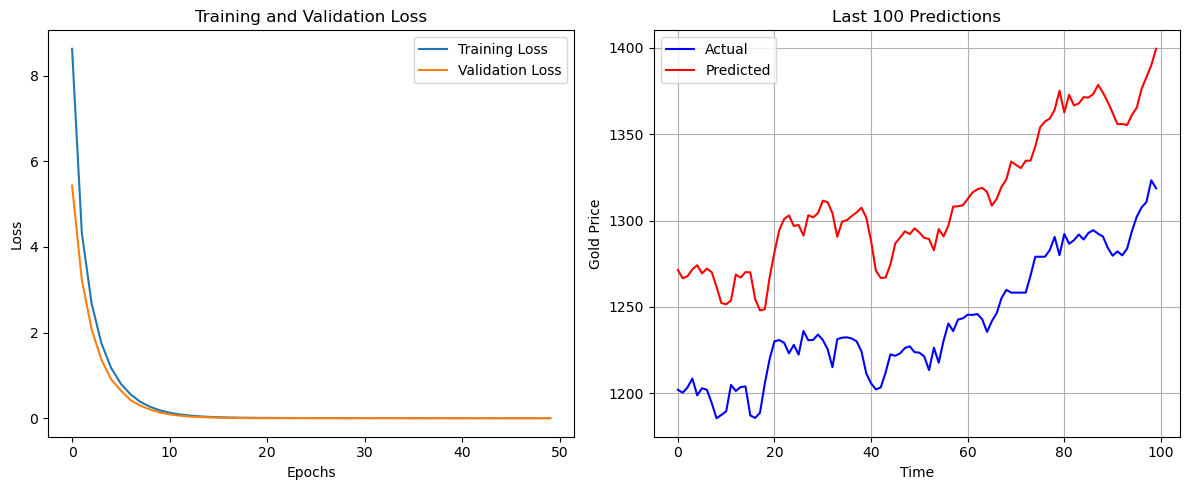


Analyzing feature importance...
27/27 [==============================] - 1s 30ms/step


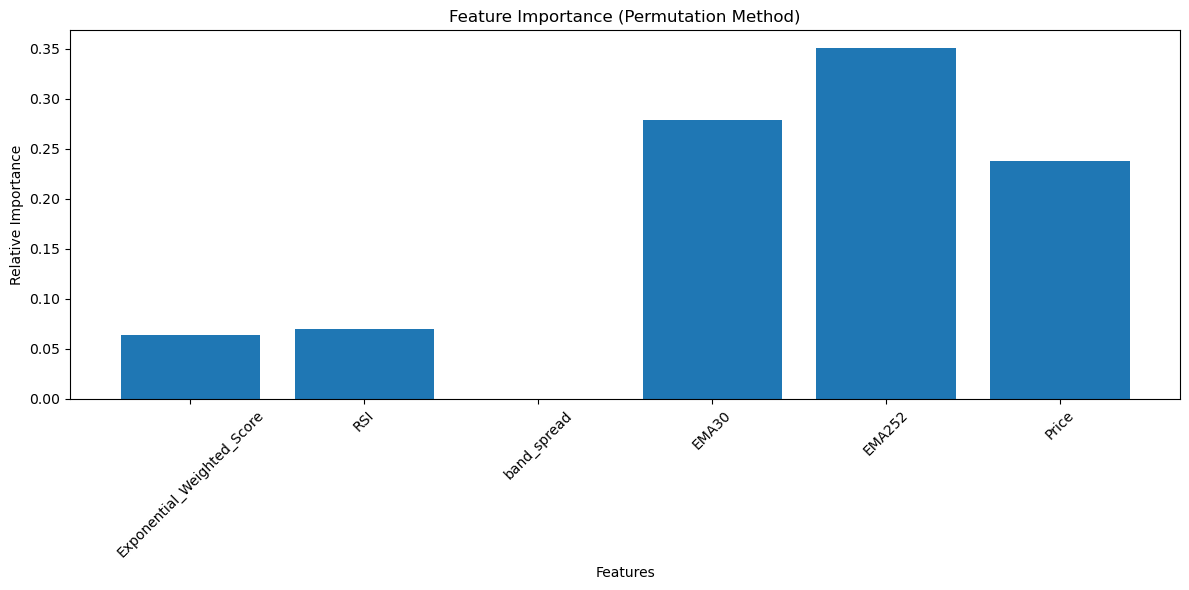


Visualizing attention over time...


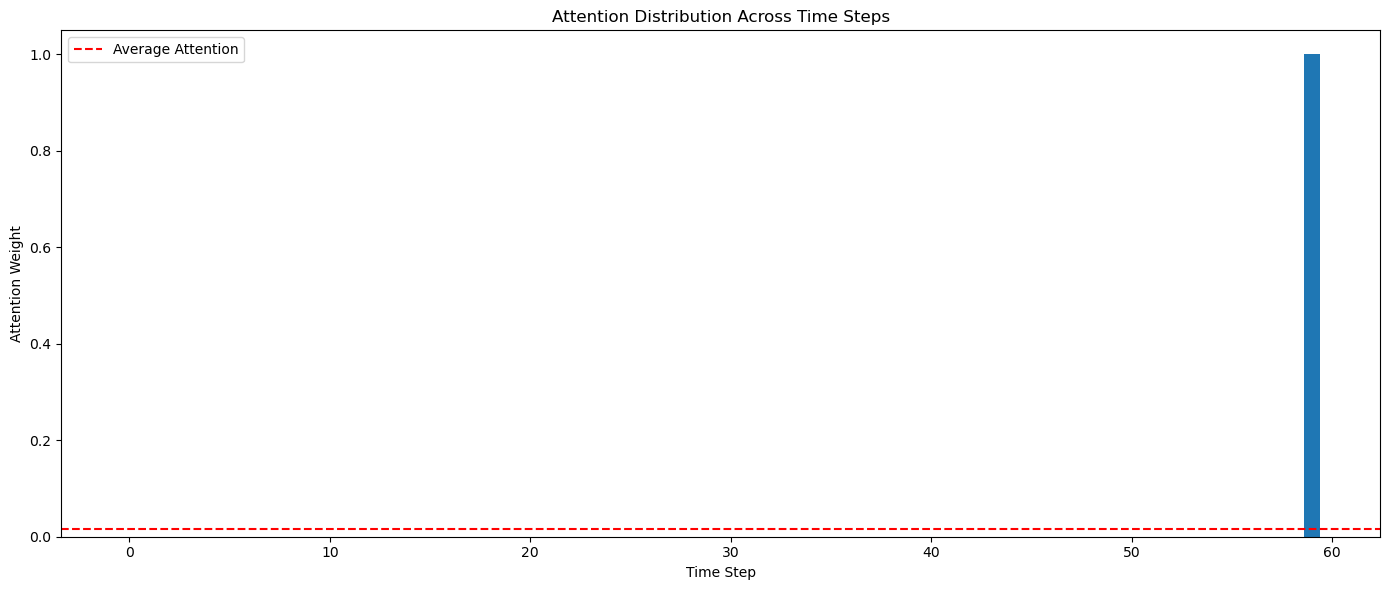

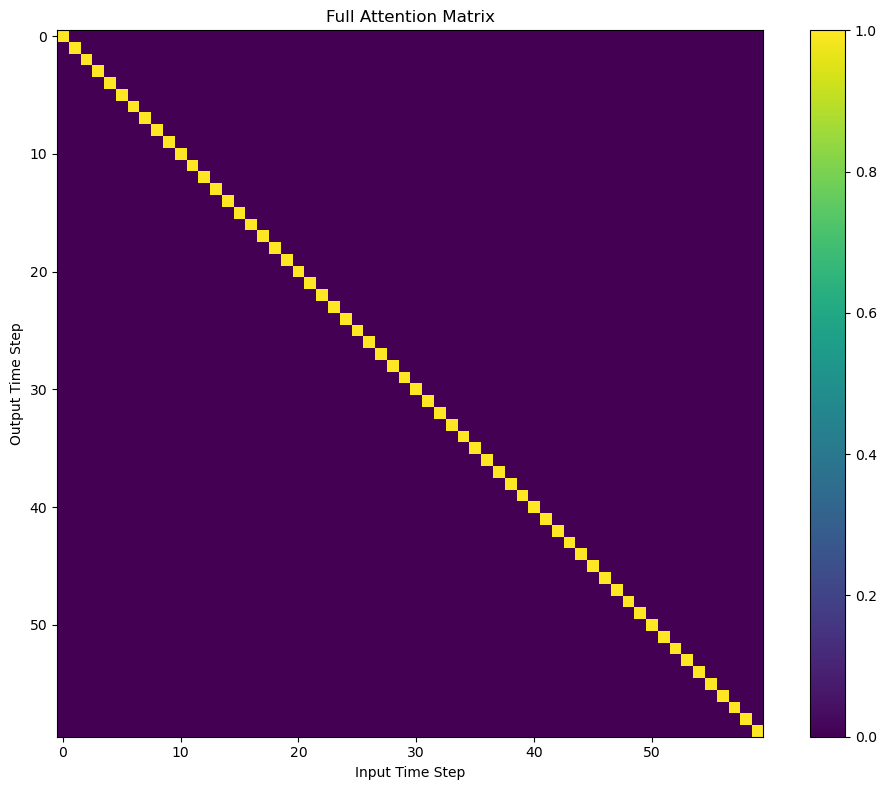


Running trading strategy backtest...


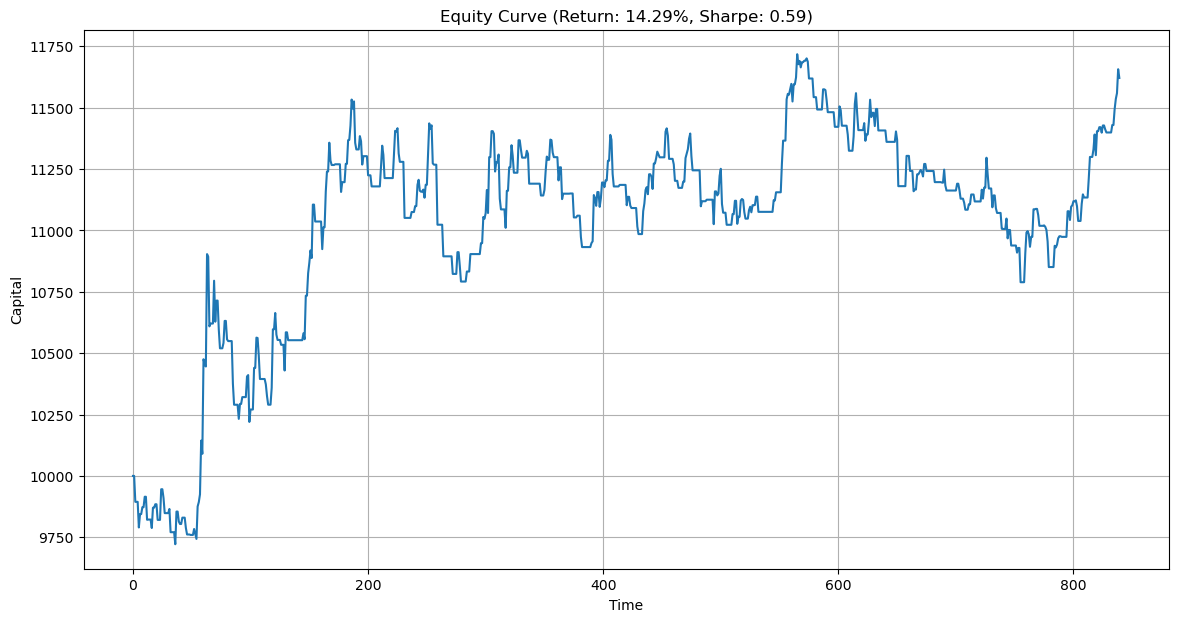

Final capital: $11429.48
Return: 14.29%
Sharpe Ratio: 0.59
Number of trades: 166


In [ ]:
import optuna
def tune_gold_price_model(df, features, seq_length=60, test_size=0.2, n_trials=20):
    """
    Hyperparameter tuning for gold price prediction model
    """
    # Prepare data once (outside the optimization loop)
    train_size = int(len(df) * (1 - test_size))
    train_data = df.iloc[:train_size]
    test_data = df.iloc[train_size - seq_length:]
    
    if "Price" not in features:
        features.append("Price")
    
    train_data, scaler_dict, features = prepare_data(train_data, features)
    
    test_data_scaled = test_data[features].copy()
    for column in test_data_scaled.columns:
        test_data_scaled[column] = scaler_dict[column].transform(
            test_data_scaled[column].values.reshape(-1, 1)
        )
    
    X_train, y_train = create_sequences(train_data, seq_length)
    X_test, y_test = create_sequences(test_data_scaled, seq_length)
    
    input_dim = X_train.shape[2]
    
    # Define optimization function with Optuna
    def objective(trial):
        # Define hyperparameters to tune
        params = {
            'd_model': trial.suggest_categorical('d_model', [64, 128, 256]),
            'num_heads': trial.suggest_int('num_heads', 2, 8, step=2),
            'num_layers': trial.suggest_int('num_layers', 2, 4),
            'dropout_rate': trial.suggest_float('dropout_rate', 0.1, 0.4, step=0.1),
            'attention_decay_factor': trial.suggest_float('attention_decay_factor', 
                                                         0.001, 0.005, log=True),
            'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64]),
            'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
        }
        
        # Build model with trial params
        model = GoldPriceTransformer(
            input_dim=input_dim,
            output_dim=1,
            d_model=params['d_model'],
            num_heads=params['num_heads'],
            num_layers=params['num_layers'],
            dropout_rate=params['dropout_rate'],
            attention_decay_factor=params['attention_decay_factor']
        )
        
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=params['learning_rate']),
            loss="mean_squared_error"
        )
        
        # Early stopping
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=5, restore_best_weights=True
        )
        
        # Train model
        history = model.fit(
            X_train, y_train,
            validation_split=0.2,
            batch_size=params['batch_size'],
            epochs=30,  
            callbacks=[early_stopping],
            verbose=0
        )
        
        # Return best validation loss
        return min(history.history['val_loss'])
    
    def print_trial_info(study, trial):
        print(f"\nTrial {trial.number} finished:")
        print(f"  Value: {trial.value:.4f}")
        print(f"  Params: {trial.params}")
        if study.best_trial.number == trial.number:
            print(f"  This is the best trial so far!")
        print(f"  Best value: {study.best_value:.4f}")
        print(f"  Best params: {study.best_params}\n")
    
    # Run optimization
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials, callbacks=[print_trial_info])
    
    # Get best parameters and train final model
    best_params = study.best_params
    print("Best parameters:", best_params)
    
    # Run your full training function with best parameters
    final_results = run_gold_price_backtesting(
        df=df,
        features=features,
        seq_length=seq_length,
        test_size=test_size,
        d_model=best_params['d_model'],
        num_heads=best_params['num_heads'],
        num_layers=best_params['num_layers'],
        dropout_rate=best_params['dropout_rate'],
        batch_size=best_params['batch_size'],
        epochs=50,  # Full training run
        attention_decay_factor=best_params['attention_decay_factor']
    )
    
    return {
        'best_params': best_params,
        'final_results': final_results
    }

best_params, fine_tuned_results = tune_gold_price_model(load_data(), ['Exponential_Weighted_Score', 'RSI', 'band_spread', 'EMA30', 'EMA252'], seq_length=60, test_size=0.2, n_trials=30)

## Run on Final Model

Training data shape: (3297, 60, 7)
Testing data shape: (840, 60, 7)
Epoch 1/30
83/83 [==============================] - 16s 87ms/step - loss: 5.2660 - val_loss: 3.8853
Epoch 2/30
83/83 [==============================] - 6s 73ms/step - loss: 3.2282 - val_loss: 2.6347
Epoch 3/30
83/83 [==============================] - 6s 72ms/step - loss: 2.2716 - val_loss: 1.9220
Epoch 4/30
83/83 [==============================] - 6s 72ms/step - loss: 1.6895 - val_loss: 1.4579
Epoch 5/30
83/83 [==============================] - 6s 68ms/step - loss: 1.2924 - val_loss: 1.1262
Epoch 6/30
83/83 [==============================] - 6s 70ms/step - loss: 1.0082 - val_loss: 0.8898
Epoch 7/30
83/83 [==============================] - 6s 74ms/step - loss: 0.7962 - val_loss: 0.7029
Epoch 8/30
83/83 [==============================] - 7s 85ms/step - loss: 0.6331 - val_loss: 0.5582
Epoch 9/30
83/83 [==============================] - 7s 83ms/step - loss: 0.5082 - val_loss: 0.4483
Epoch 10/30
83/83 [=====================

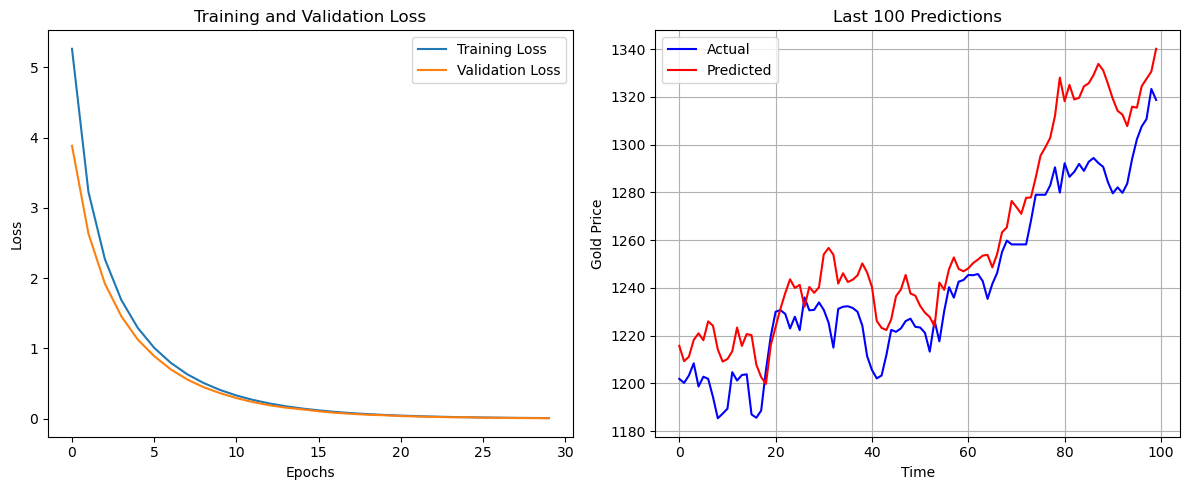


Analyzing feature importance...
27/27 [==============================] - 1s 28ms/step


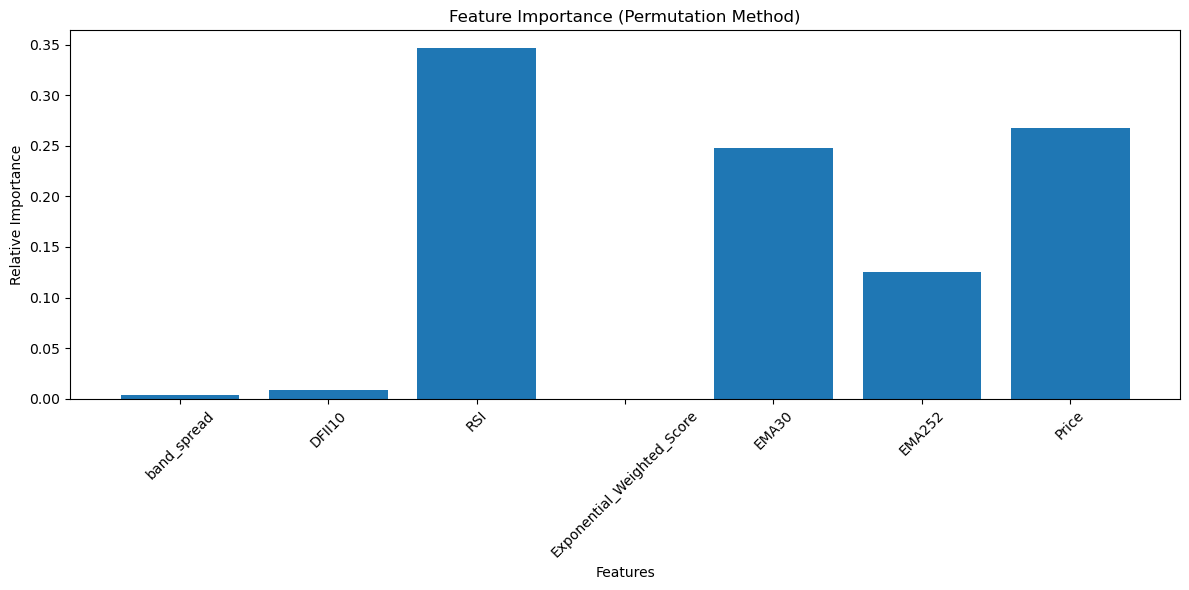


Visualizing attention over time...


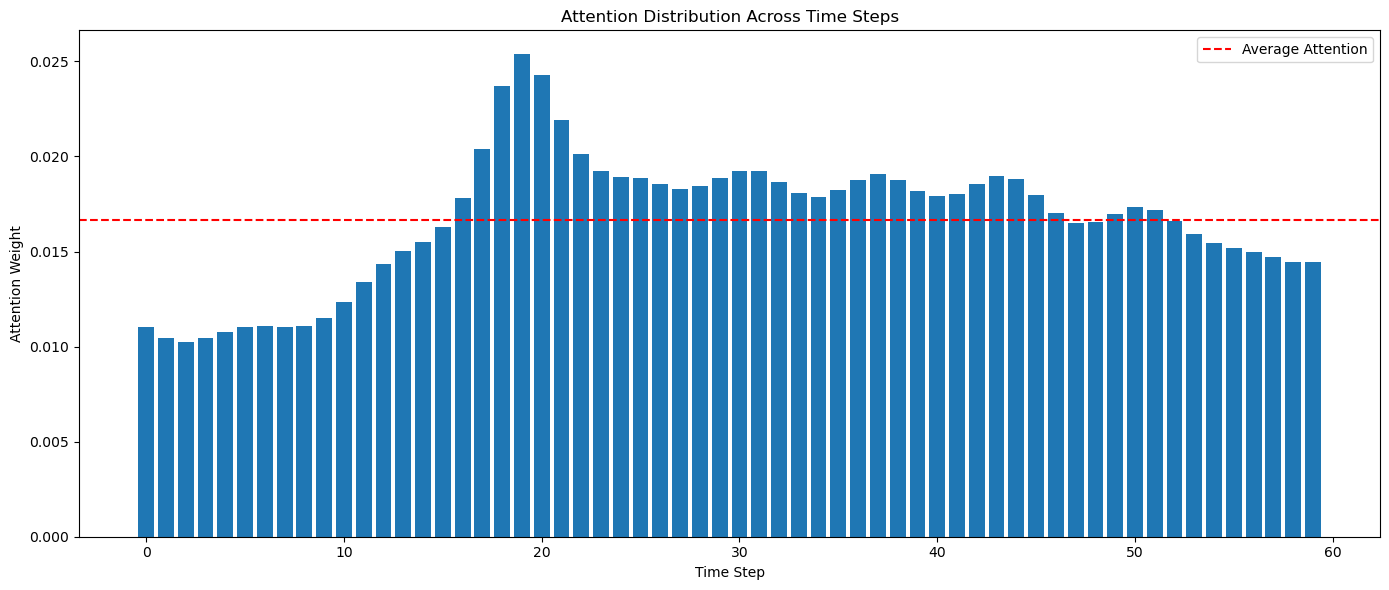

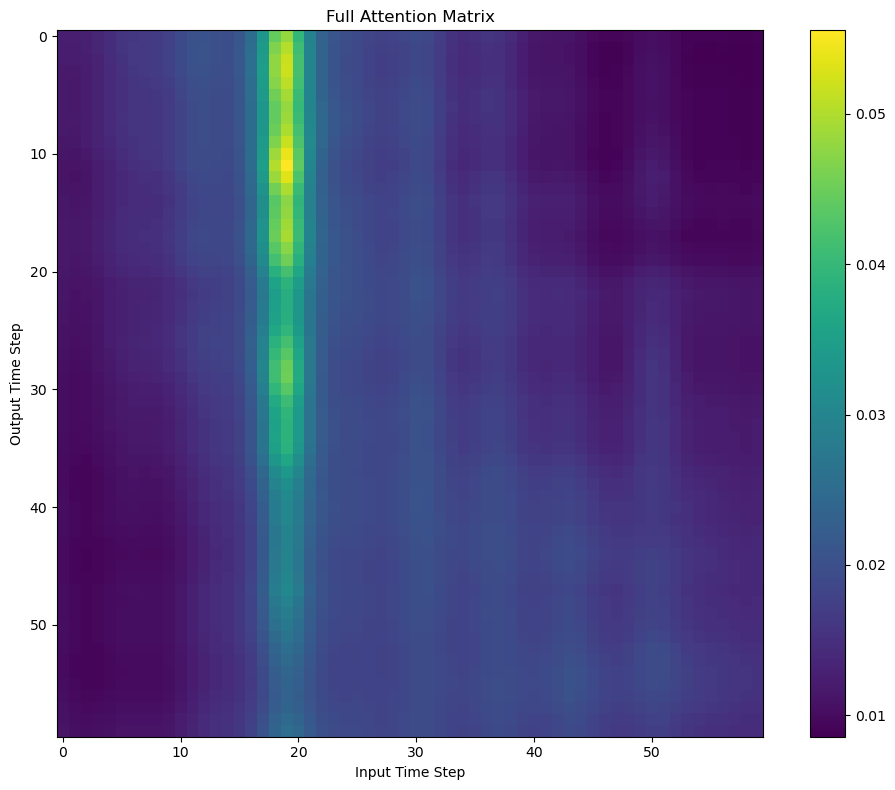


Running trading strategy backtest...


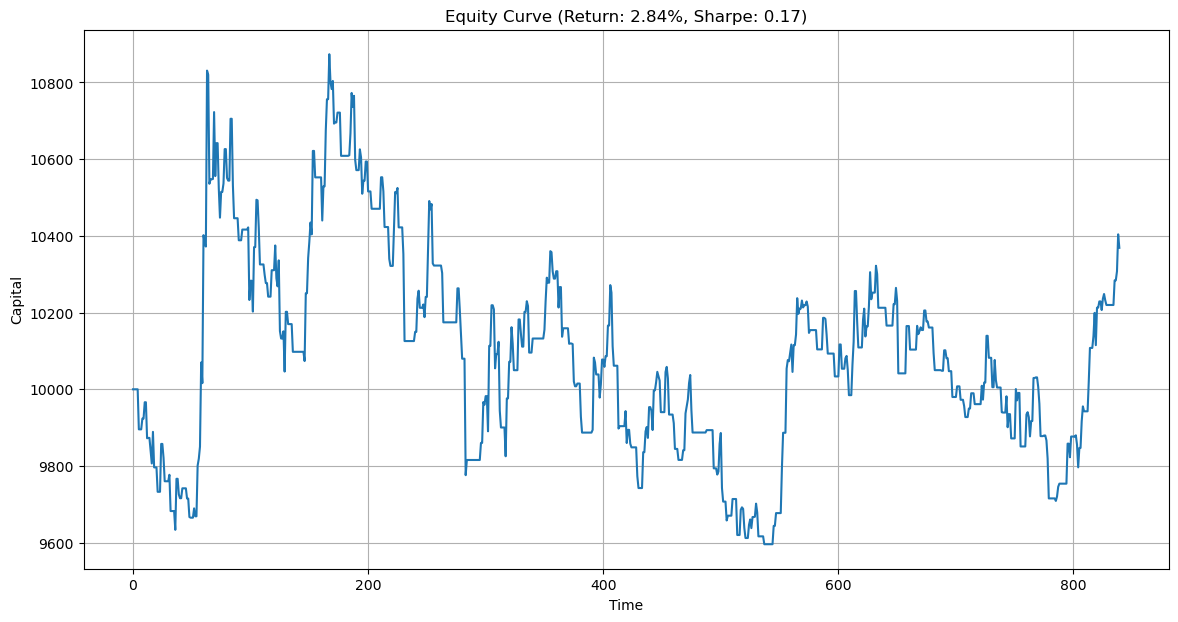

Final capital: $10283.97
Return: 2.84%
Sharpe Ratio: 0.17
Number of trades: 175


{'model': <__main__.GoldPriceTransformer at 0x23f76745420>,
 'features': ['band_spread',
  'DFII10',
  'RSI',
  'Exponential_Weighted_Score',
  'EMA30',
  'EMA252',
  'Price'],
 'history': <keras.callbacks.History at 0x23f3eac6bc0>,
 'y_test': array([1084.8, 1079.2, 1067.8, 1082.6, 1081.8, 1070.5, 1076.4, 1068. ,
        1071. , 1057.4, 1061.9, 1065.4, 1055.4, 1055.5, 1079.3, 1075.8,
        1072.1, 1081. , 1071. , 1072.5, 1068.3, 1061.5, 1075.3, 1049.4,
        1062.5, 1078.8, 1074.9, 1068.3, 1068.3, 1068.3, 1068.3, 1070.1,
        1060. , 1060. , 1060. , 1082.3, 1077. , 1091.4, 1106.4, 1101.9,
        1100.8, 1085.4, 1088.2, 1088.4, 1093.8, 1089.2, 1086.3, 1101.8,
        1096.5, 1096.3, 1106.6, 1113.6, 1116.3, 1114. , 1111.8, 1126.5,
        1128.5, 1132. , 1156.4, 1150.4, 1193.3, 1191. , 1190. , 1241. ,
        1239.8, 1208.2, 1209.5, 1210. , 1210.1, 1231.2, 1211. , 1221.4,
        1250.8, 1236. , 1226.5, 1234.9, 1236.5, 1239.2, 1250.3, 1277.5,
        1267.9, 1267. , 1246.4, 1266.

In [82]:
run_gold_price_backtesting(load_data(), 
                           ['band_spread', 'DFII10', 'RSI', 'Exponential_Weighted_Score', 'EMA30', 'EMA252'], 
                           seq_length=60, 
                           test_size=0.2, 
                           d_model=64, 
                           num_heads=6, 
                           num_layers=3, 
                           dropout_rate=0.1, 
                           batch_size=32, 
                           epochs=30,
                           attention_decay_factor=0.0005)

Training data shape: (3297, 60, 6)
Testing data shape: (780, 60, 6)
Epoch 1/100
42/42 [==============================] - 16s 134ms/step - loss: 39.7670 - val_loss: 29.3084
Epoch 2/100
42/42 [==============================] - 3s 80ms/step - loss: 26.5675 - val_loss: 23.3429
Epoch 3/100
42/42 [==============================] - 4s 86ms/step - loss: 21.6226 - val_loss: 20.1815
Epoch 4/100
42/42 [==============================] - 4s 100ms/step - loss: 18.2990 - val_loss: 16.8771
Epoch 5/100
42/42 [==============================] - 3s 75ms/step - loss: 15.6142 - val_loss: 14.4334
Epoch 6/100
42/42 [==============================] - 3s 75ms/step - loss: 13.4395 - val_loss: 12.5686
Epoch 7/100
42/42 [==============================] - 3s 81ms/step - loss: 11.6338 - val_loss: 10.8636
Epoch 8/100
42/42 [==============================] - 3s 74ms/step - loss: 10.1241 - val_loss: 9.4521
Epoch 9/100
42/42 [==============================] - 3s 78ms/step - loss: 8.8510 - val_loss: 8.2759
Epoch 10/100
4

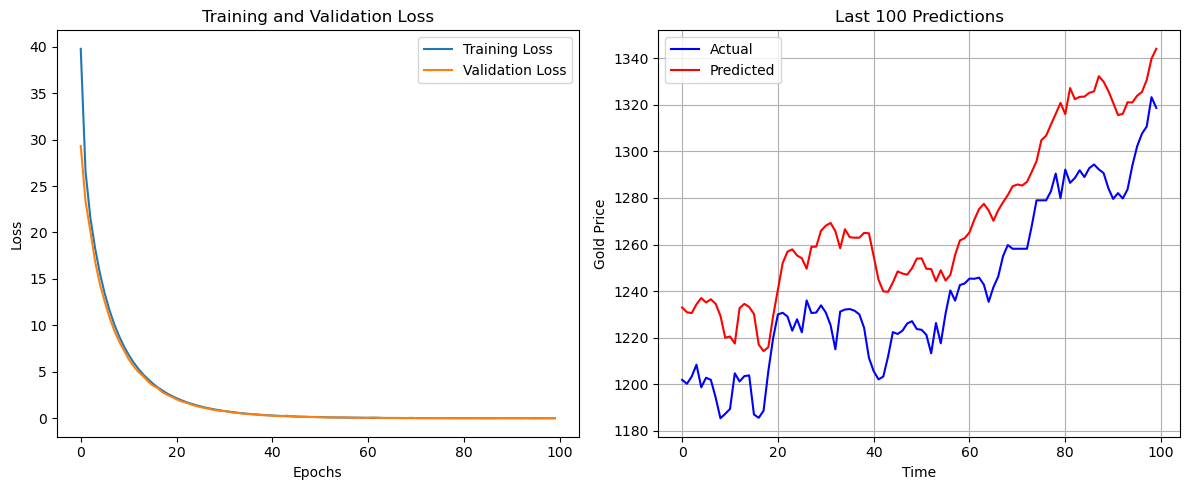


Analyzing feature importance...
25/25 [==============================] - 1s 32ms/step


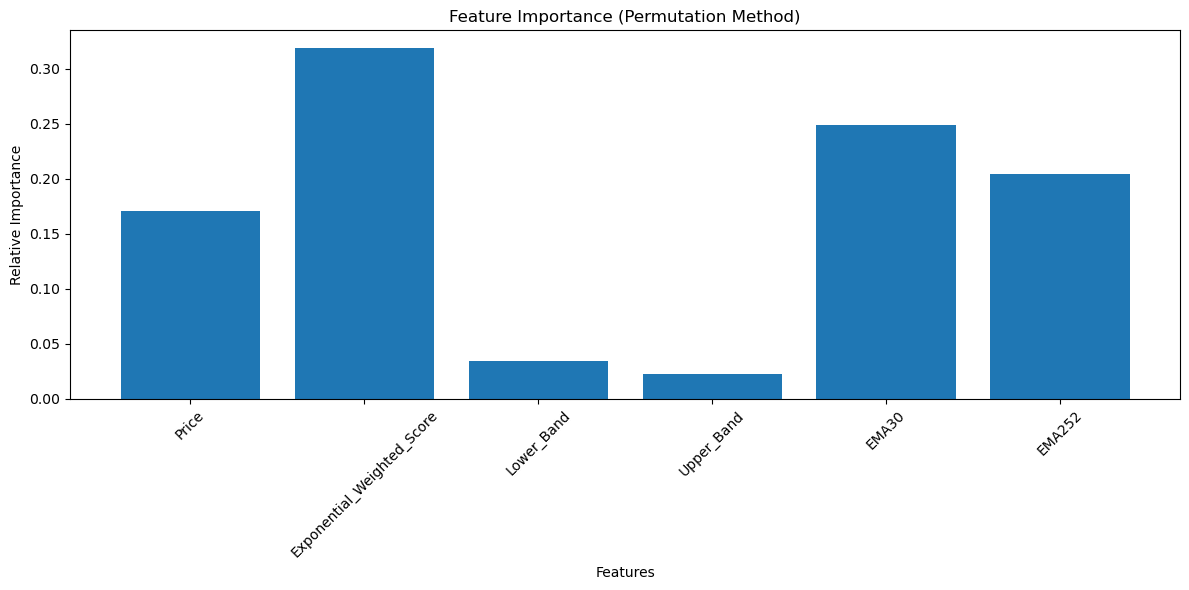


Visualizing attention over time...


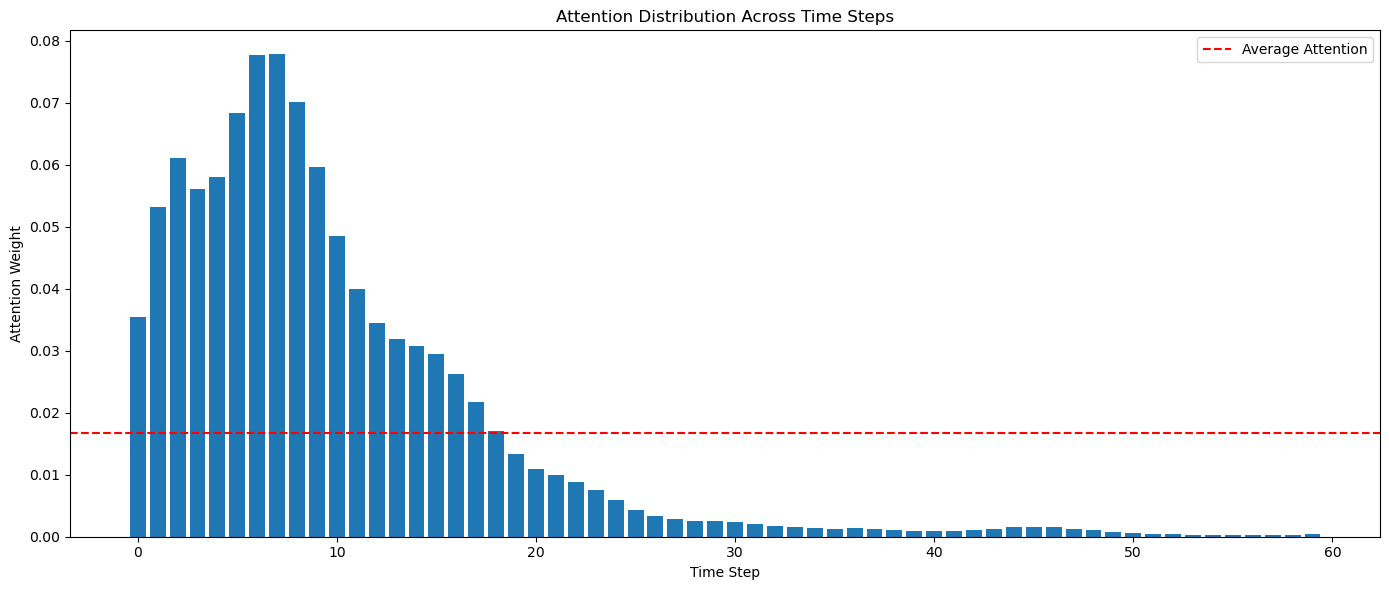

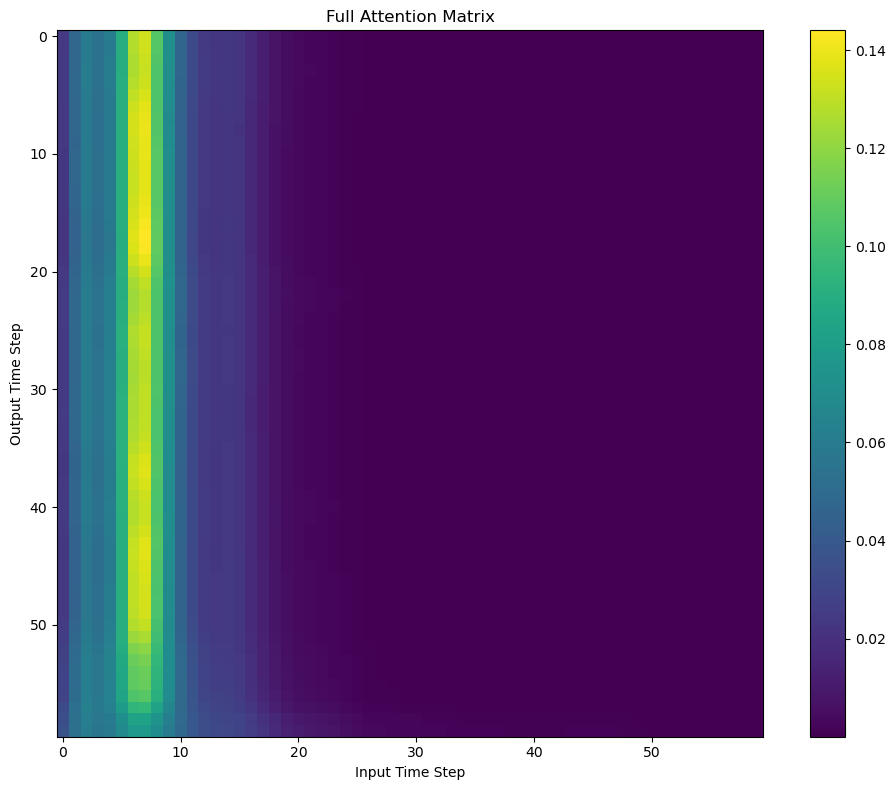


Running trading strategy backtest...


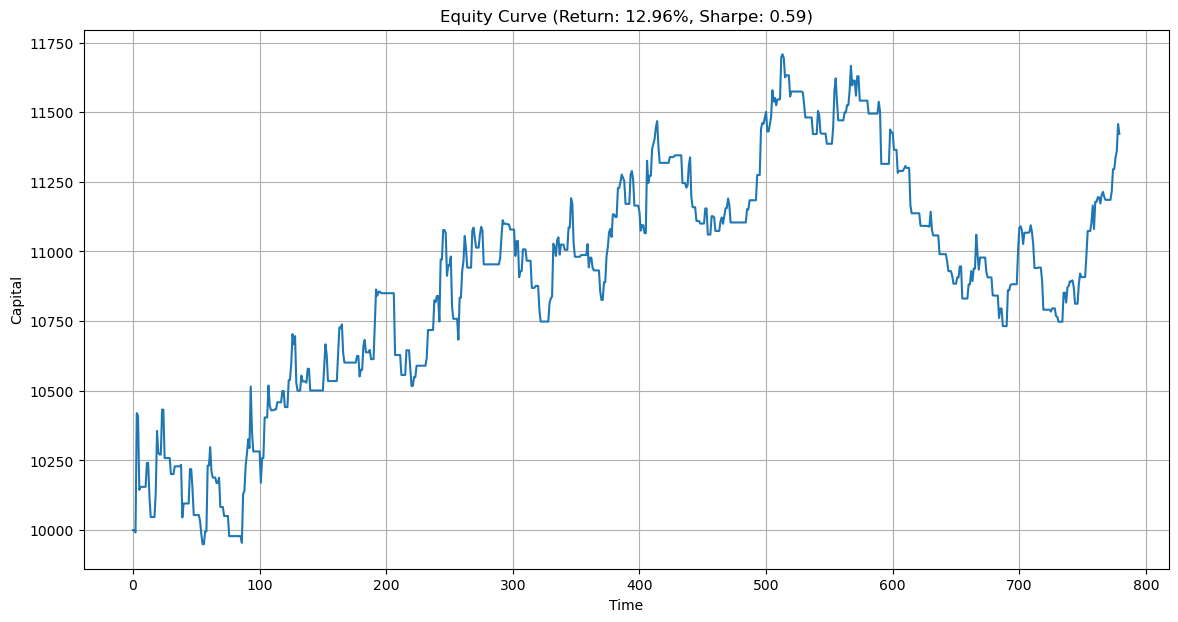

Final capital: $11295.56
Return: 12.96%
Sharpe Ratio: 0.59
Number of trades: 146


In [ ]:
run_gold_price_backtesting(load_data(), 
                           ['Exponential_Weighted_Score', 'Lower_Band', 'Upper_Band', 'EMA30', 'EMA252'], 
                           seq_length=60, 
                           test_size=0.2, 
                           d_model=64, 
                           num_heads=4, 
                           num_layers=2, 
                           dropout_rate=0.1, 
                           batch_size=32, 
                           epochs=50,
                           attention_decay_factor=0.01)

df = load_data()
test_size = 0.2
features = ['Exponential_Weighted_Score', 'Lower_Band', 'Upper_Band', 'EMA30', 'EMA252']
seq_length=60          # Length of sequence/window for predictions
test_size=0.2          # Proportion of data to use for testing
d_model=256            # Dimension of transformer model
num_heads=8            # Number of attention heads
num_layers=4           # Number of transformer layers
dropout_rate=0.2       # Dropout rate for regularization
batch_size = 64        # Batch size for training
epochs=100              # Maximum number of training epochs
attention_decay_factor= 0.0005

df.dropna(inplace=True)

# 1. Split raw data first
train_size = int(len(df) * (1 - test_size))
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

# 2. Prepare training data
train_data, scaler_dict, features = prepare_data(train_data, features)

# 3. Apply the same scalers to test data
test_data_scaled = test_data[features].copy()
for column in test_data_scaled.columns:
    test_data_scaled[column] = scaler_dict[column].transform(
        test_data_scaled[column].values.reshape(-1, 1)
    )

# 4. Create sequences for both sets
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data_scaled, seq_length)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# 4. Initialize the model
input_dim = X_train.shape[2]
output_dim = 1

model = GoldPriceTransformer(
    input_dim=input_dim,
    output_dim=output_dim,
    d_model=d_model,
    num_heads=num_heads,
    num_layers=num_layers,
    dropout_rate=dropout_rate,
    attention_decay_factor=attention_decay_factor
)

# 5. Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="mean_squared_error", # directional_mse_loss(alpha=1-directional_loss_weight)
)

# 6. Define callbacks
callbacks = []

# Add early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
callbacks.append(early_stopping)

# 7. Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

# 8. Evaluate on the test set
y_pred = model.predict(X_test)

# 9. Denormalize predictions and actual values
price_scaler = scaler_dict['Price']
y_test_denorm = price_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_denorm = price_scaler.inverse_transform(y_pred).flatten()

# 10. Calculate performance metrics
mse = mean_squared_error(y_test_denorm, y_pred_denorm)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_test_denorm, y_pred_denorm)
r2 = r2_score(y_test_denorm, y_pred_denorm)

print(f"Test MSE: {mse:.2f}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE: {mae:.2f}")
print(f"Test R²: {r2:.4f}")

# 11. Calculate directional accuracy
def directional_accuracy(y_true, y_pred):
    y_true_changes = np.diff(y_true)
    y_pred_changes = np.diff(y_pred)
    correct_direction = (y_true_changes * y_pred_changes) > 0
    return np.mean(correct_direction) * 100

da = directional_accuracy(y_test_denorm, y_pred_denorm)
print(f"Directional Accuracy: {da:.2f}%")

# 12. Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(y_test_denorm[-100:], label='Actual', color='blue')
plt.plot(y_pred_denorm[-100:], label='Predicted', color='red')
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('Gold Price')
plt.title('Last 100 Predictions')
plt.legend()
plt.tight_layout()
plt.show()

# 13. Feature importance analysis
print("\nAnalyzing feature importance...")
feature_importance = analyze_feature_importance(model, X_test, y_test, features)

# 14. Time attention visualization
print("\nVisualizing attention over time...")
time_attention = visualize_time_attention(model, X_test[0])

# 15. Trading strategy backtest
print("\nRunning trading strategy backtest...")
trades, equity_curve = backtest_trading_strategy(y_test_denorm, y_pred_denorm)

# Return everything for further analysis
results = {
    'model': model,
    'history': history,
    'y_test': y_test_denorm,
    'y_pred': y_pred_denorm,
    'metrics': {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'directional_accuracy': da
    },
    'feature_importance': feature_importance,
    'time_attention': time_attention,
    'trading_results': {
        'trades': trades,
        'equity_curve': equity_curve
    }
}

# Past Analysis

## MSE With L1 & L2 Regularisation

Training data shape: (5169, 60, 6)
Testing data shape: (1293, 60, 6)
Epoch 1/100
65/65 [==============================] - 12s 64ms/step - loss: 507.6420 - val_loss: 272.7675
Epoch 2/100
65/65 [==============================] - 3s 51ms/step - loss: 171.5567 - val_loss: 100.5349
Epoch 3/100
65/65 [==============================] - 3s 50ms/step - loss: 67.7083 - val_loss: 43.0490
Epoch 4/100
65/65 [==============================] - 3s 50ms/step - loss: 30.3591 - val_loss: 20.4576
Epoch 5/100
65/65 [==============================] - 3s 50ms/step - loss: 15.0101 - val_loss: 10.6174
Epoch 6/100
65/65 [==============================] - 3s 48ms/step - loss: 8.1765 - val_loss: 6.1331
Epoch 7/100
65/65 [==============================] - 3s 49ms/step - loss: 4.9678 - val_loss: 3.9802
Epoch 8/100
65/65 [==============================] - 3s 50ms/step - loss: 3.4315 - val_loss: 2.9624
Epoch 9/100
65/65 [==============================] - 3s 50ms/step - loss: 2.6989 - val_loss: 2.4675
Epoch 10/100
65/

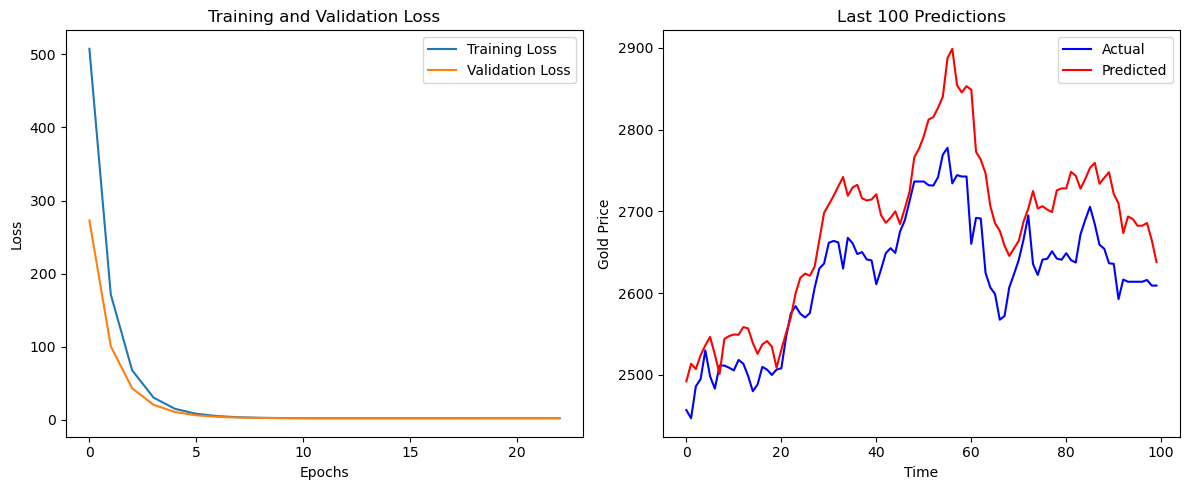


Analyzing feature importance...
41/41 [==============================] - 1s 17ms/step


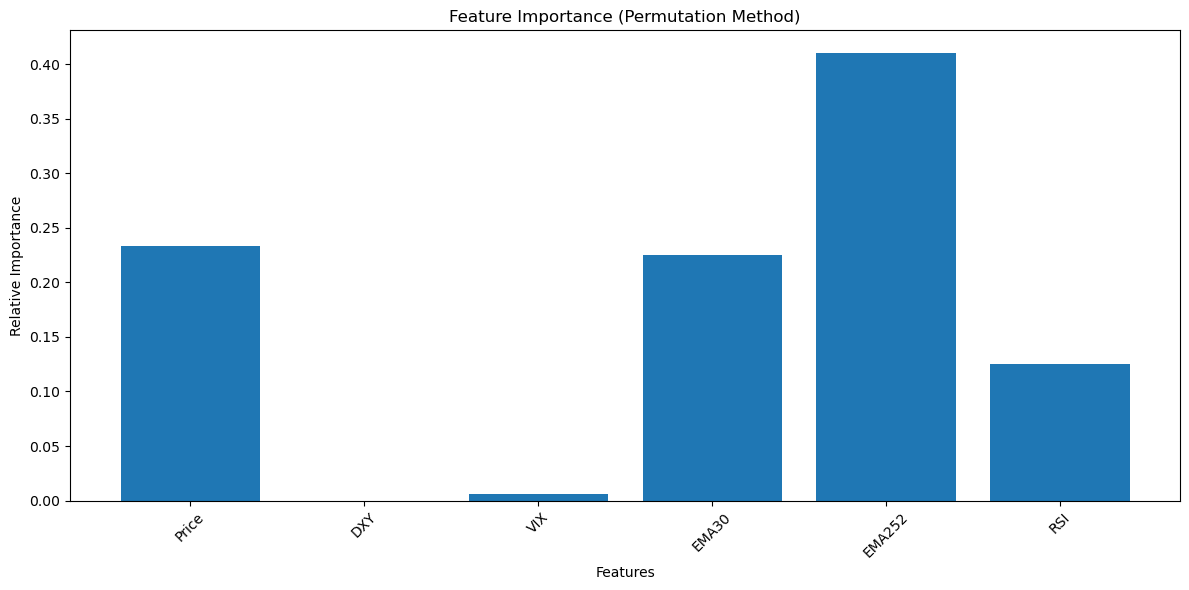


Visualizing attention over time...


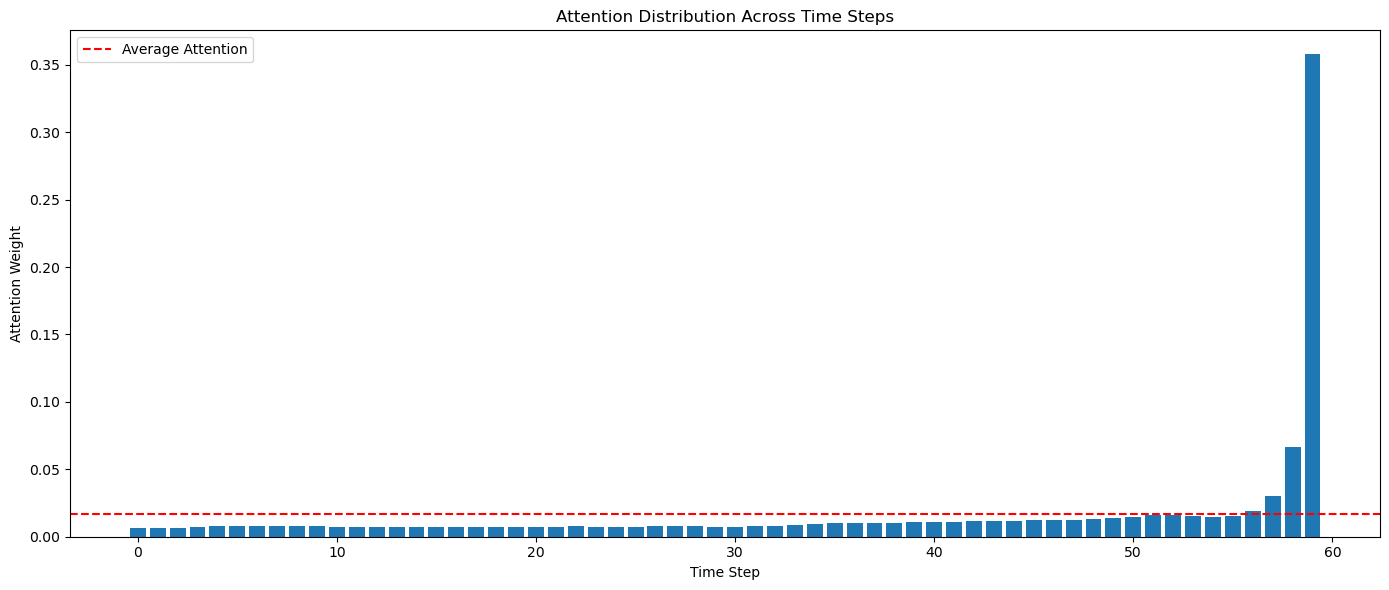

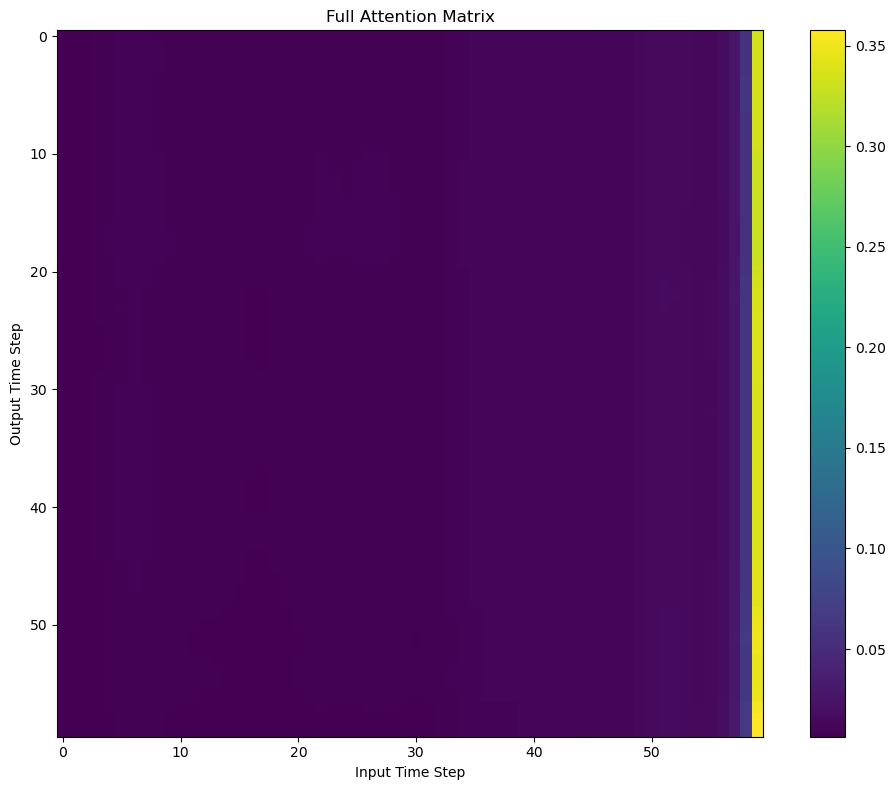


Running trading strategy backtest...


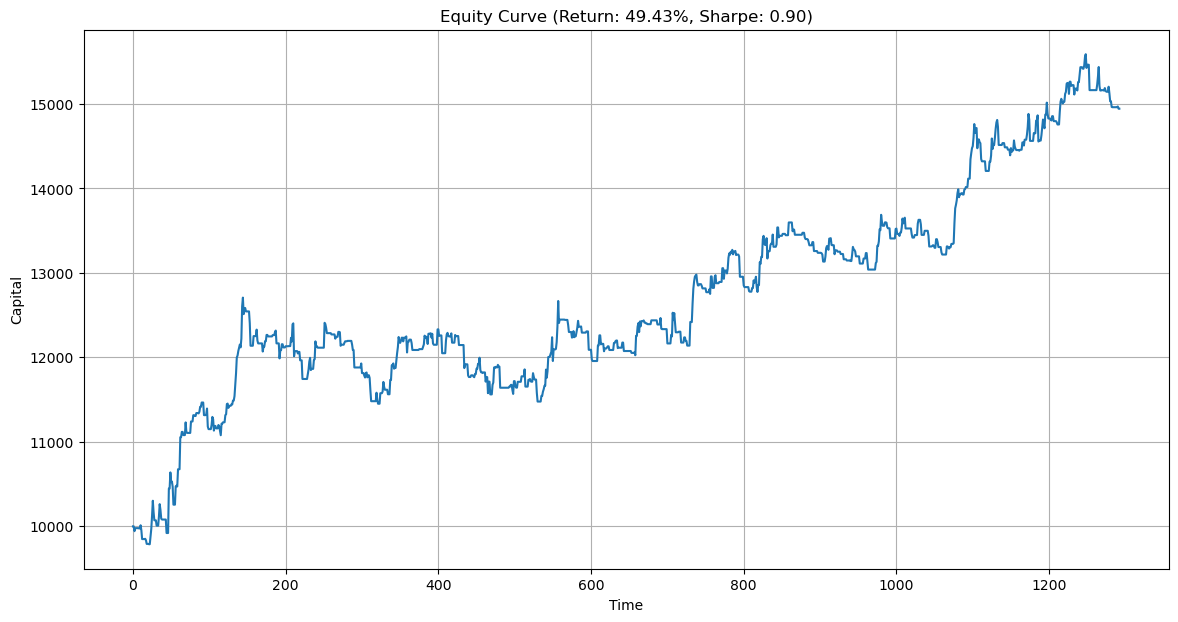

Final capital: $14943.33
Return: 49.43%
Sharpe Ratio: 0.90
Number of trades: 254
RMSE: 33.61
Directional Accuracy: 48.14%


In [6]:
df = load_data()

# Run the complete backtesting process
results = run_gold_price_backtesting(
    df,                     # Your dataframe with gold prices and features
    features = ["Price", "DXY", "VIX", "EMA30", "EMA252", "RSI"],
    seq_length=60,          # Length of sequence/window for predictions
    test_size=0.2,          # Proportion of data to use for testing
    d_model=256,            # Dimension of transformer model
    num_heads=8,            # Number of attention heads
    num_layers=4,           # Number of transformer layers
    dropout_rate=0.2,       # Dropout rate for regularization
    batch_size = 64,        # Batch size for training
    epochs=100,              # Maximum number of training epochs
    directional_loss_weight=0.7
)

# Access results
model = results['model']                   # The trained model
metrics = results['metrics']               # Performance metrics
feature_importance = results['feature_importance']  # Feature importance scores
trading_results = results['trading_results']        # Trading backtest results

# Print key metrics
print(f"RMSE: {metrics['rmse']:.2f}")
print(f"Directional Accuracy: {metrics['directional_accuracy']:.2f}%")

# Save model if needed
# model.save('gold_price_transformer.tf')

Training data shape: (3911, 60, 7)
Testing data shape: (978, 60, 7)
Epoch 1/100
49/49 [==============================] - 9s 68ms/step - loss: 560.9901 - val_loss: 363.2999
Epoch 2/100
49/49 [==============================] - 2s 49ms/step - loss: 247.8233 - val_loss: 163.9524
Epoch 3/100
49/49 [==============================] - 2s 48ms/step - loss: 120.5660 - val_loss: 85.5292
Epoch 4/100
49/49 [==============================] - 2s 48ms/step - loss: 65.0154 - val_loss: 47.6822
Epoch 5/100
49/49 [==============================] - 2s 49ms/step - loss: 36.9216 - val_loss: 27.6421
Epoch 6/100
49/49 [==============================] - 2s 49ms/step - loss: 21.7793 - val_loss: 16.6604
Epoch 7/100
49/49 [==============================] - 2s 48ms/step - loss: 13.3619 - val_loss: 10.4478
Epoch 8/100
49/49 [==============================] - 2s 49ms/step - loss: 8.5703 - val_loss: 6.9057
Epoch 9/100
49/49 [==============================] - 2s 49ms/step - loss: 5.8199 - val_loss: 4.8394
Epoch 10/100


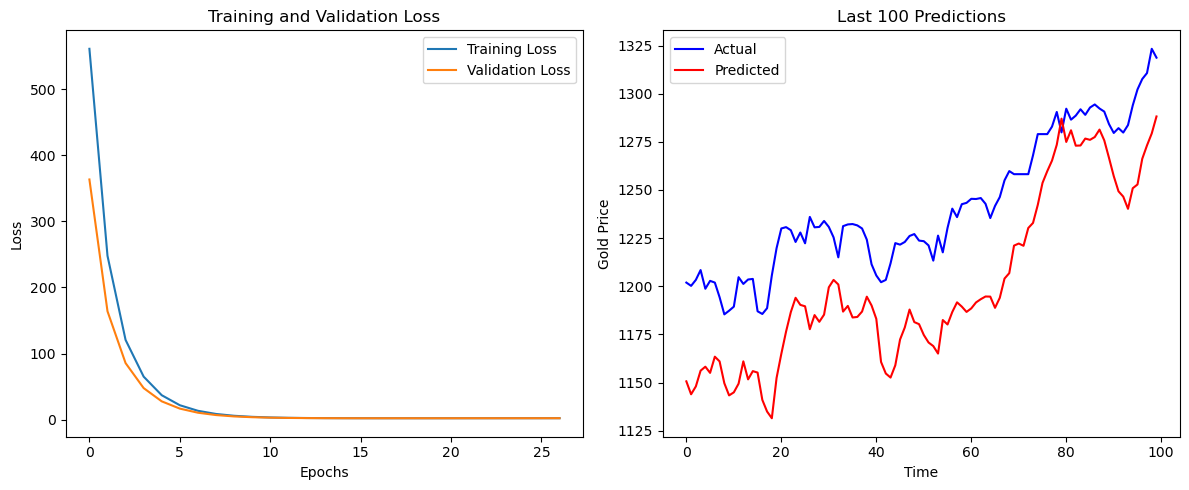


Analyzing feature importance...
31/31 [==============================] - 0s 15ms/step


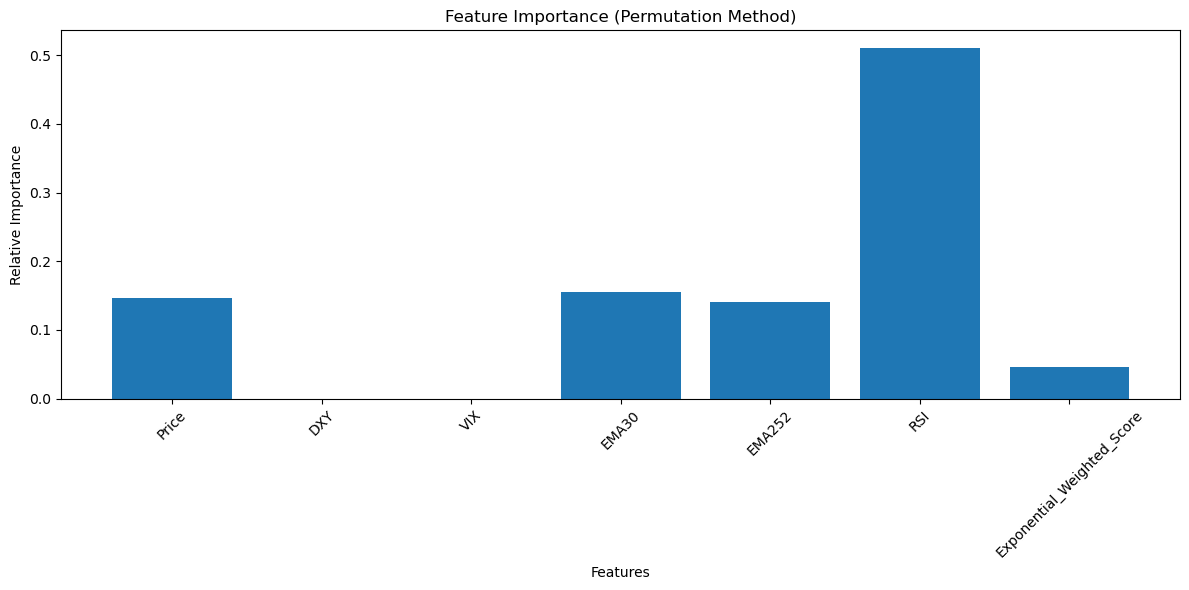


Visualizing attention over time...


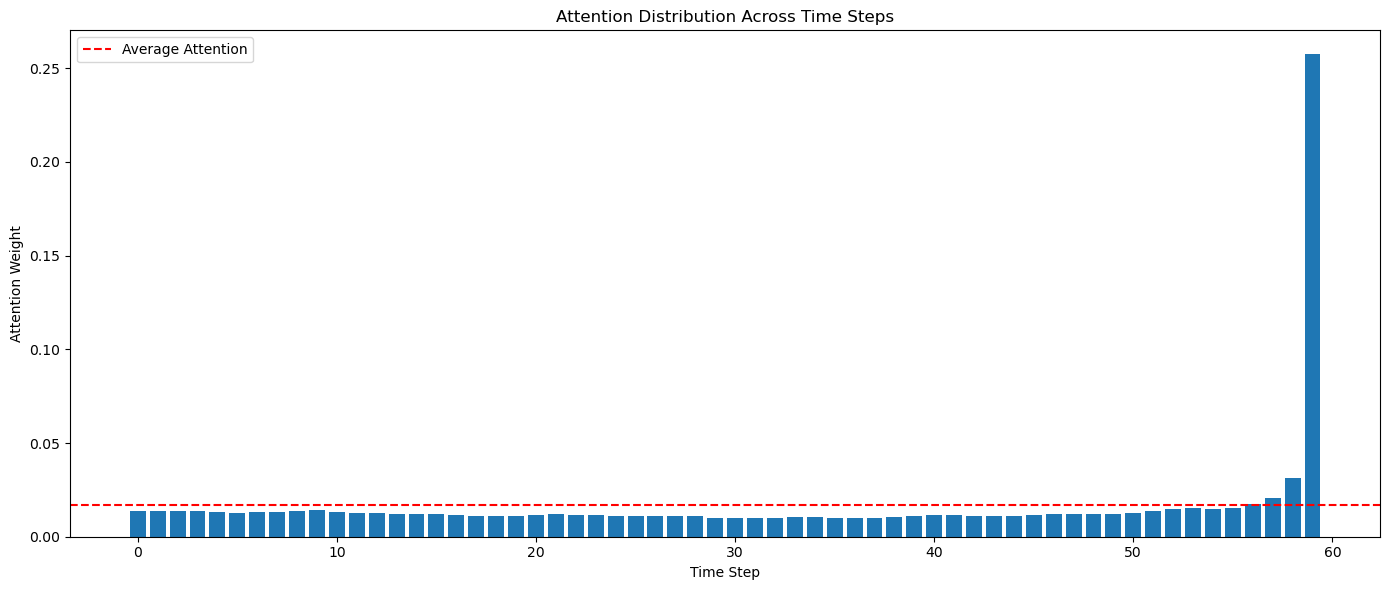

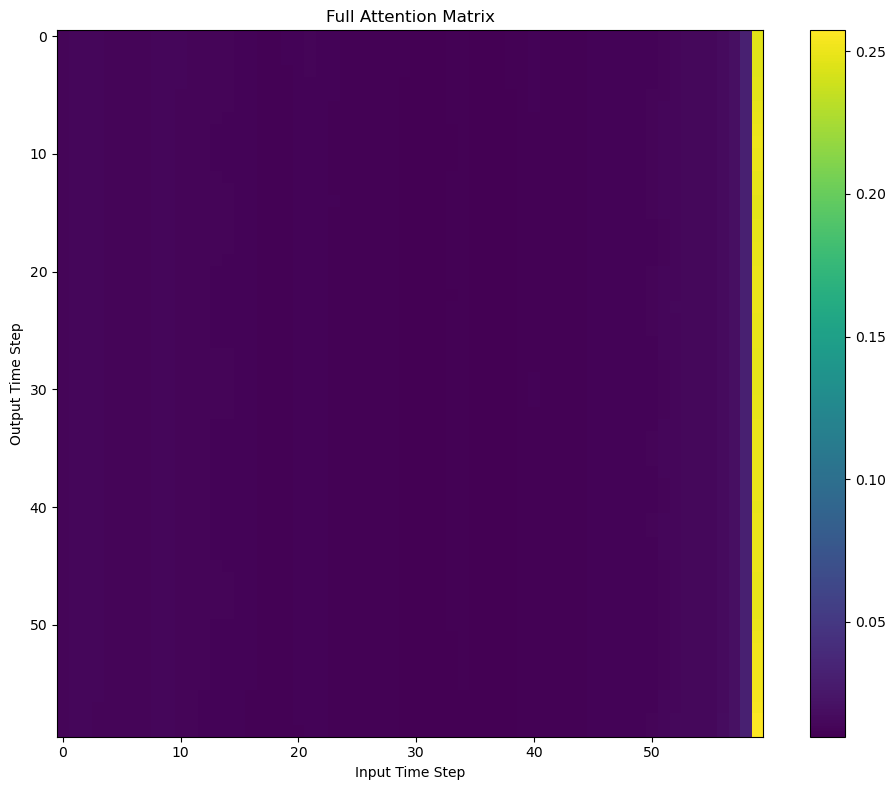


Running trading strategy backtest...


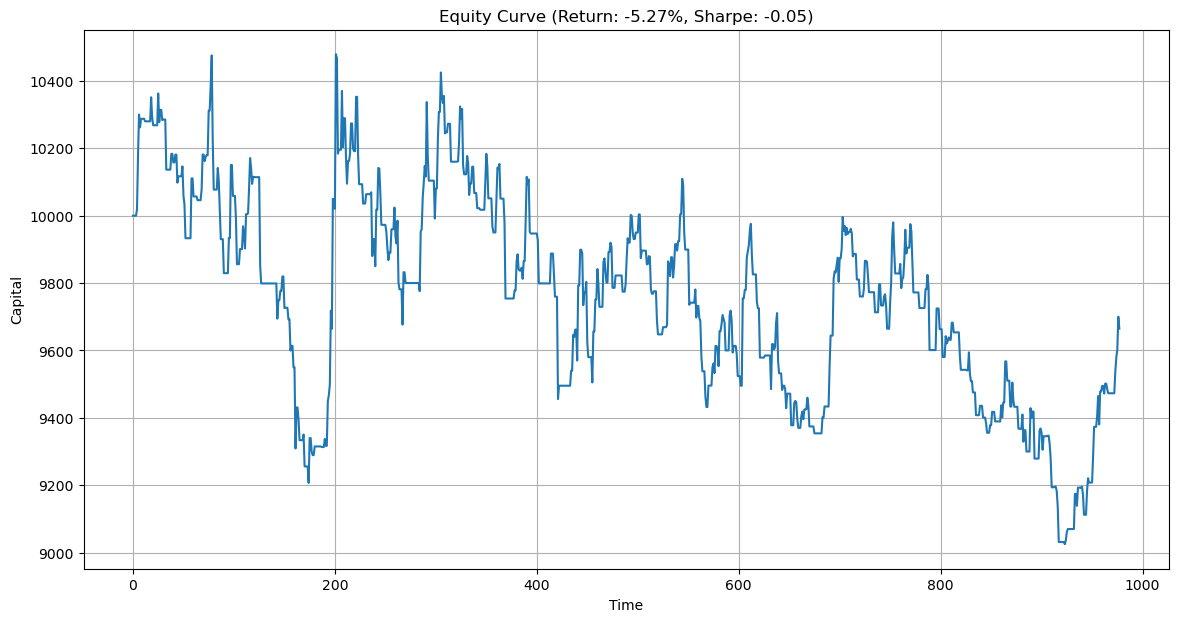

Final capital: $9473.10
Return: -5.27%
Sharpe Ratio: -0.05
Number of trades: 195
RMSE: 57.89
Directional Accuracy: 47.70%


In [7]:
df = load_data()

# Run the complete backtesting process
results = run_gold_price_backtesting(
    df,                     # Your dataframe with gold prices and features
    features = ["Price", "DXY", "VIX", "EMA30", "EMA252", "RSI", "Exponential_Weighted_Score"],
    seq_length=60,          # Length of sequence/window for predictions
    test_size=0.2,          # Proportion of data to use for testing
    d_model=256,            # Dimension of transformer model
    num_heads=8,            # Number of attention heads
    num_layers=4,           # Number of transformer layers
    dropout_rate=0.2,       # Dropout rate for regularization
    batch_size = 64,        # Batch size for training
    epochs=100,              # Maximum number of training epochs
    directional_loss_weight=0.7
)

# Access results
model = results['model']                   # The trained model
metrics = results['metrics']               # Performance metrics
feature_importance = results['feature_importance']  # Feature importance scores
trading_results = results['trading_results']        # Trading backtest results

# Print key metrics
print(f"RMSE: {metrics['rmse']:.2f}")
print(f"Directional Accuracy: {metrics['directional_accuracy']:.2f}%")

# Save model if needed
# model.save('gold_price_transformer.tf')

## MSE With L2 Regularisaation

Training data shape: (5169, 60, 6)
Testing data shape: (1293, 60, 6)
Epoch 1/100
65/65 [==============================] - 9s 65ms/step - loss: 33.9293 - val_loss: 24.2062
Epoch 2/100
65/65 [==============================] - 3s 44ms/step - loss: 20.7975 - val_loss: 17.5687
Epoch 3/100
65/65 [==============================] - 3s 43ms/step - loss: 15.5685 - val_loss: 12.9804
Epoch 4/100
65/65 [==============================] - 3s 43ms/step - loss: 11.5582 - val_loss: 10.1061
Epoch 5/100
65/65 [==============================] - 3s 43ms/step - loss: 9.0623 - val_loss: 8.0076
Epoch 6/100
65/65 [==============================] - 3s 44ms/step - loss: 7.2250 - val_loss: 6.4362
Epoch 7/100
65/65 [==============================] - 3s 44ms/step - loss: 5.8343 - val_loss: 5.2326
Epoch 8/100
65/65 [==============================] - 3s 43ms/step - loss: 4.7593 - val_loss: 4.2959
Epoch 9/100
65/65 [==============================] - 3s 43ms/step - loss: 3.9159 - val_loss: 3.5378
Epoch 10/100
65/65 [===

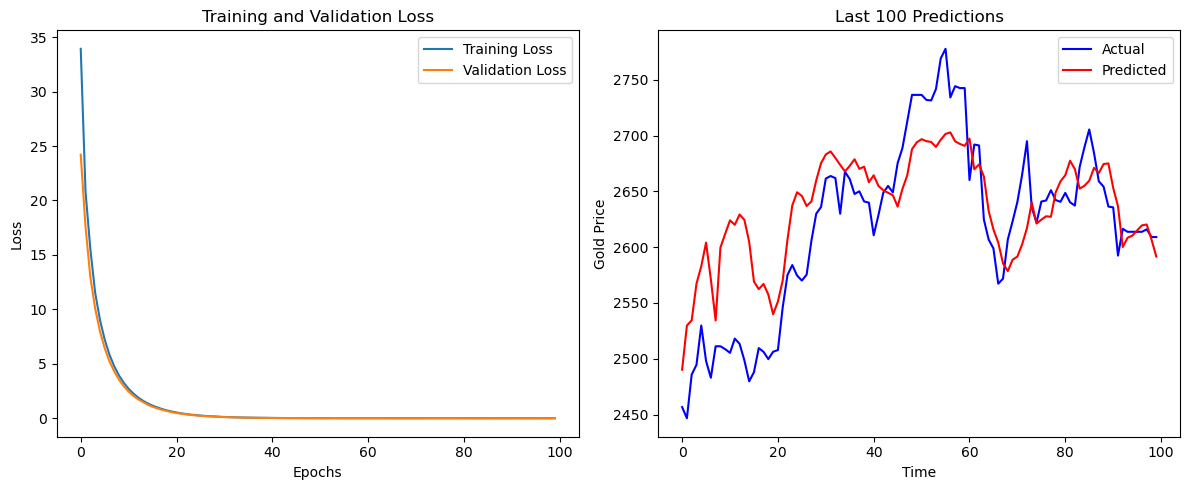


Analyzing feature importance...
41/41 [==============================] - 1s 17ms/step


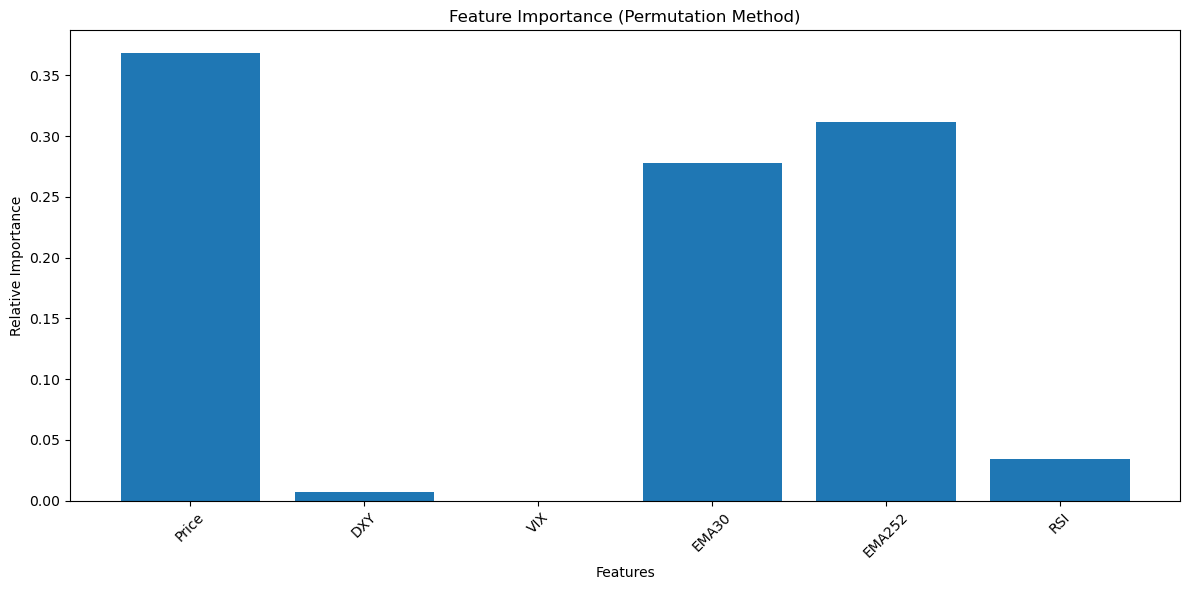


Visualizing attention over time...


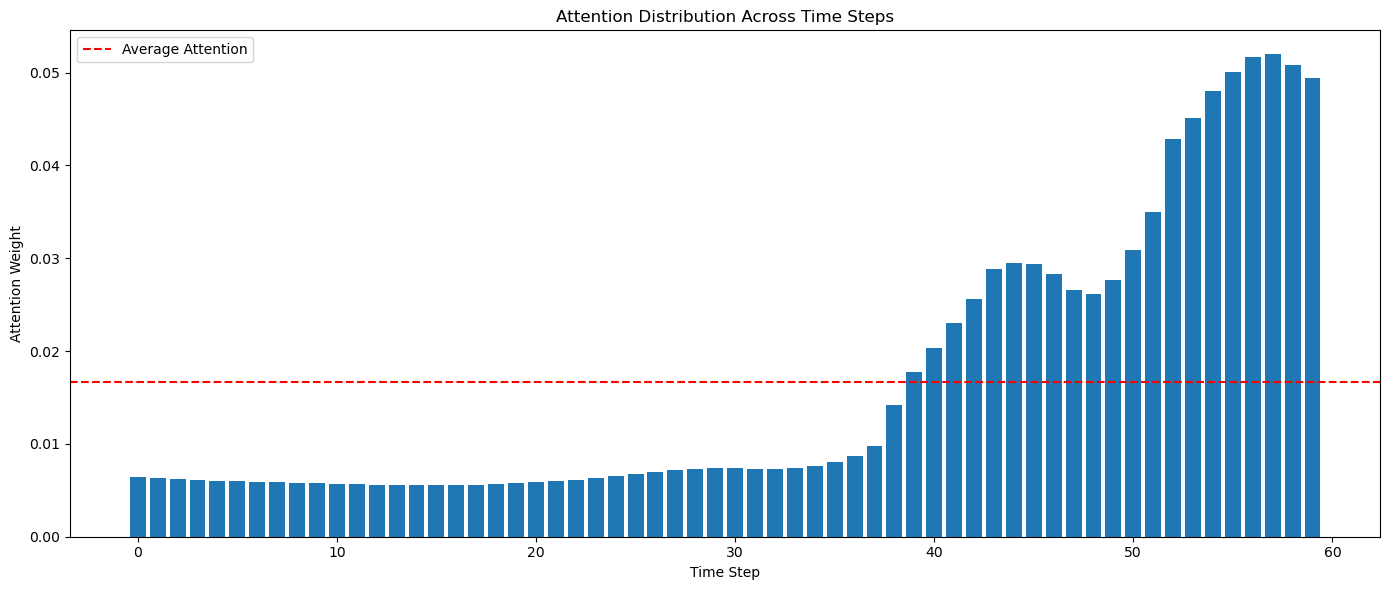

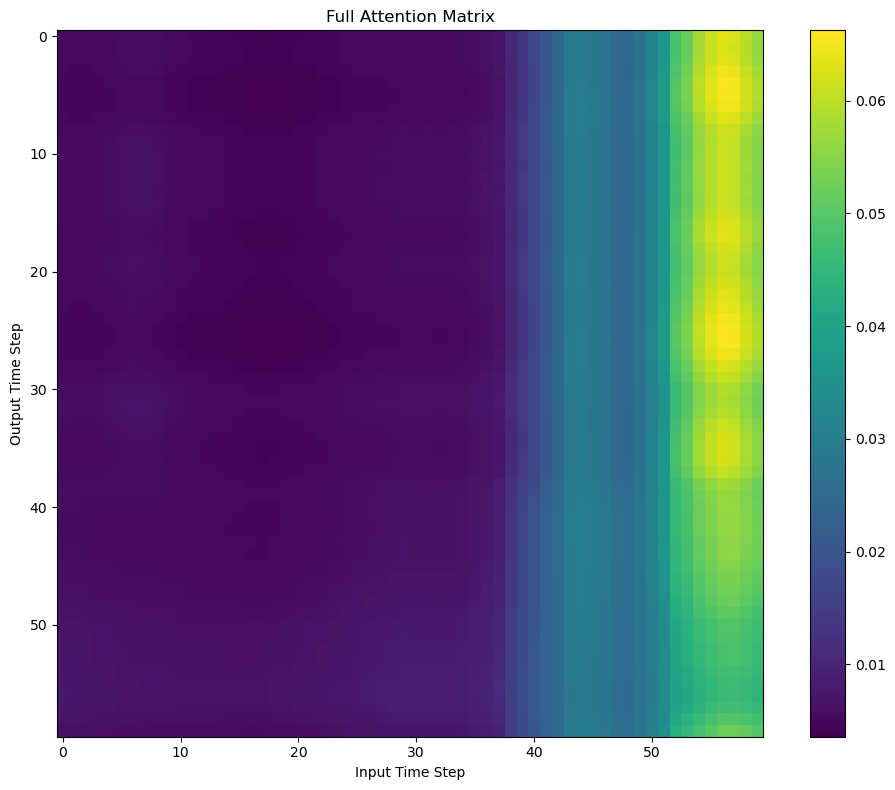


Running trading strategy backtest...


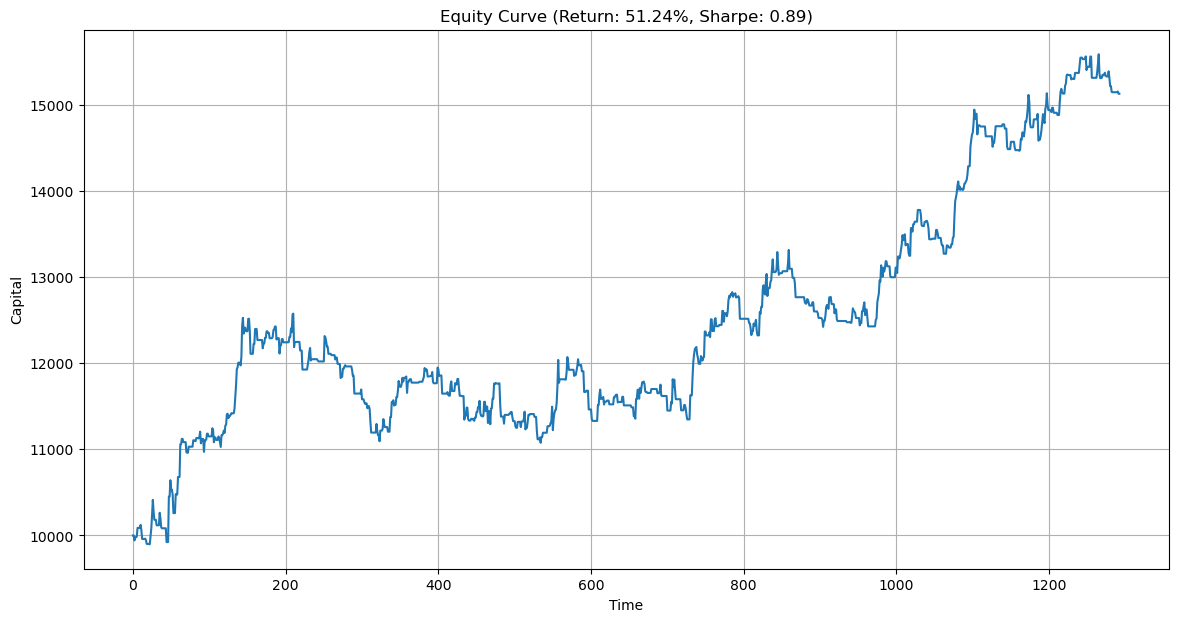

Final capital: $15124.39
Return: 51.24%
Sharpe Ratio: 0.89
Number of trades: 243
RMSE: 48.76
Directional Accuracy: 48.37%


In [9]:
df = load_data()

# Run the complete backtesting process
results = run_gold_price_backtesting(
    df,                     # Your dataframe with gold prices and features
    features = ["Price", "DXY", "VIX", "EMA30", "EMA252", "RSI"],
    seq_length=60,          # Length of sequence/window for predictions
    test_size=0.2,          # Proportion of data to use for testing
    d_model=256,            # Dimension of transformer model
    num_heads=8,            # Number of attention heads
    num_layers=4,           # Number of transformer layers
    dropout_rate=0.2,       # Dropout rate for regularization
    batch_size = 64,        # Batch size for training
    epochs=100,              # Maximum number of training epochs
    directional_loss_weight=0.7
)

# Access results
model = results['model']                   # The trained model
metrics = results['metrics']               # Performance metrics
feature_importance = results['feature_importance']  # Feature importance scores
trading_results = results['trading_results']        # Trading backtest results

# Print key metrics
print(f"RMSE: {metrics['rmse']:.2f}")
print(f"Directional Accuracy: {metrics['directional_accuracy']:.2f}%")

# Save model if needed
# model.save('gold_price_transformer.tf')

Training data shape: (3911, 60, 7)
Testing data shape: (978, 60, 7)
Epoch 1/100
49/49 [==============================] - 9s 76ms/step - loss: 38.0270 - val_loss: 30.5336
Epoch 2/100
49/49 [==============================] - 3s 51ms/step - loss: 25.2190 - val_loss: 23.9408
Epoch 3/100
49/49 [==============================] - 2s 48ms/step - loss: 20.0275 - val_loss: 17.7355
Epoch 4/100
49/49 [==============================] - 2s 47ms/step - loss: 16.1618 - val_loss: 14.6839
Epoch 5/100
49/49 [==============================] - 2s 47ms/step - loss: 13.4473 - val_loss: 12.2931
Epoch 6/100
49/49 [==============================] - 2s 47ms/step - loss: 11.3072 - val_loss: 10.3890
Epoch 7/100
49/49 [==============================] - 2s 47ms/step - loss: 9.5884 - val_loss: 8.8083
Epoch 8/100
49/49 [==============================] - 2s 48ms/step - loss: 8.2074 - val_loss: 7.5553
Epoch 9/100
49/49 [==============================] - 2s 47ms/step - loss: 7.0448 - val_loss: 6.5129
Epoch 10/100
49/49 [

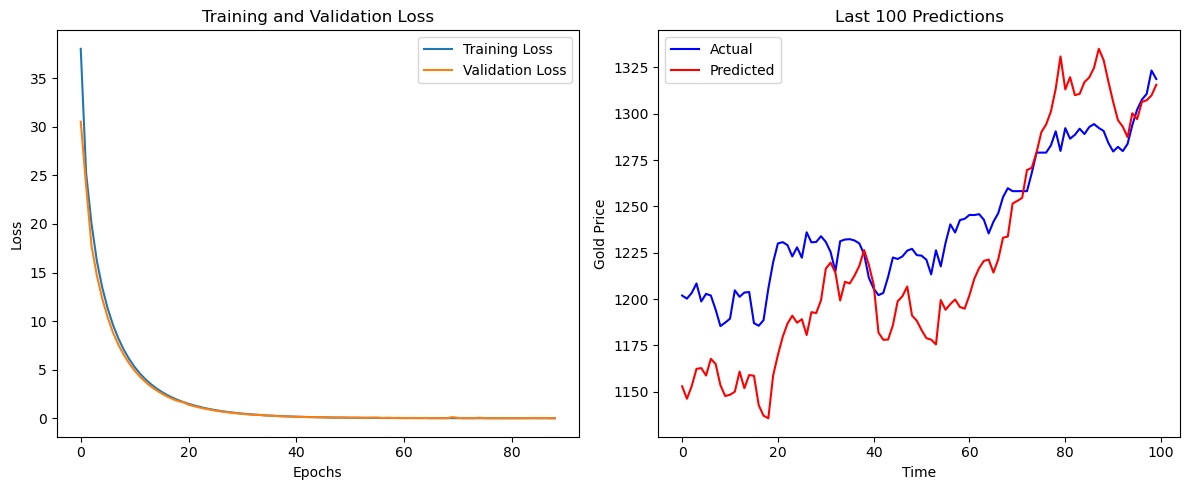


Analyzing feature importance...
31/31 [==============================] - 0s 13ms/step


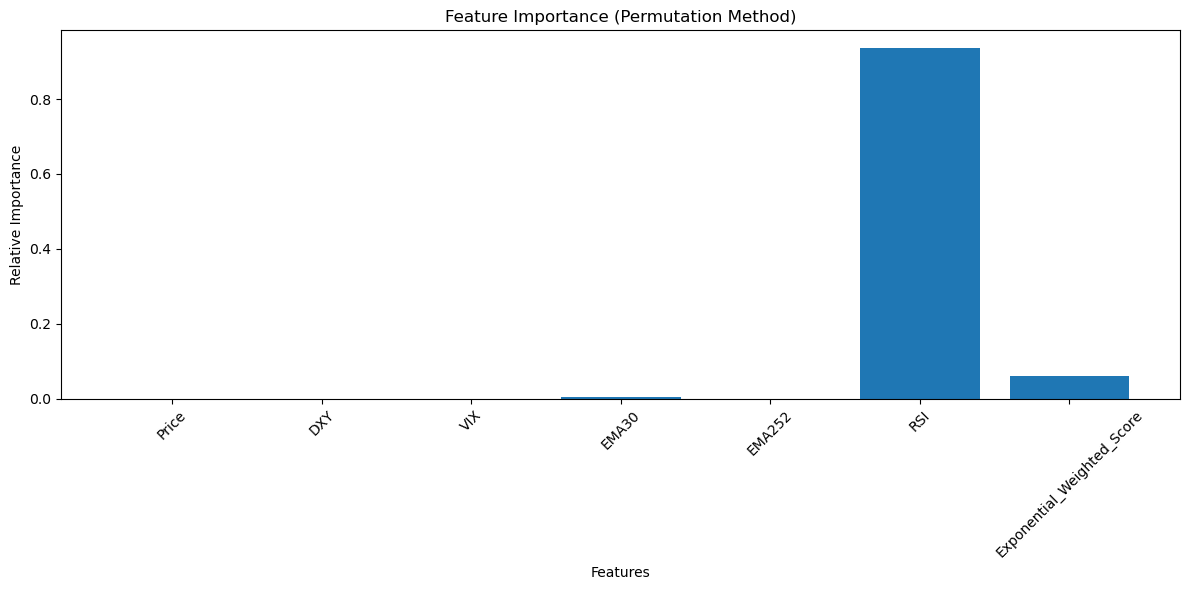


Visualizing attention over time...


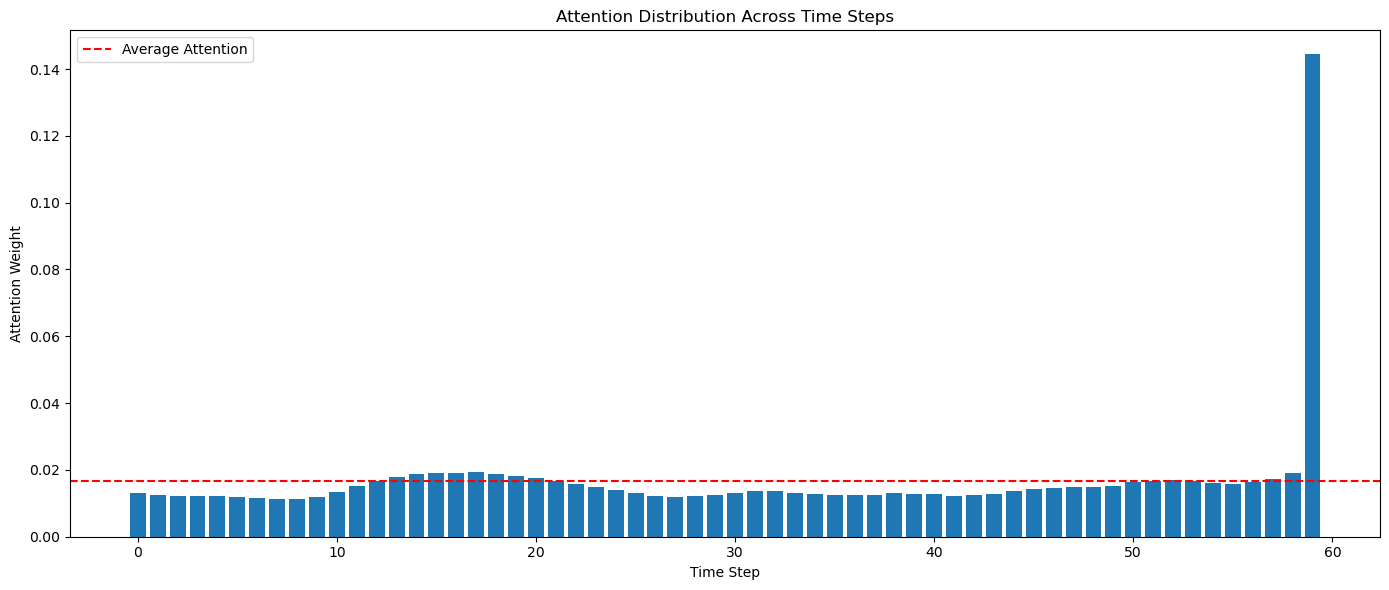

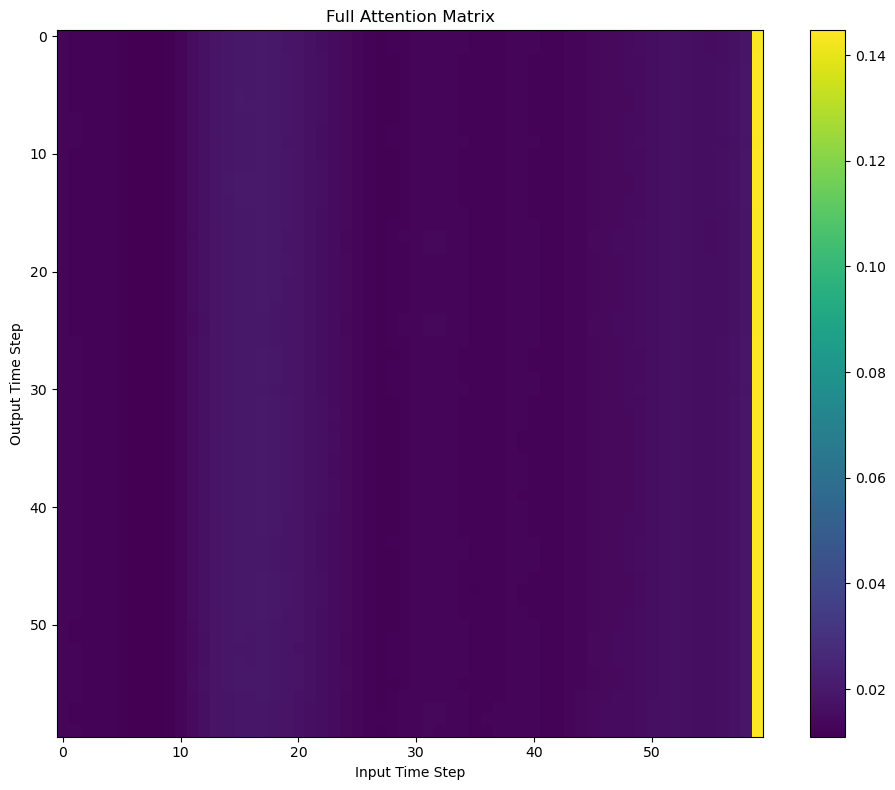


Running trading strategy backtest...


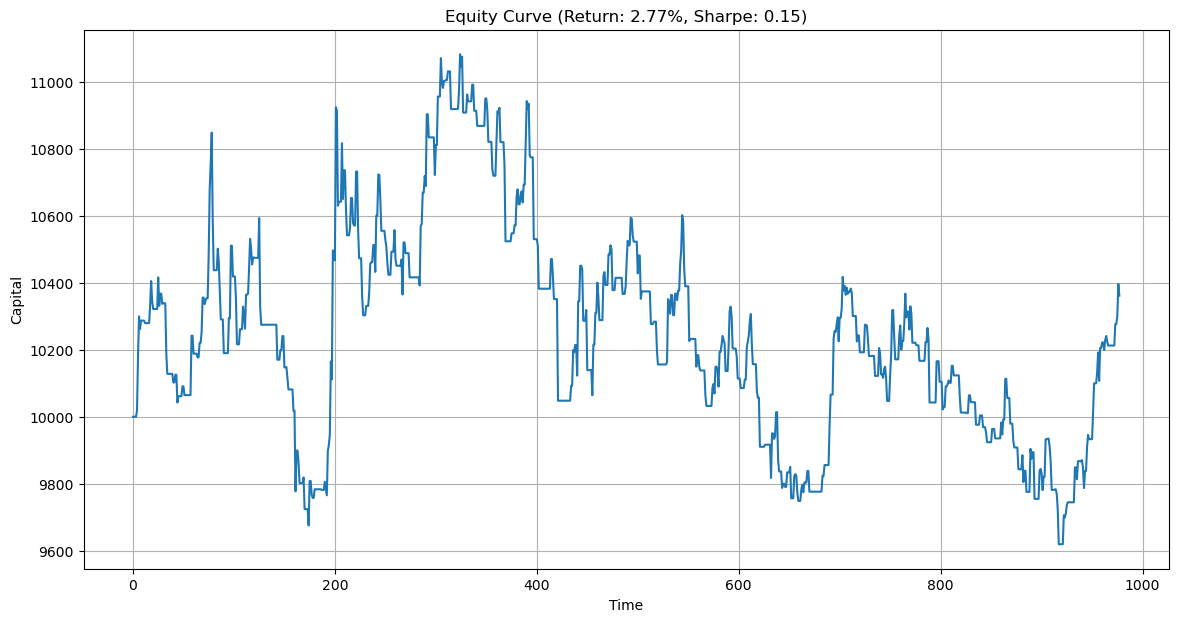

Final capital: $10277.11
Return: 2.77%
Sharpe Ratio: 0.15
Number of trades: 204
RMSE: 39.41
Directional Accuracy: 48.93%


In [10]:
df = load_data()

# Run the complete backtesting process
results = run_gold_price_backtesting(
    df,                     # Your dataframe with gold prices and features
    features = ["Price", "DXY", "VIX", "EMA30", "EMA252", "RSI", "Exponential_Weighted_Score"],
    seq_length=60,          # Length of sequence/window for predictions
    test_size=0.2,          # Proportion of data to use for testing
    d_model=256,            # Dimension of transformer model
    num_heads=8,            # Number of attention heads
    num_layers=4,           # Number of transformer layers
    dropout_rate=0.2,       # Dropout rate for regularization
    batch_size = 64,        # Batch size for training
    epochs=100,              # Maximum number of training epochs
    directional_loss_weight=0.7
)

# Access results
model = results['model']                   # The trained model
metrics = results['metrics']               # Performance metrics
feature_importance = results['feature_importance']  # Feature importance scores
trading_results = results['trading_results']        # Trading backtest results

# Print key metrics
print(f"RMSE: {metrics['rmse']:.2f}")
print(f"Directional Accuracy: {metrics['directional_accuracy']:.2f}%")

# Save model if needed
# model.save('gold_price_transformer.tf')

## Directional with L1 & L2 Regularisation

Training data shape: (5169, 60, 6)
Testing data shape: (1293, 60, 6)
Epoch 1/100
65/65 [==============================] - 9s 60ms/step - loss: 406.7311 - val_loss: 132.8120
Epoch 2/100
65/65 [==============================] - 3s 45ms/step - loss: 61.6796 - val_loss: 24.2544
Epoch 3/100
65/65 [==============================] - 3s 45ms/step - loss: 13.6611 - val_loss: 7.5515
Epoch 4/100
65/65 [==============================] - 3s 44ms/step - loss: 5.0822 - val_loss: 3.9084
Epoch 5/100
65/65 [==============================] - 3s 44ms/step - loss: 3.0642 - val_loss: 3.0046
Epoch 6/100
65/65 [==============================] - 3s 44ms/step - loss: 2.5692 - val_loss: 2.7911
Epoch 7/100
65/65 [==============================] - 3s 45ms/step - loss: 2.4411 - val_loss: 2.7284
Epoch 8/100
65/65 [==============================] - 3s 45ms/step - loss: 2.4139 - val_loss: 2.7204
Epoch 9/100
65/65 [==============================] - 3s 45ms/step - loss: 2.4047 - val_loss: 2.7201
Epoch 10/100
65/65 [====

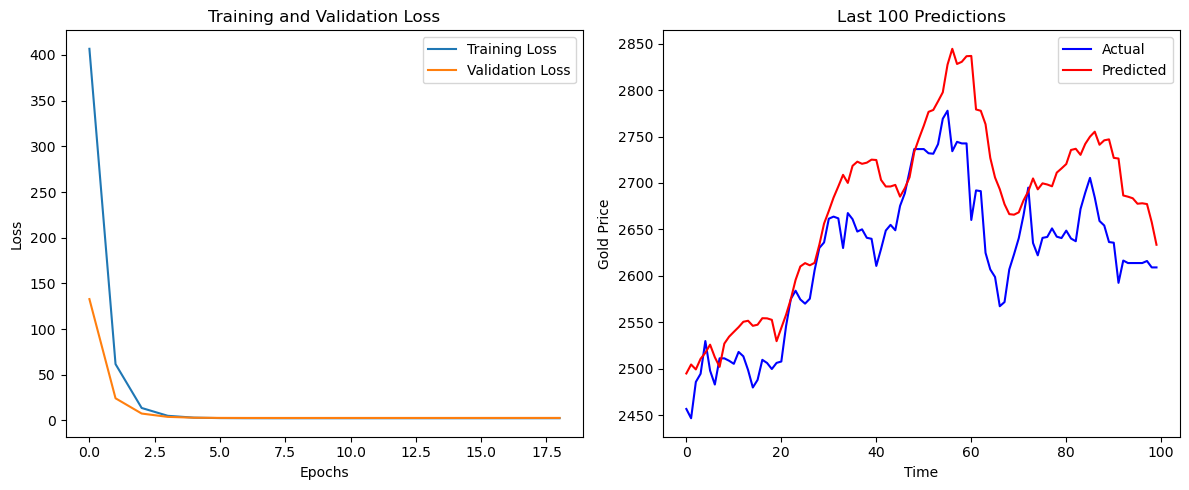


Analyzing feature importance...
41/41 [==============================] - 1s 13ms/step


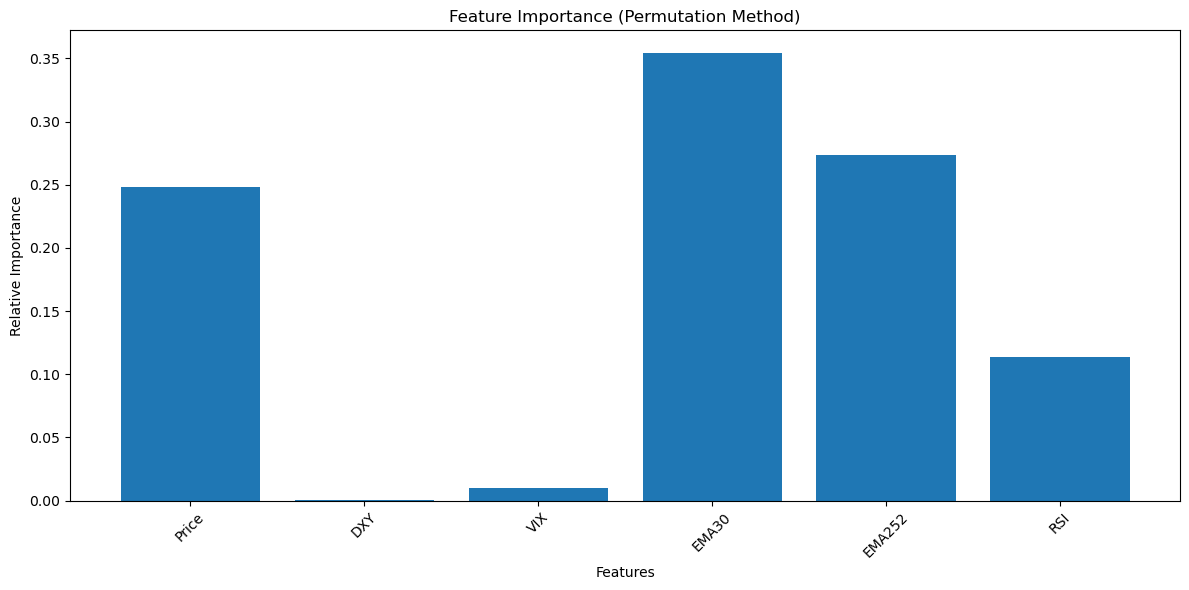


Visualizing attention over time...


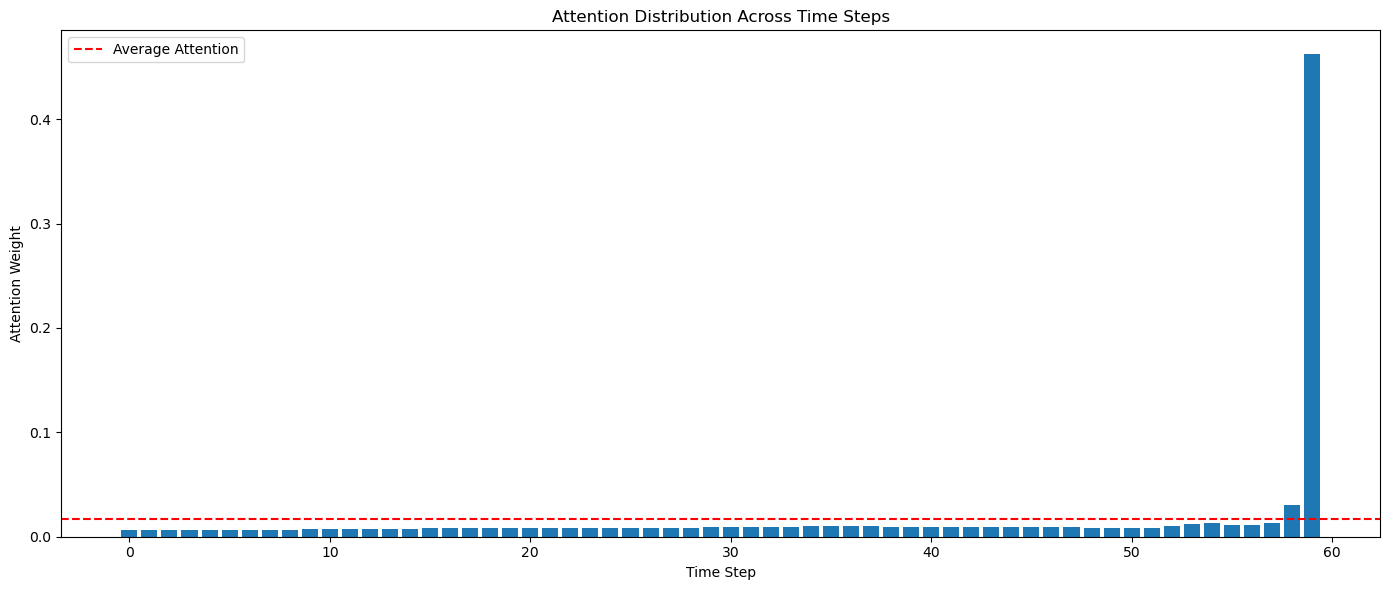

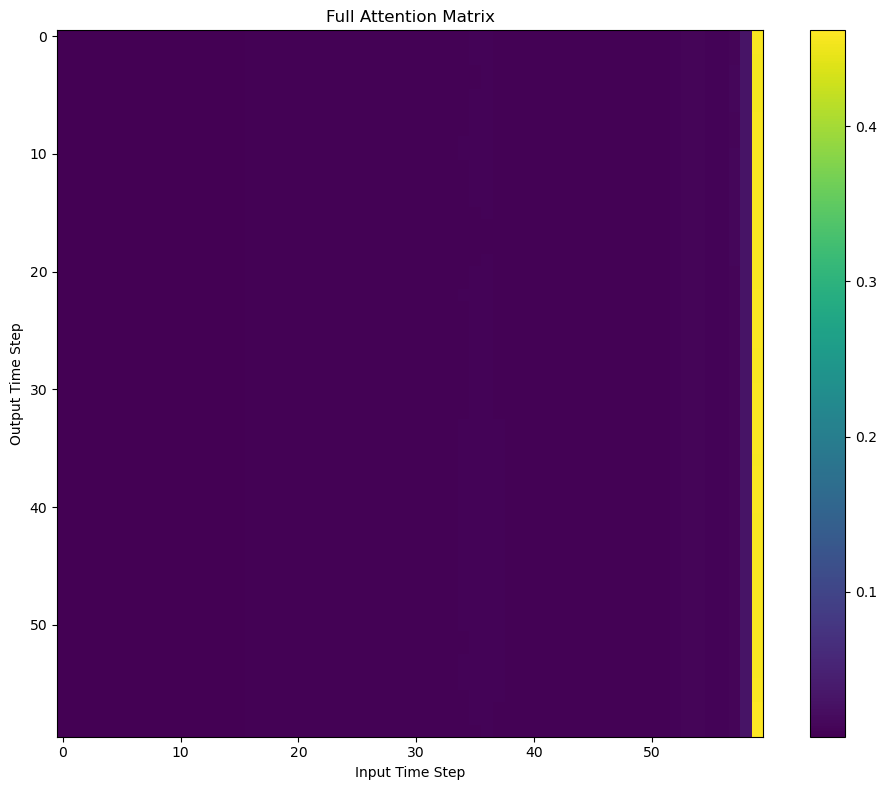


Running trading strategy backtest...


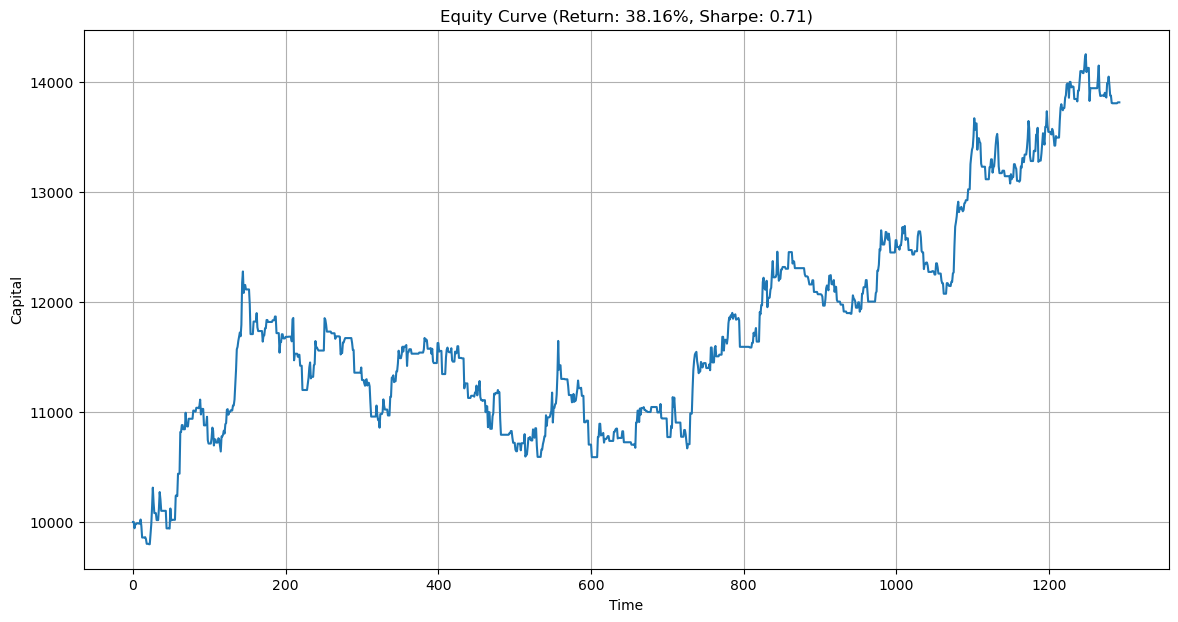

Final capital: $13816.02
Return: 38.16%
Sharpe Ratio: 0.71
Number of trades: 254
RMSE: 44.22
Directional Accuracy: 47.21%


In [57]:
df = load_data()

# Run the complete backtesting process
results = run_gold_price_backtesting(
    df,                     # Your dataframe with gold prices and features
    features = ["Price", "DXY", "VIX", "EMA30", "EMA252", "RSI"],
    seq_length=60,          # Length of sequence/window for predictions
    test_size=0.2,          # Proportion of data to use for testing
    d_model=256,            # Dimension of transformer model
    num_heads=8,            # Number of attention heads
    num_layers=4,           # Number of transformer layers
    dropout_rate=0.2,       # Dropout rate for regularization
    batch_size = 64,        # Batch size for training
    epochs=100,              # Maximum number of training epochs
    directional_loss_weight=0.7
)

# Access results
model = results['model']                   # The trained model
metrics = results['metrics']               # Performance metrics
feature_importance = results['feature_importance']  # Feature importance scores
trading_results = results['trading_results']        # Trading backtest results

# Print key metrics
print(f"RMSE: {metrics['rmse']:.2f}")
print(f"Directional Accuracy: {metrics['directional_accuracy']:.2f}%")

# Save model if needed
# model.save('gold_price_transformer.tf')

Training data shape: (3911, 60, 7)
Testing data shape: (978, 60, 7)
Epoch 1/100
49/49 [==============================] - 9s 64ms/step - loss: 456.8230 - val_loss: 196.2672
Epoch 2/100
49/49 [==============================] - 2s 44ms/step - loss: 93.8426 - val_loss: 38.4468
Epoch 3/100
49/49 [==============================] - 2s 44ms/step - loss: 22.0200 - val_loss: 11.9136
Epoch 4/100
49/49 [==============================] - 2s 44ms/step - loss: 7.8014 - val_loss: 5.4183
Epoch 5/100
49/49 [==============================] - 2s 45ms/step - loss: 4.0373 - val_loss: 3.5780
Epoch 6/100
49/49 [==============================] - 2s 46ms/step - loss: 2.9281 - val_loss: 3.0039
Epoch 7/100
49/49 [==============================] - 2s 46ms/step - loss: 2.5960 - val_loss: 2.8311
Epoch 8/100
49/49 [==============================] - 2s 46ms/step - loss: 2.4964 - val_loss: 2.7884
Epoch 9/100
49/49 [==============================] - 2s 47ms/step - loss: 2.4624 - val_loss: 2.7731
Epoch 10/100
49/49 [====

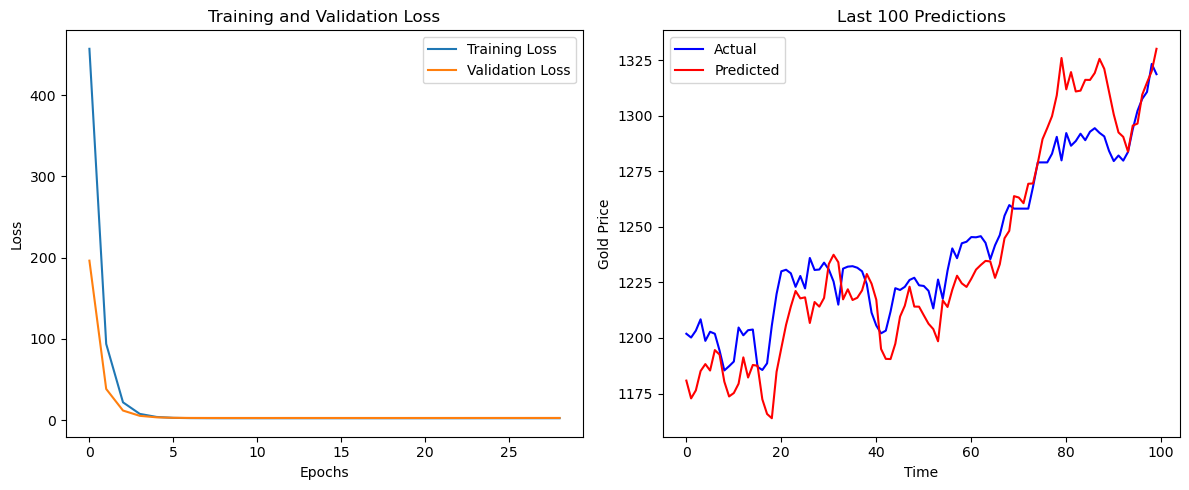


Analyzing feature importance...
31/31 [==============================] - 0s 14ms/step


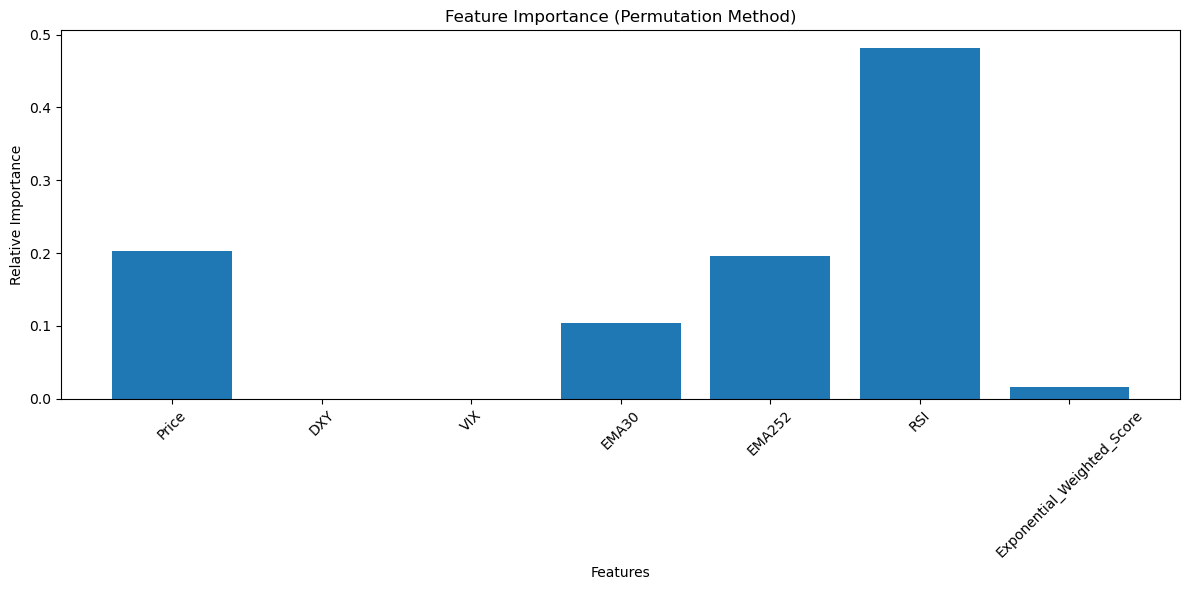


Visualizing attention over time...


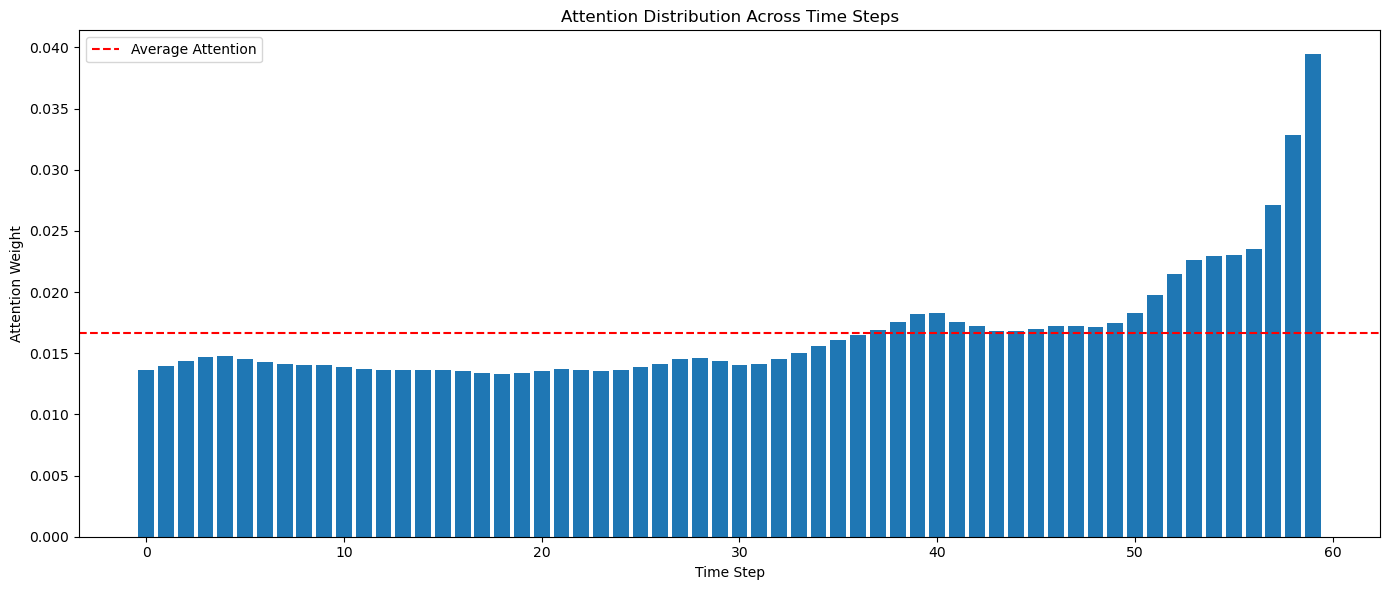

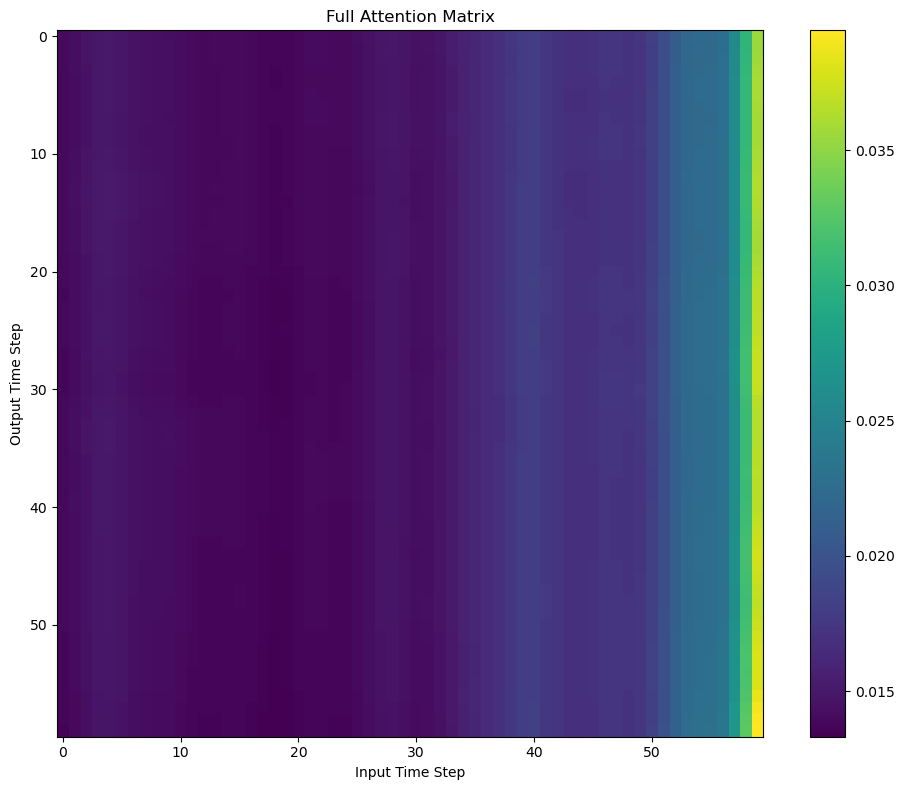


Running trading strategy backtest...


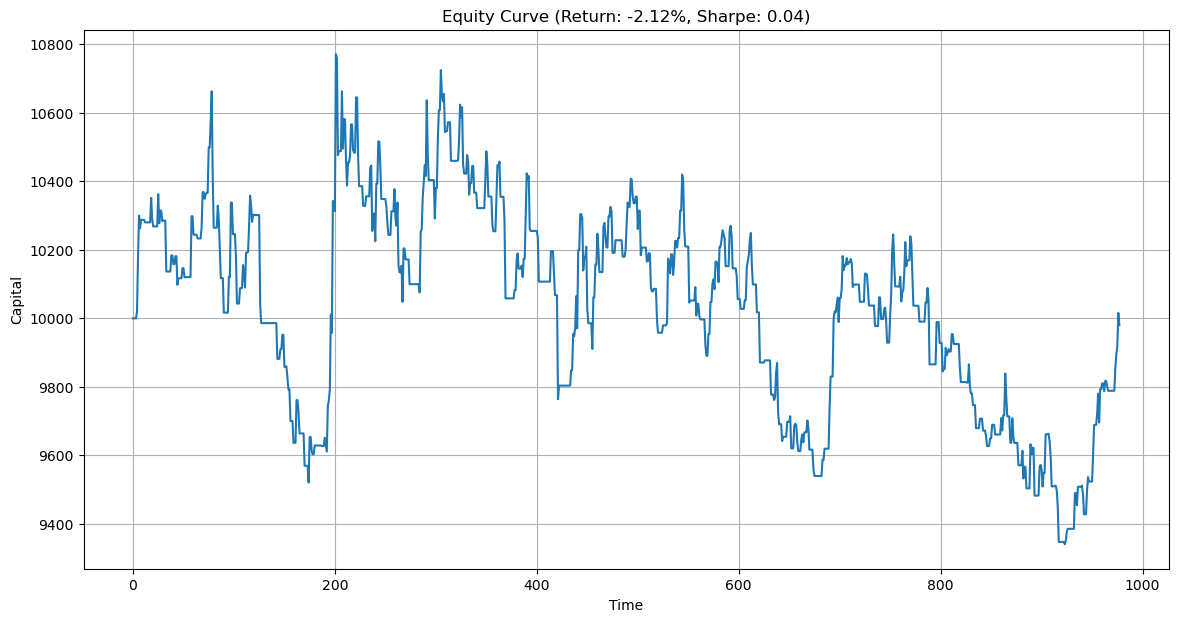

Final capital: $9788.45
Return: -2.12%
Sharpe Ratio: 0.04
Number of trades: 196
RMSE: 26.30
Directional Accuracy: 48.93%


In [58]:
df = load_data()

# Run the complete backtesting process
results = run_gold_price_backtesting(
    df,                     # Your dataframe with gold prices and features
    features = ["Price", "DXY", "VIX", "EMA30", "EMA252", "RSI", "Exponential_Weighted_Score"],
    seq_length=60,          # Length of sequence/window for predictions
    test_size=0.2,          # Proportion of data to use for testing
    d_model=256,            # Dimension of transformer model
    num_heads=8,            # Number of attention heads
    num_layers=4,           # Number of transformer layers
    dropout_rate=0.2,       # Dropout rate for regularization
    batch_size = 64,        # Batch size for training
    epochs=100,              # Maximum number of training epochs
    directional_loss_weight=0.7
)

# Access results
model = results['model']                   # The trained model
metrics = results['metrics']               # Performance metrics
feature_importance = results['feature_importance']  # Feature importance scores
trading_results = results['trading_results']        # Trading backtest results

# Print key metrics
print(f"RMSE: {metrics['rmse']:.2f}")
print(f"Directional Accuracy: {metrics['directional_accuracy']:.2f}%")

# Save model if needed
# model.save('gold_price_transformer.tf')

## Directional with L2 Regularisation

Training data shape: (5169, 60, 6)
Testing data shape: (1293, 60, 6)
Epoch 1/100
65/65 [==============================] - 9s 57ms/step - loss: 25.9365 - val_loss: 17.0782
Epoch 2/100
65/65 [==============================] - 3s 43ms/step - loss: 13.0376 - val_loss: 9.7986
Epoch 3/100
65/65 [==============================] - 3s 43ms/step - loss: 7.6506 - val_loss: 6.2938
Epoch 4/100
65/65 [==============================] - 3s 43ms/step - loss: 4.9410 - val_loss: 4.2864
Epoch 5/100
65/65 [==============================] - 3s 43ms/step - loss: 3.3349 - val_loss: 3.0475
Epoch 6/100
65/65 [==============================] - 3s 43ms/step - loss: 2.3283 - val_loss: 2.2537
Epoch 7/100
65/65 [==============================] - 3s 43ms/step - loss: 1.6516 - val_loss: 1.7181
Epoch 8/100
65/65 [==============================] - 3s 43ms/step - loss: 1.2055 - val_loss: 1.3372
Epoch 9/100
65/65 [==============================] - 3s 43ms/step - loss: 0.8827 - val_loss: 1.0829
Epoch 10/100
65/65 [========

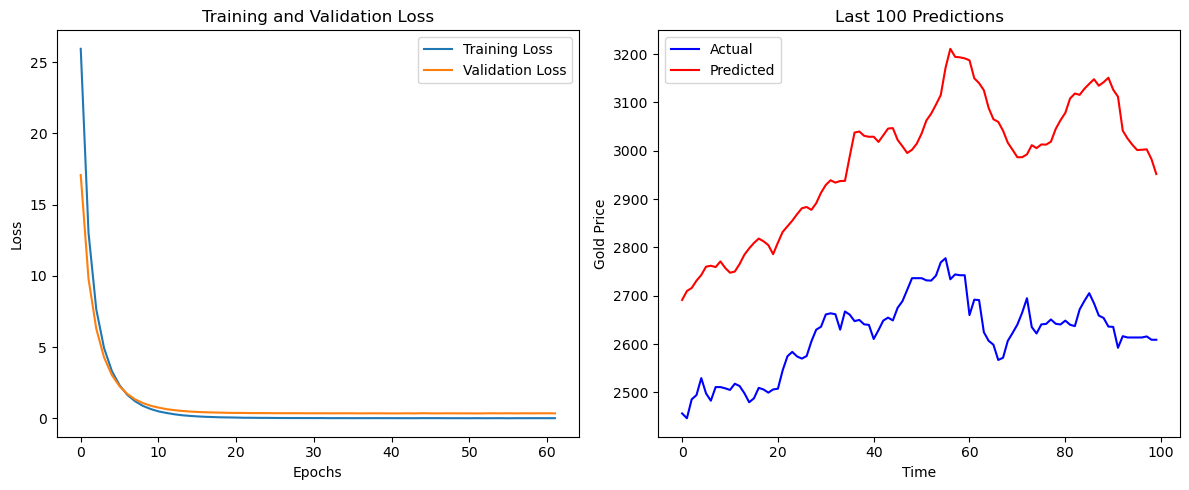


Analyzing feature importance...
41/41 [==============================] - 1s 13ms/step


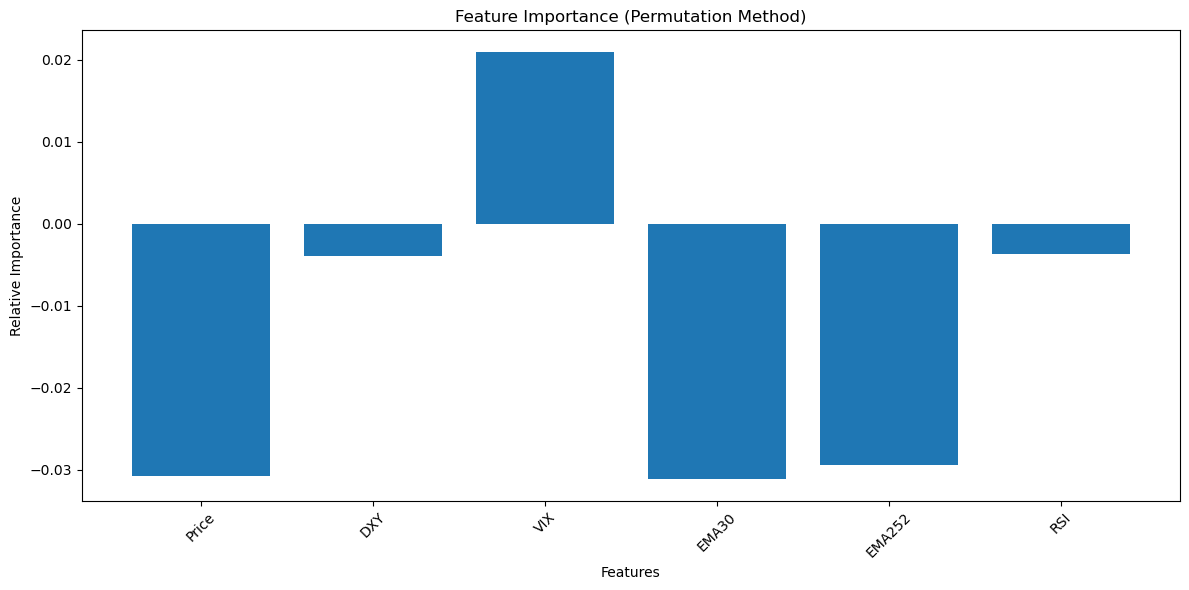


Visualizing attention over time...


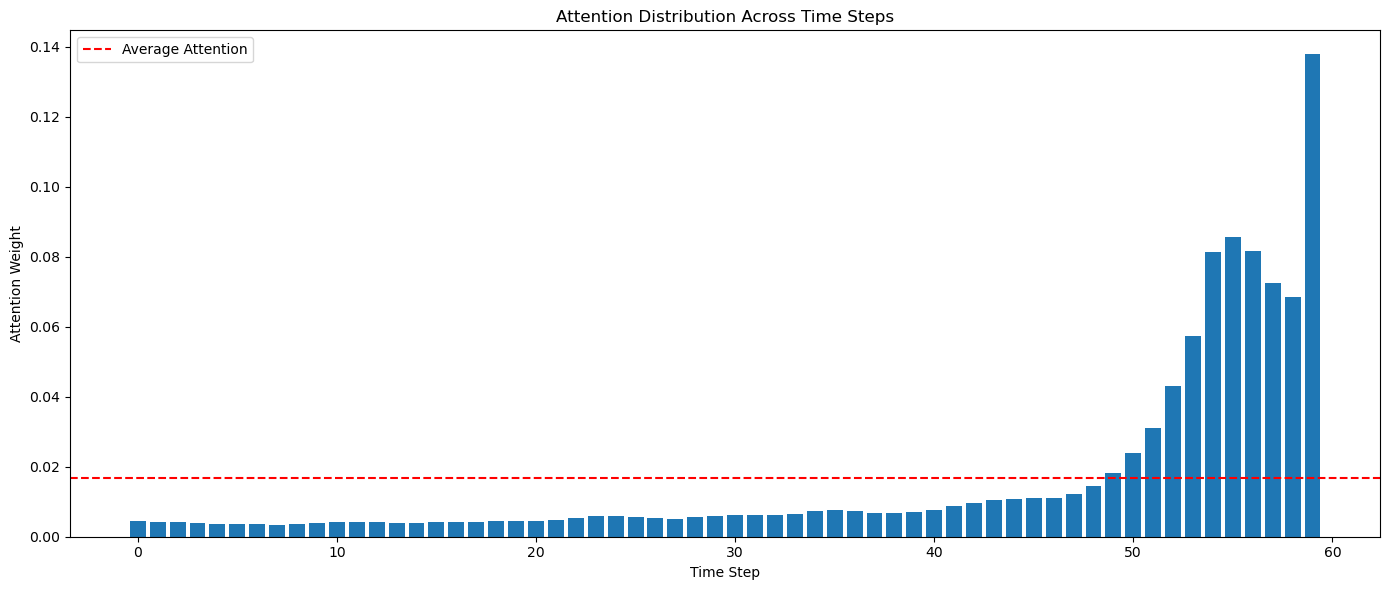

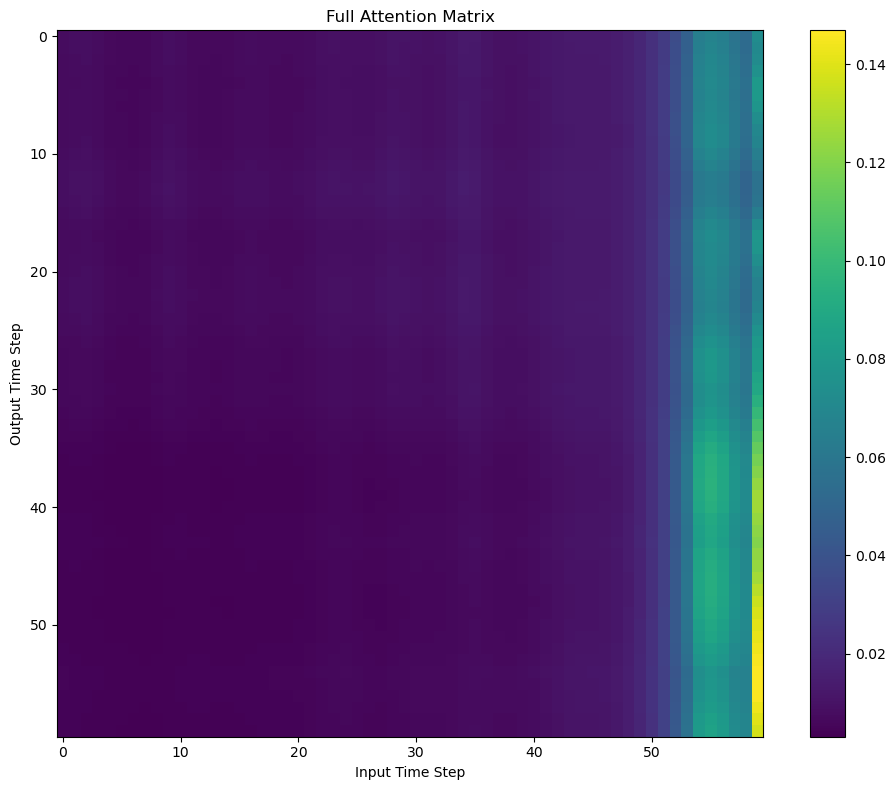


Running trading strategy backtest...


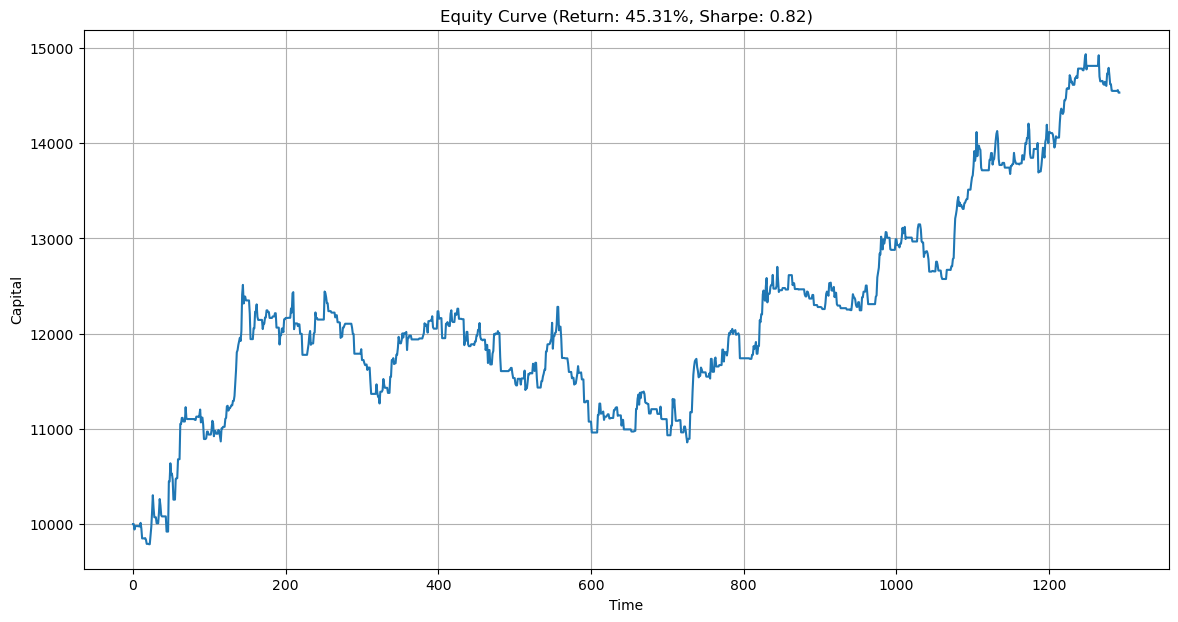

Final capital: $14530.73
Return: 45.31%
Sharpe Ratio: 0.82
Number of trades: 262
RMSE: 144.65
Directional Accuracy: 47.21%


In [54]:
df = load_data()

# Run the complete backtesting process
results = run_gold_price_backtesting(
    df,                     # Your dataframe with gold prices and features
    features = ["Price", "DXY", "VIX", "EMA30", "EMA252", "RSI"],
    seq_length=60,          # Length of sequence/window for predictions
    test_size=0.2,          # Proportion of data to use for testing
    d_model=256,            # Dimension of transformer model
    num_heads=8,            # Number of attention heads
    num_layers=4,           # Number of transformer layers
    dropout_rate=0.2,       # Dropout rate for regularization
    batch_size = 64,        # Batch size for training
    epochs=100,              # Maximum number of training epochs
    directional_loss_weight=0.7
)

# Access results
model = results['model']                   # The trained model
metrics = results['metrics']               # Performance metrics
feature_importance = results['feature_importance']  # Feature importance scores
trading_results = results['trading_results']        # Trading backtest results

# Print key metrics
print(f"RMSE: {metrics['rmse']:.2f}")
print(f"Directional Accuracy: {metrics['directional_accuracy']:.2f}%")

# Save model if needed
# model.save('gold_price_transformer.tf')

Training data shape: (3911, 60, 7)
Testing data shape: (978, 60, 7)
Epoch 1/100
49/49 [==============================] - 8s 63ms/step - loss: 29.5388 - val_loss: 21.7327
Epoch 2/100
49/49 [==============================] - 2s 44ms/step - loss: 17.2691 - val_loss: 14.2249
Epoch 3/100
49/49 [==============================] - 2s 43ms/step - loss: 11.2810 - val_loss: 9.3181
Epoch 4/100
49/49 [==============================] - 2s 43ms/step - loss: 7.7045 - val_loss: 6.7038
Epoch 5/100
49/49 [==============================] - 2s 43ms/step - loss: 5.5321 - val_loss: 4.9837
Epoch 6/100
49/49 [==============================] - 2s 44ms/step - loss: 4.0792 - val_loss: 3.8126
Epoch 7/100
49/49 [==============================] - 2s 43ms/step - loss: 3.0702 - val_loss: 2.9767
Epoch 8/100
49/49 [==============================] - 2s 43ms/step - loss: 2.3457 - val_loss: 2.3670
Epoch 9/100
49/49 [==============================] - 2s 43ms/step - loss: 1.8186 - val_loss: 1.9193
Epoch 10/100
49/49 [=======

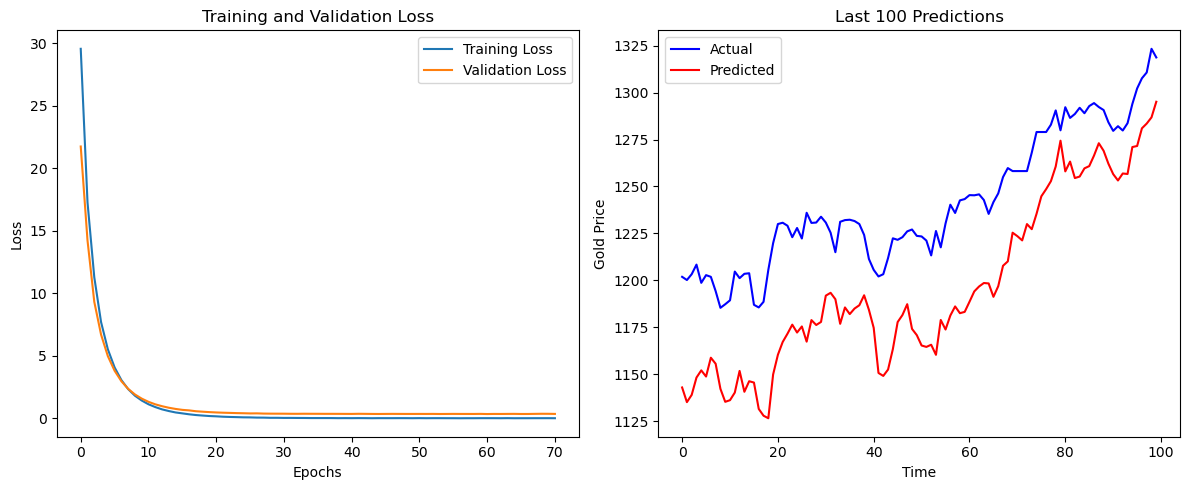


Analyzing feature importance...
31/31 [==============================] - 0s 13ms/step


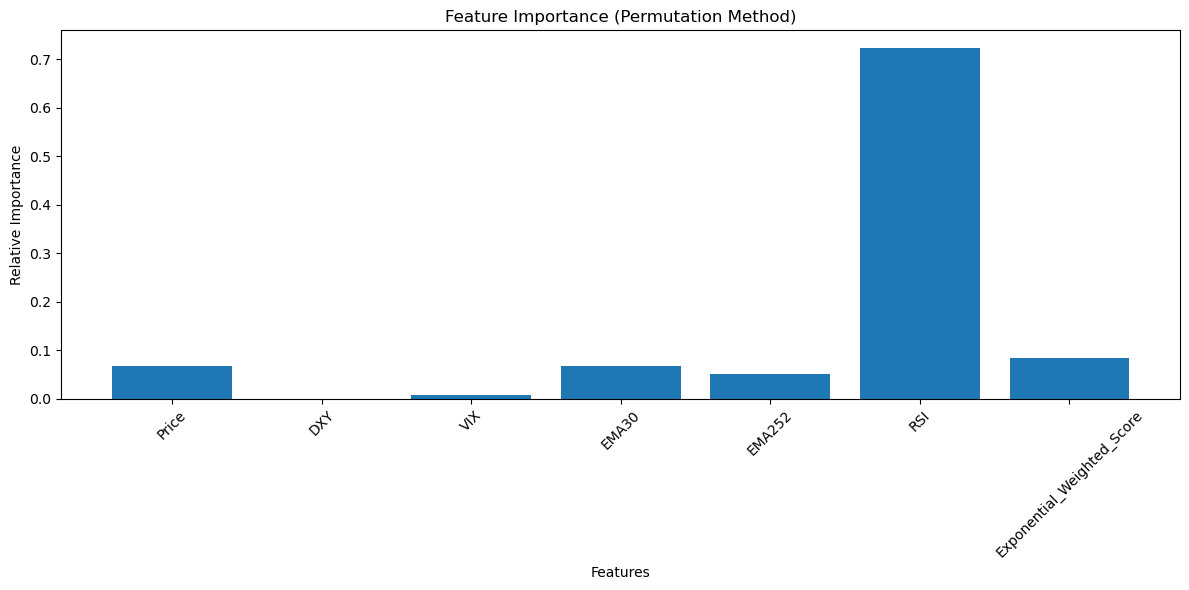


Visualizing attention over time...


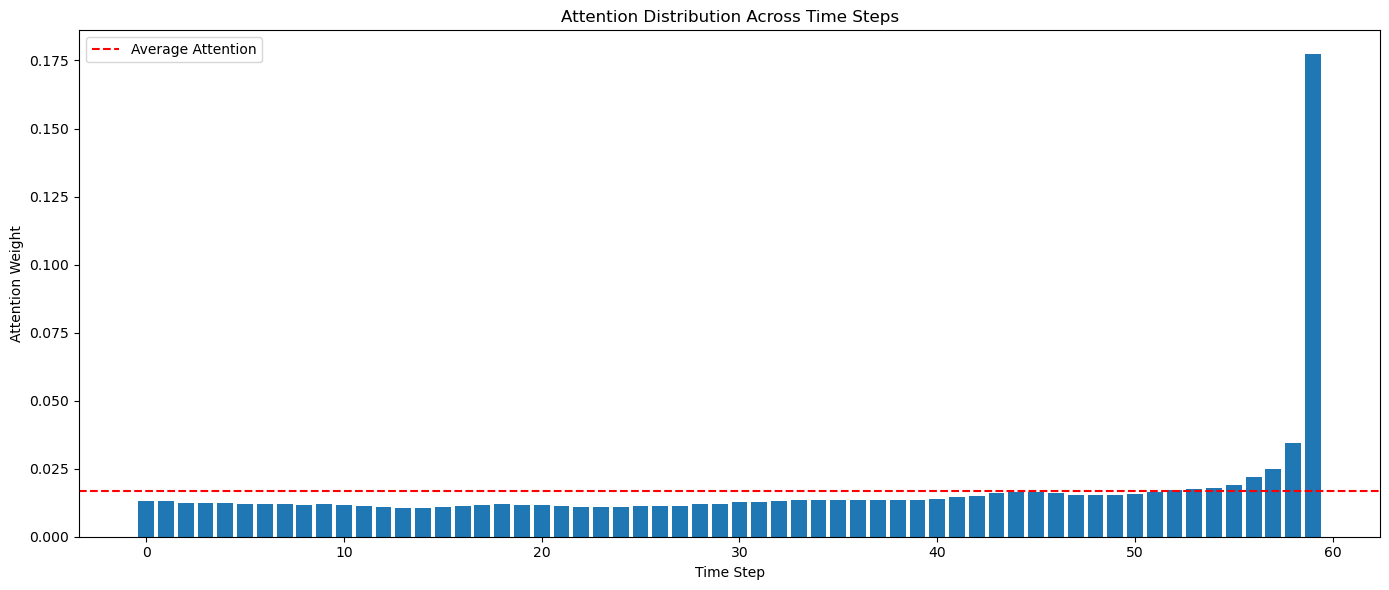

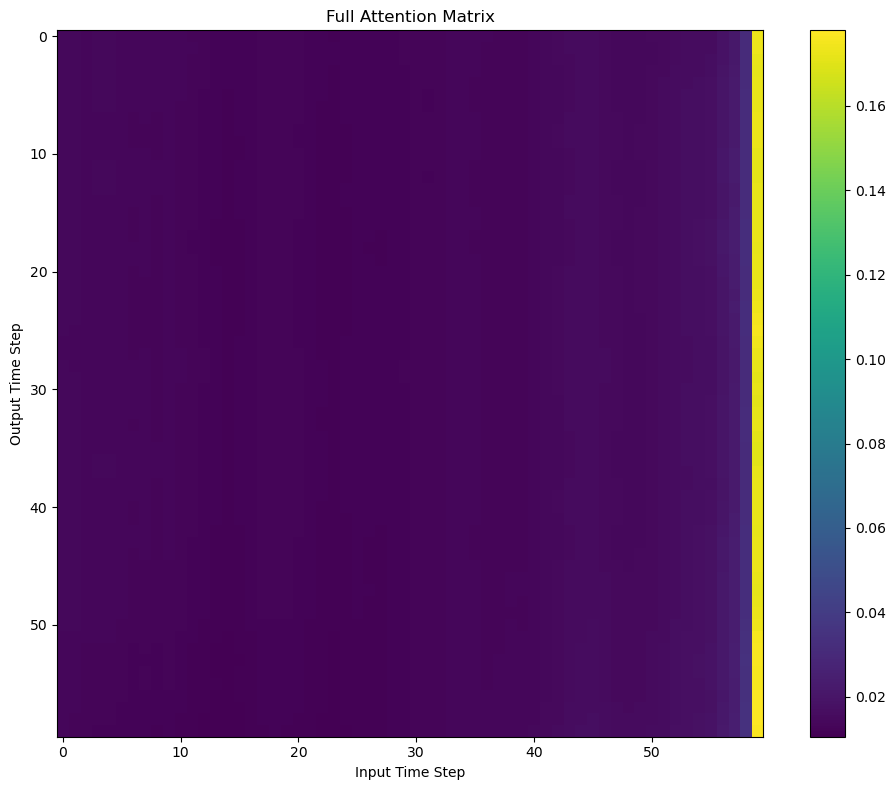


Running trading strategy backtest...


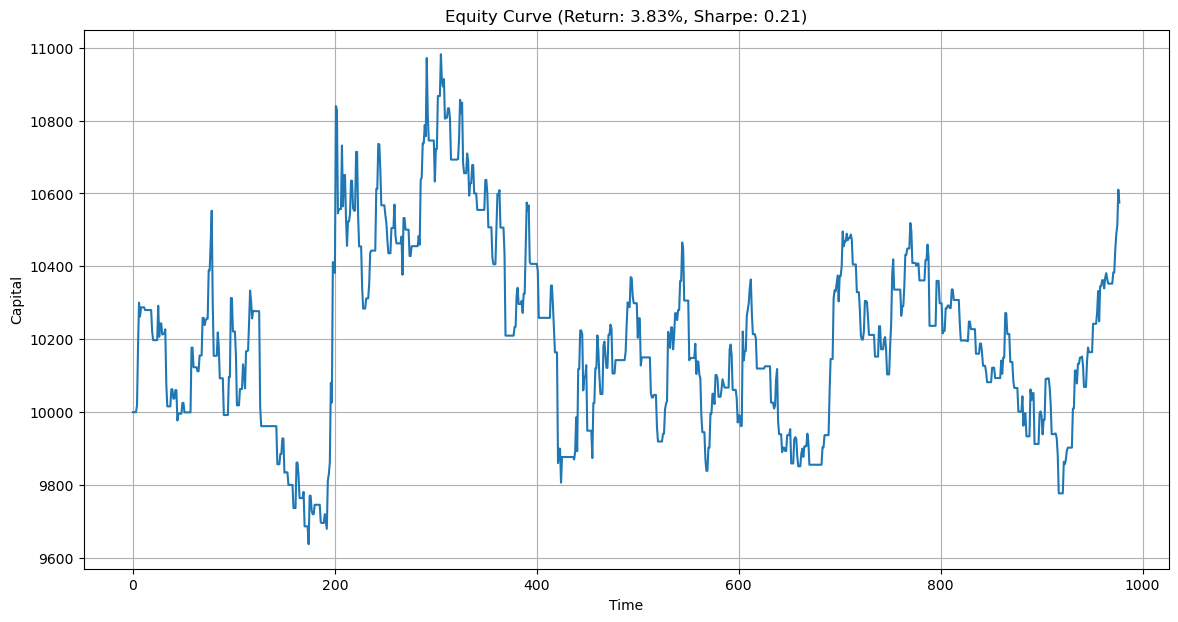

Final capital: $10383.18
Return: 3.83%
Sharpe Ratio: 0.21
Number of trades: 208
RMSE: 50.37
Directional Accuracy: 47.80%


In [55]:
df = load_data()

# Run the complete backtesting process
results = run_gold_price_backtesting(
    df,                     # Your dataframe with gold prices and features
    features = ["Price", "DXY", "VIX", "EMA30", "EMA252", "RSI", "Exponential_Weighted_Score"],
    seq_length=60,          # Length of sequence/window for predictions
    test_size=0.2,          # Proportion of data to use for testing
    d_model=256,            # Dimension of transformer model
    num_heads=8,            # Number of attention heads
    num_layers=4,           # Number of transformer layers
    dropout_rate=0.2,       # Dropout rate for regularization
    batch_size = 64,        # Batch size for training
    epochs=100,              # Maximum number of training epochs
    directional_loss_weight=0.7
)

# Access results
model = results['model']                   # The trained model
metrics = results['metrics']               # Performance metrics
feature_importance = results['feature_importance']  # Feature importance scores
trading_results = results['trading_results']        # Trading backtest results

# Print key metrics
print(f"RMSE: {metrics['rmse']:.2f}")
print(f"Directional Accuracy: {metrics['directional_accuracy']:.2f}%")

# Save model if needed
# model.save('gold_price_transformer.tf')

## MSE

Training data shape: (5587, 60, 1)
Testing data shape: (1397, 60, 1)
Epoch 1/100
70/70 [==============================] - 8s 50ms/step - loss: 5.2195 - val_loss: 0.7746
Epoch 2/100
70/70 [==============================] - 3s 40ms/step - loss: 0.7608 - val_loss: 1.1137
Epoch 3/100
70/70 [==============================] - 3s 40ms/step - loss: 0.6962 - val_loss: 0.1250
Epoch 4/100
70/70 [==============================] - 3s 40ms/step - loss: 0.1042 - val_loss: 0.0798
Epoch 5/100
70/70 [==============================] - 3s 40ms/step - loss: 0.0386 - val_loss: 0.1275
Epoch 6/100
70/70 [==============================] - 3s 41ms/step - loss: 0.0271 - val_loss: 0.0034
Epoch 7/100
70/70 [==============================] - 3s 41ms/step - loss: 0.0191 - val_loss: 0.0263
Epoch 8/100
70/70 [==============================] - 3s 40ms/step - loss: 0.0149 - val_loss: 0.0124
Epoch 9/100
70/70 [==============================] - 3s 41ms/step - loss: 0.0146 - val_loss: 0.0027
Epoch 10/100
70/70 [===========

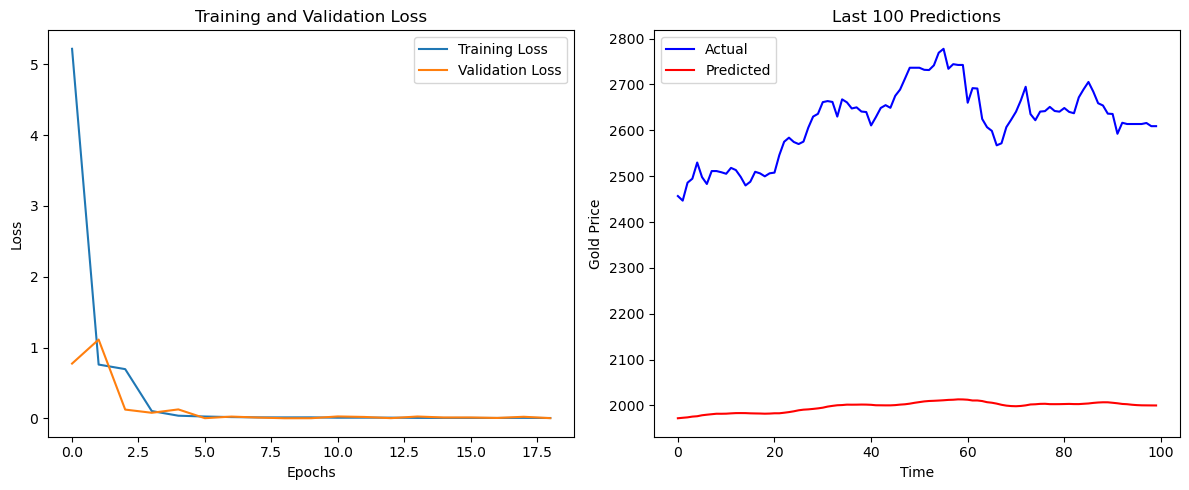


Analyzing feature importance...
44/44 [==============================] - 1s 14ms/step


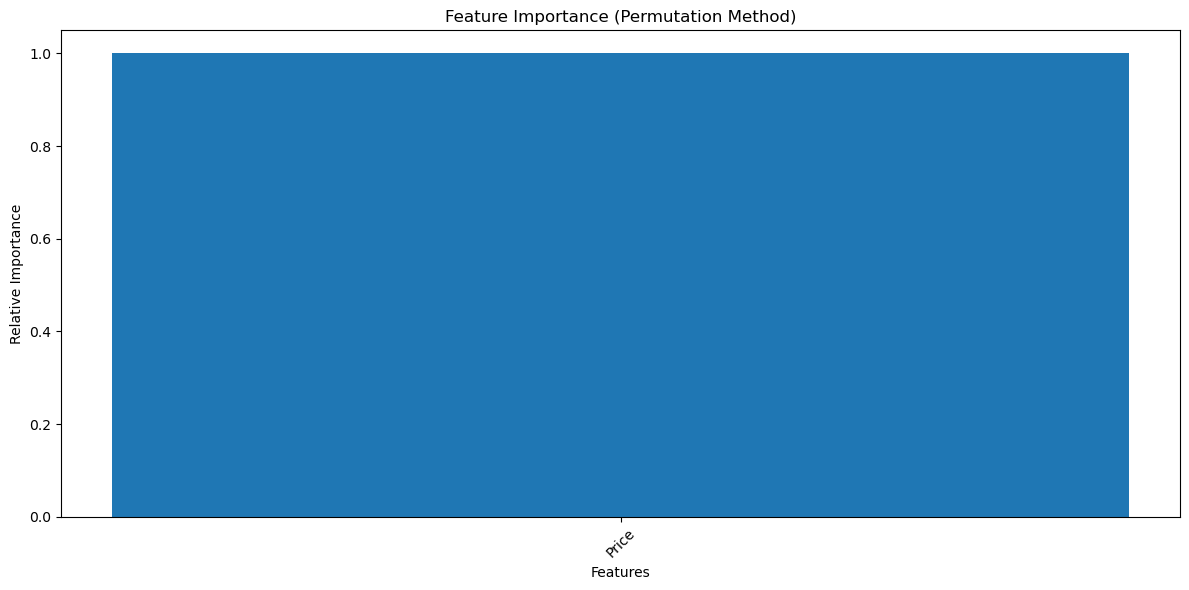


Visualizing attention over time...


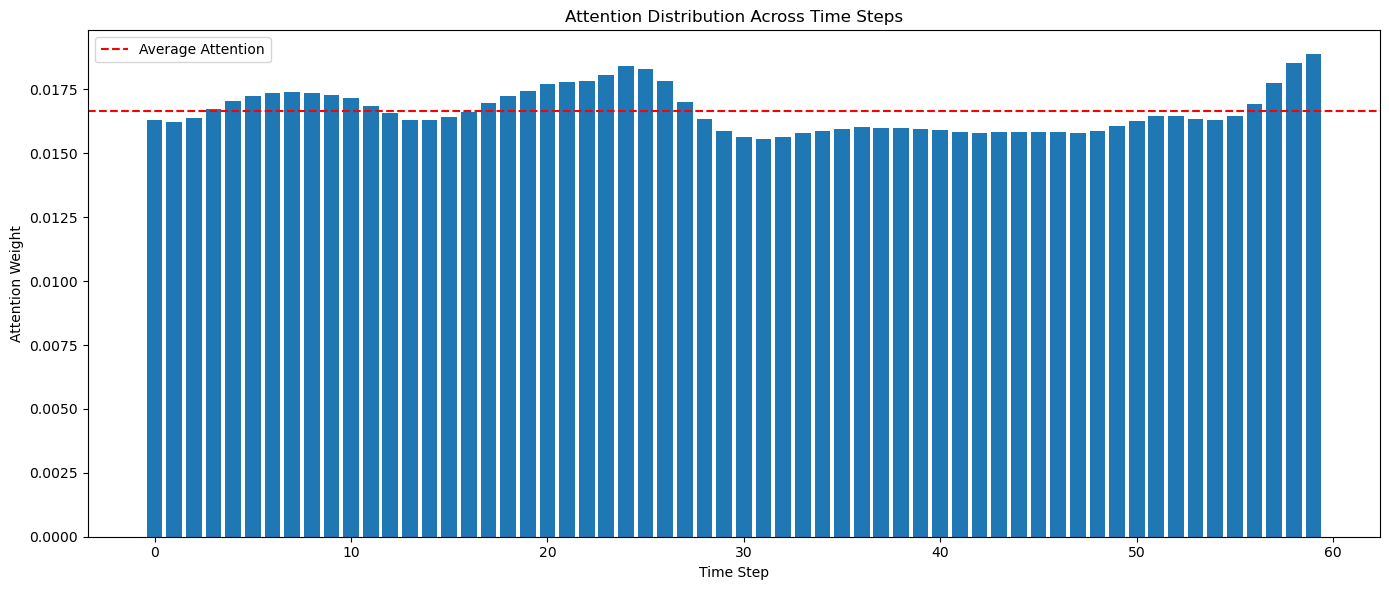

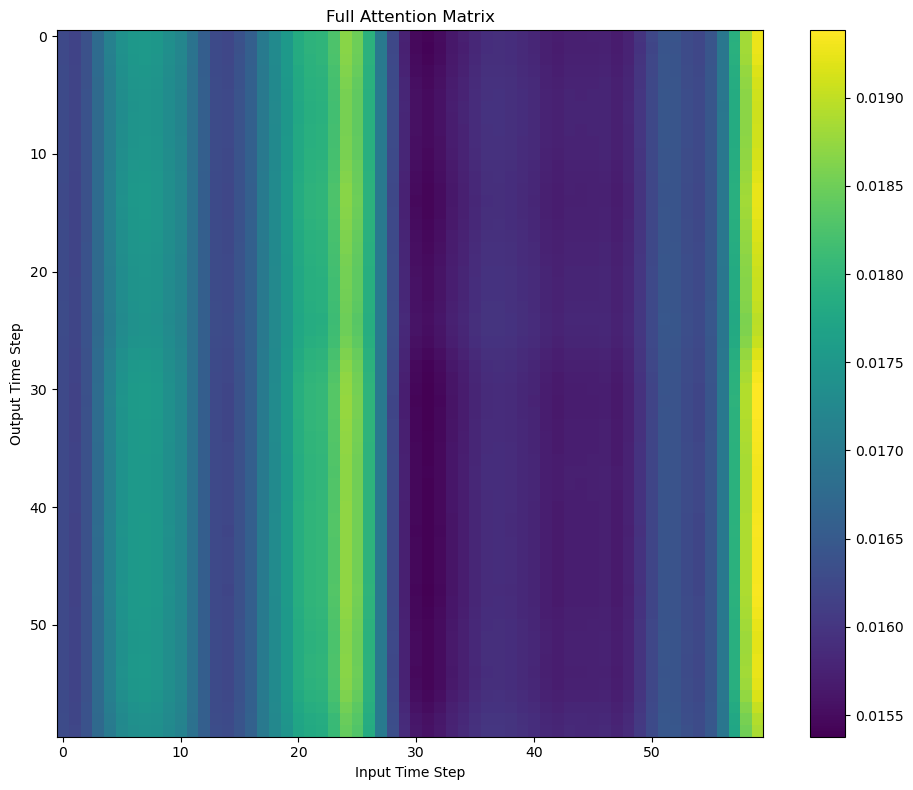


Running trading strategy backtest...


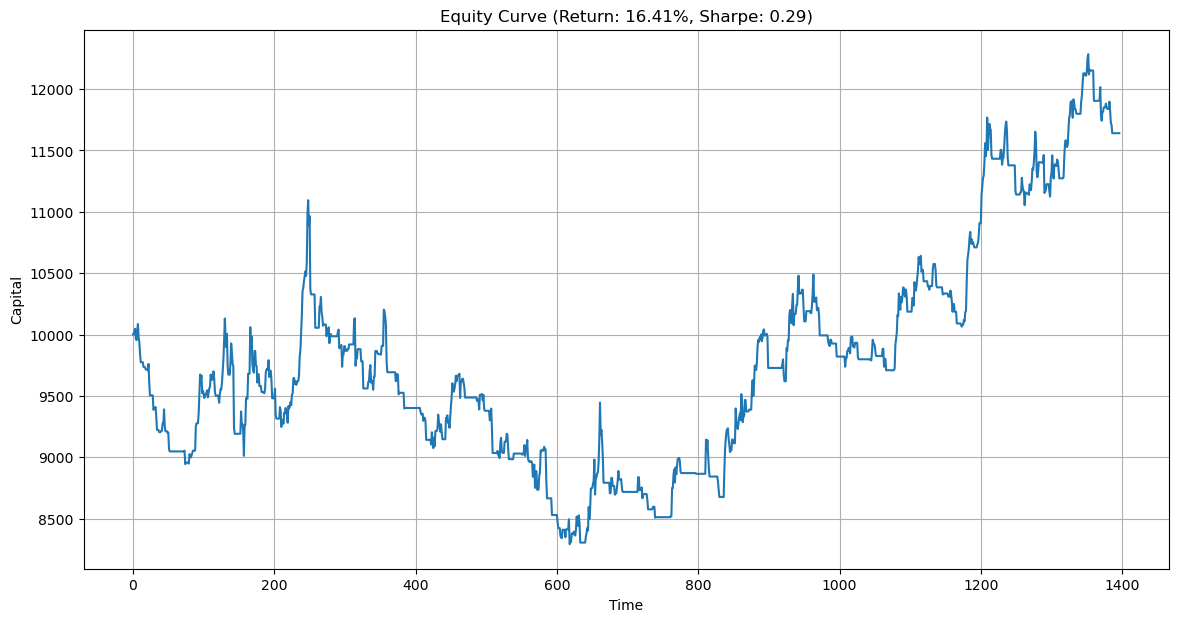

Final capital: $11640.77
Return: 16.41%
Sharpe Ratio: 0.29
Number of trades: 159
RMSE: 211.88
Directional Accuracy: 48.57%


In [47]:
df = load_data()

# Run the complete backtesting process
results = run_gold_price_backtesting(
    df,                     # Your dataframe with gold prices and features
    features = ["Price"],
    seq_length=60,          # Length of sequence/window for predictions
    test_size=0.2,          # Proportion of data to use for testing
    d_model=256,            # Dimension of transformer model
    num_heads=8,            # Number of attention heads
    num_layers=4,           # Number of transformer layers
    dropout_rate=0.2,       # Dropout rate for regularization
    batch_size = 64,        # Batch size for training
    epochs=100,              # Maximum number of training epochs
    directional_loss_weight=0.7
)

# Access results
model = results['model']                   # The trained model
metrics = results['metrics']               # Performance metrics
feature_importance = results['feature_importance']  # Feature importance scores
trading_results = results['trading_results']        # Trading backtest results

# Print key metrics
print(f"RMSE: {metrics['rmse']:.2f}")
print(f"Directional Accuracy: {metrics['directional_accuracy']:.2f}%")

# Save model if needed
# model.save('gold_price_transformer.tf')

Training data shape: (5169, 60, 6)
Testing data shape: (1293, 60, 6)
Epoch 1/100
65/65 [==============================] - 10s 73ms/step - loss: 5.8636 - val_loss: 0.8014
Epoch 2/100
65/65 [==============================] - 3s 44ms/step - loss: 0.7317 - val_loss: 0.4948
Epoch 3/100
65/65 [==============================] - 3s 43ms/step - loss: 0.2595 - val_loss: 0.0117
Epoch 4/100
65/65 [==============================] - 3s 43ms/step - loss: 0.0485 - val_loss: 0.0190
Epoch 5/100
65/65 [==============================] - 3s 42ms/step - loss: 0.0269 - val_loss: 0.0375
Epoch 6/100
65/65 [==============================] - 3s 43ms/step - loss: 0.0200 - val_loss: 0.1392
Epoch 7/100
65/65 [==============================] - 3s 42ms/step - loss: 0.0161 - val_loss: 0.0354
Epoch 8/100
65/65 [==============================] - 3s 41ms/step - loss: 0.0119 - val_loss: 0.0135
Epoch 9/100
65/65 [==============================] - 3s 41ms/step - loss: 0.0104 - val_loss: 0.0402
Epoch 10/100
65/65 [==========

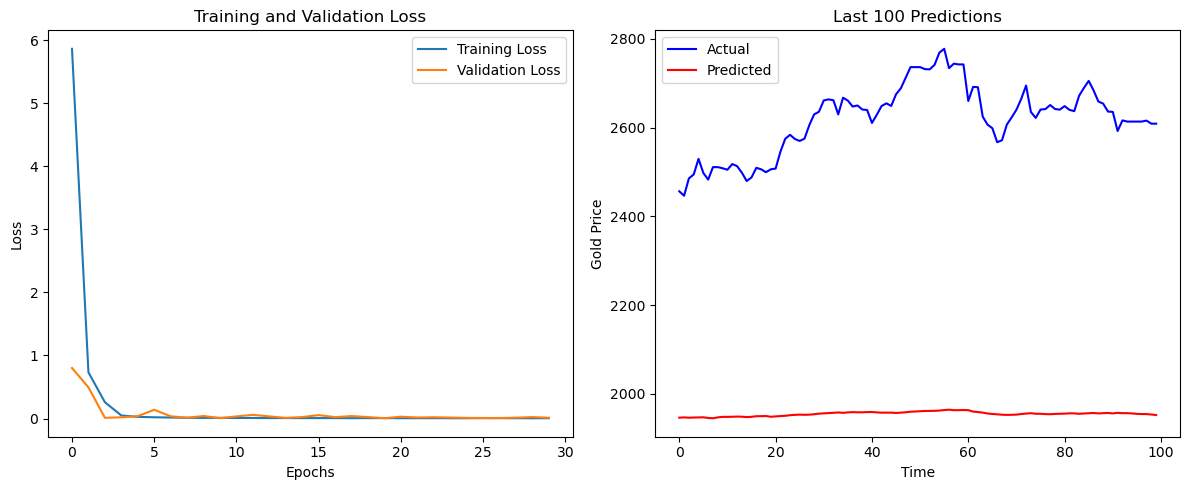


Analyzing feature importance...
41/41 [==============================] - 1s 14ms/step


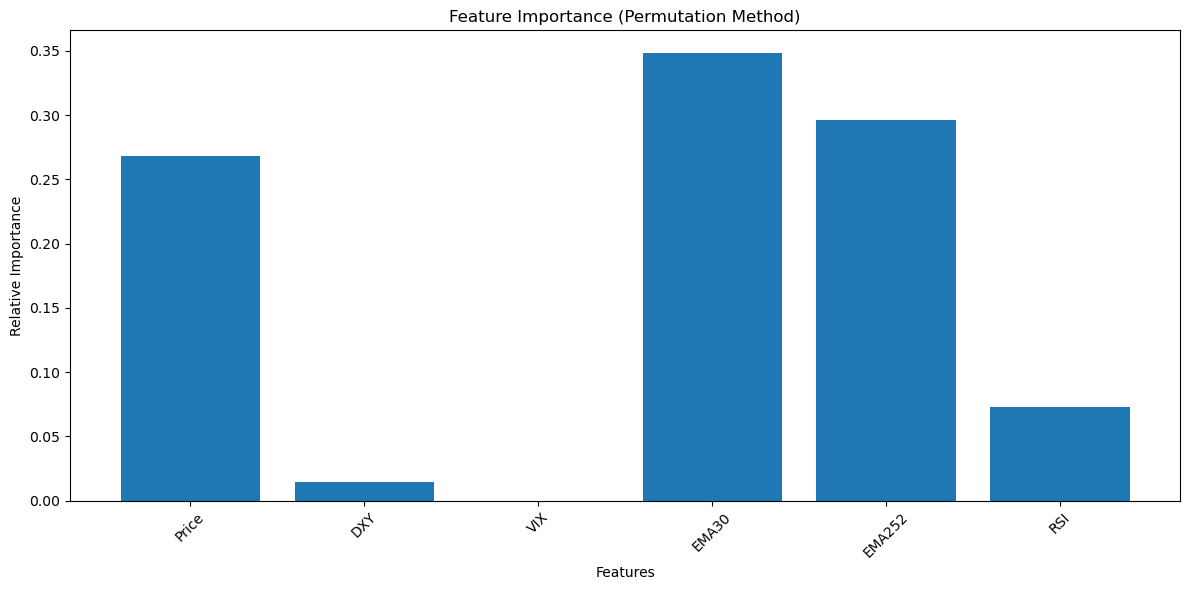


Visualizing attention over time...


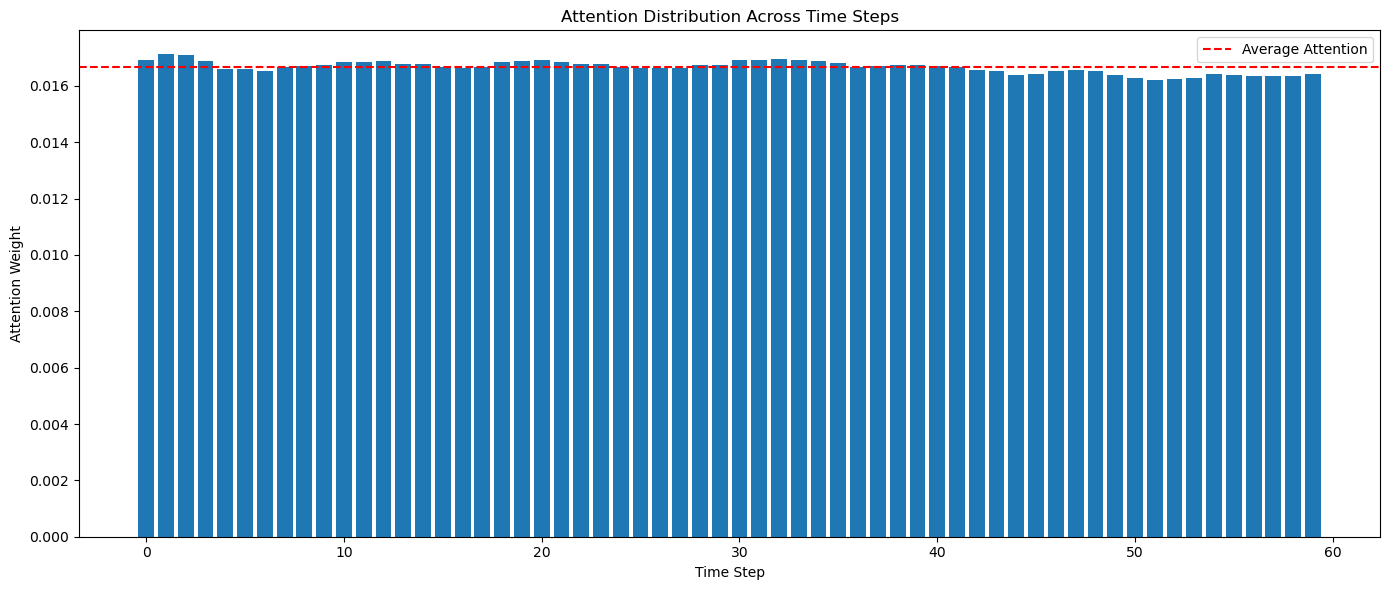

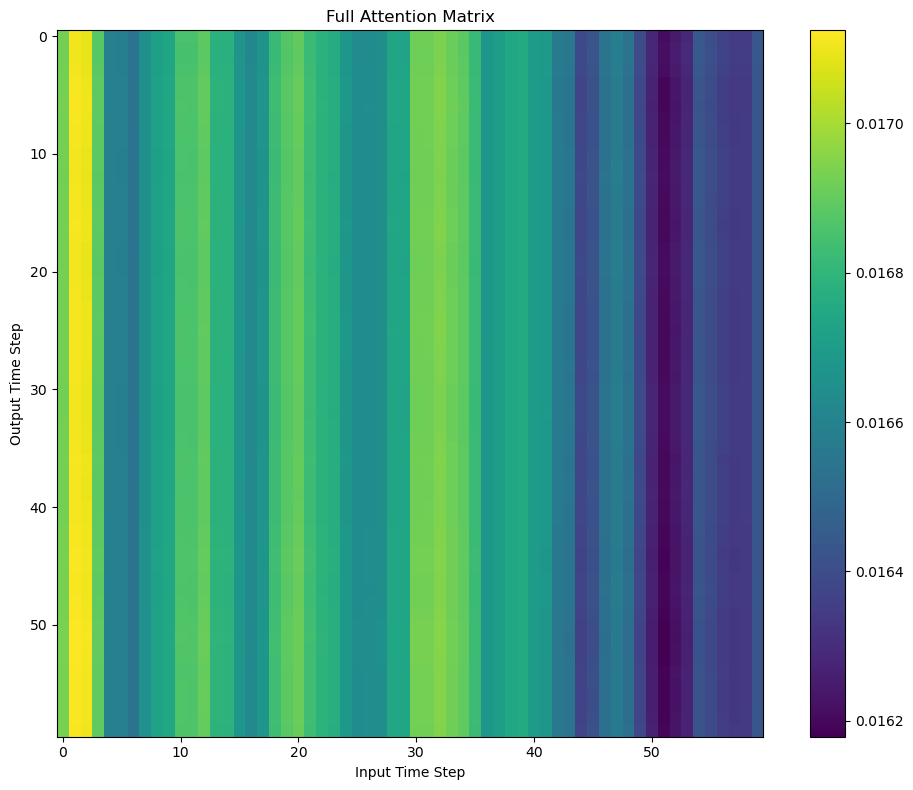


Running trading strategy backtest...


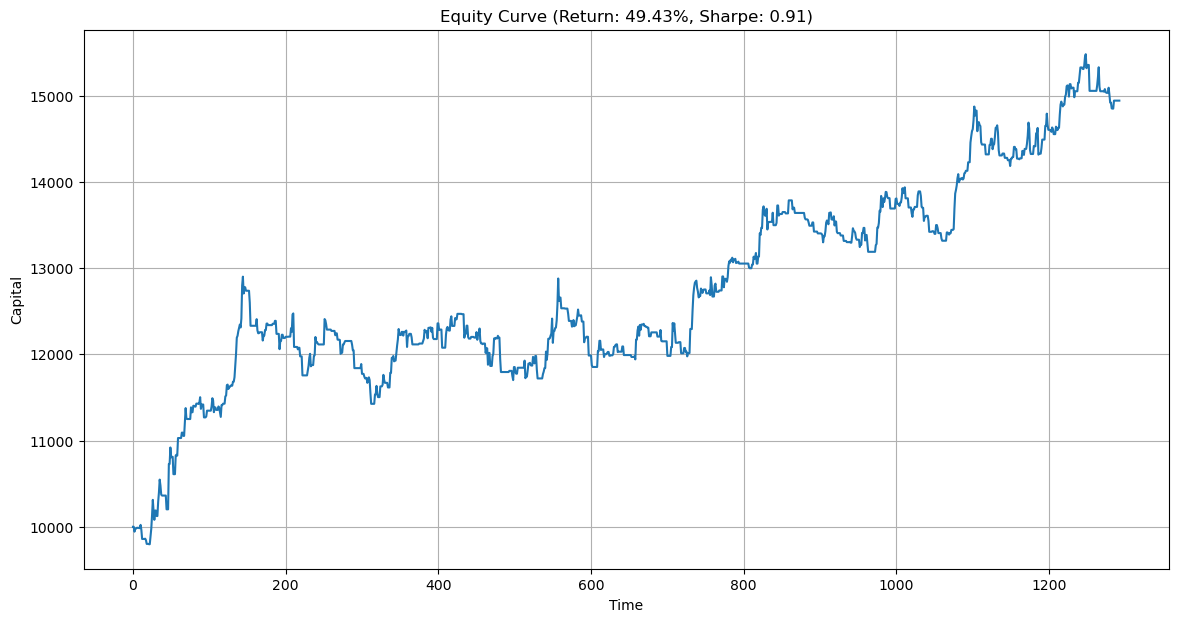

Final capital: $14942.61
Return: 49.43%
Sharpe Ratio: 0.91
Number of trades: 261
RMSE: 231.21
Directional Accuracy: 46.83%


In [48]:
df = load_data()

# Run the complete backtesting process
results = run_gold_price_backtesting(
    df,                     # Your dataframe with gold prices and features
    features = ["Price", "DXY", "VIX", "EMA30", "EMA252", "RSI"],
    seq_length=60,          # Length of sequence/window for predictions
    test_size=0.2,          # Proportion of data to use for testing
    d_model=256,            # Dimension of transformer model
    num_heads=8,            # Number of attention heads
    num_layers=4,           # Number of transformer layers
    dropout_rate=0.2,       # Dropout rate for regularization
    batch_size = 64,        # Batch size for training
    epochs=100,              # Maximum number of training epochs
    directional_loss_weight=0.7
)

# Access results
model = results['model']                   # The trained model
metrics = results['metrics']               # Performance metrics
feature_importance = results['feature_importance']  # Feature importance scores
trading_results = results['trading_results']        # Trading backtest results

# Print key metrics
print(f"RMSE: {metrics['rmse']:.2f}")
print(f"Directional Accuracy: {metrics['directional_accuracy']:.2f}%")

# Save model if needed
# model.save('gold_price_transformer.tf')

Training data shape: (3911, 60, 7)
Testing data shape: (978, 60, 7)
Epoch 1/100
49/49 [==============================] - 8s 68ms/step - loss: 5.7236 - val_loss: 3.0487
Epoch 2/100
49/49 [==============================] - 2s 46ms/step - loss: 0.8329 - val_loss: 0.1112
Epoch 3/100
49/49 [==============================] - 2s 45ms/step - loss: 0.1343 - val_loss: 0.2706
Epoch 4/100
49/49 [==============================] - 2s 47ms/step - loss: 0.0704 - val_loss: 0.1760
Epoch 5/100
49/49 [==============================] - 2s 46ms/step - loss: 0.0470 - val_loss: 0.2328
Epoch 6/100
49/49 [==============================] - 2s 43ms/step - loss: 0.0367 - val_loss: 0.0333
Epoch 7/100
49/49 [==============================] - 2s 42ms/step - loss: 0.0283 - val_loss: 0.0757
Epoch 8/100
49/49 [==============================] - 2s 43ms/step - loss: 0.0220 - val_loss: 0.0739
Epoch 9/100
49/49 [==============================] - 2s 43ms/step - loss: 0.0204 - val_loss: 0.1445
Epoch 10/100
49/49 [============

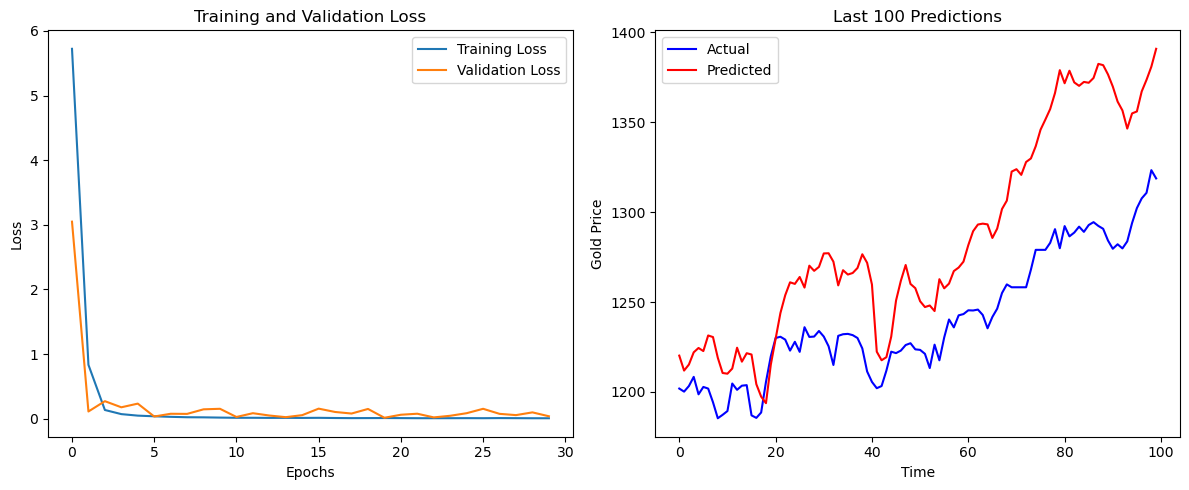


Analyzing feature importance...
31/31 [==============================] - 0s 14ms/step


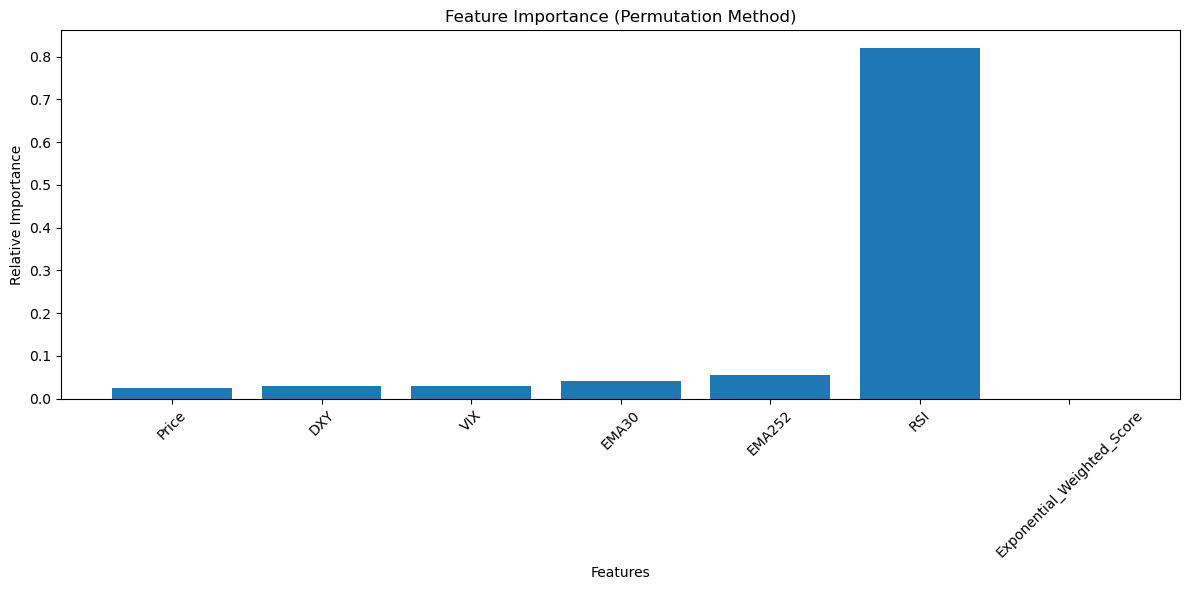


Visualizing attention over time...


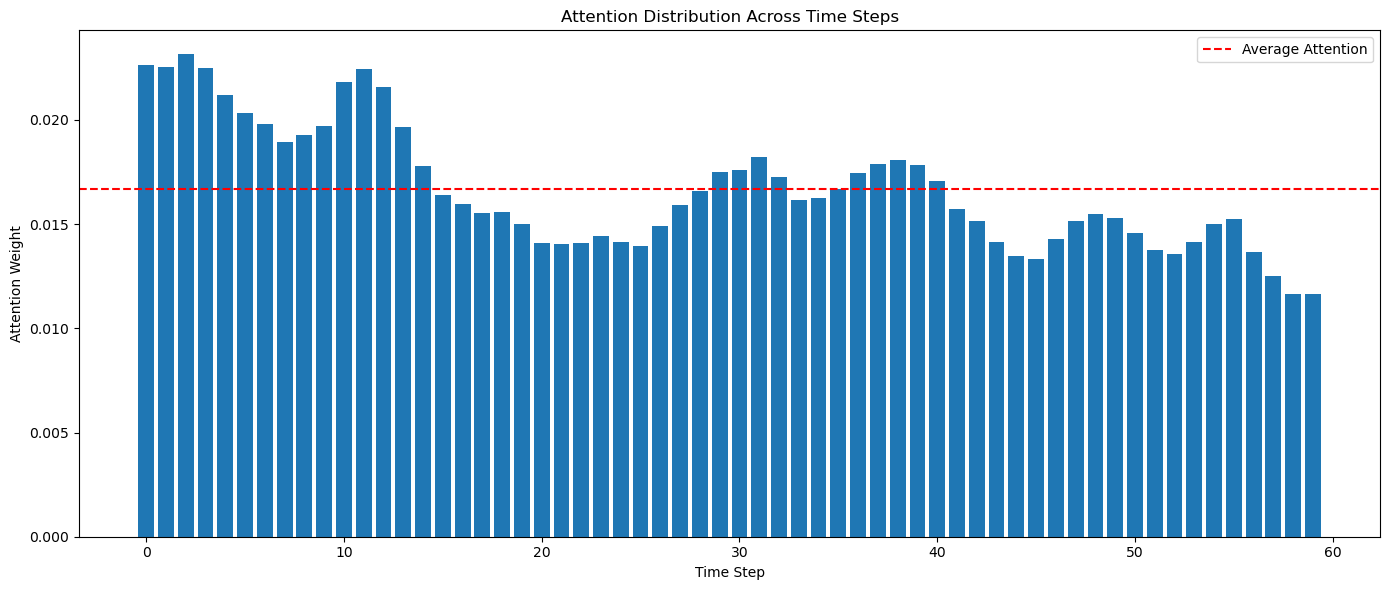

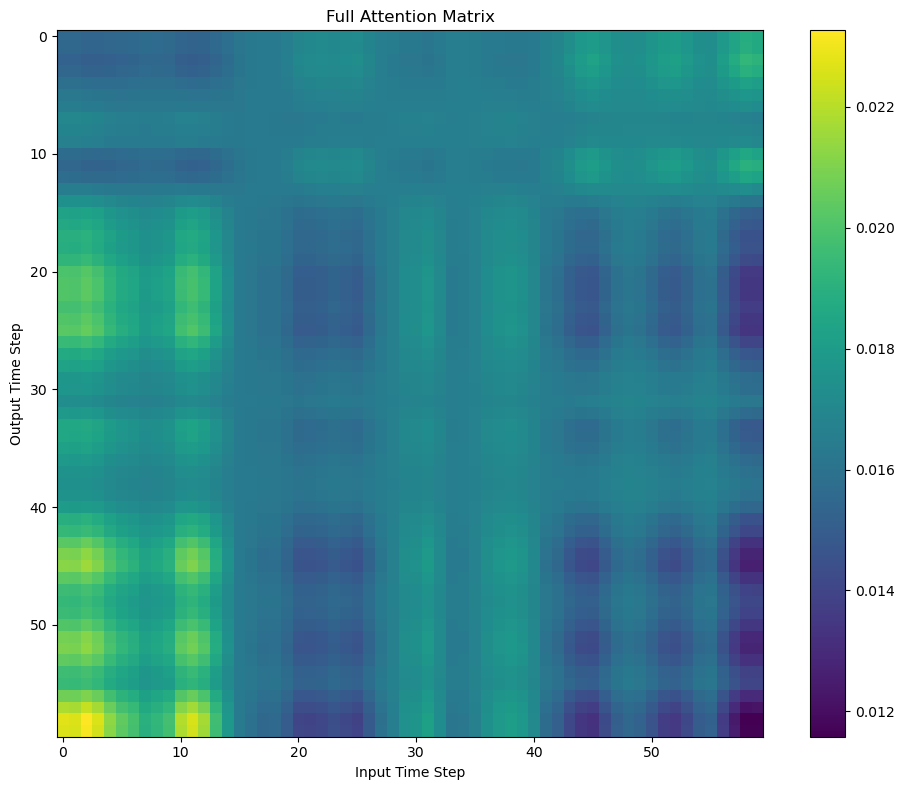


Running trading strategy backtest...


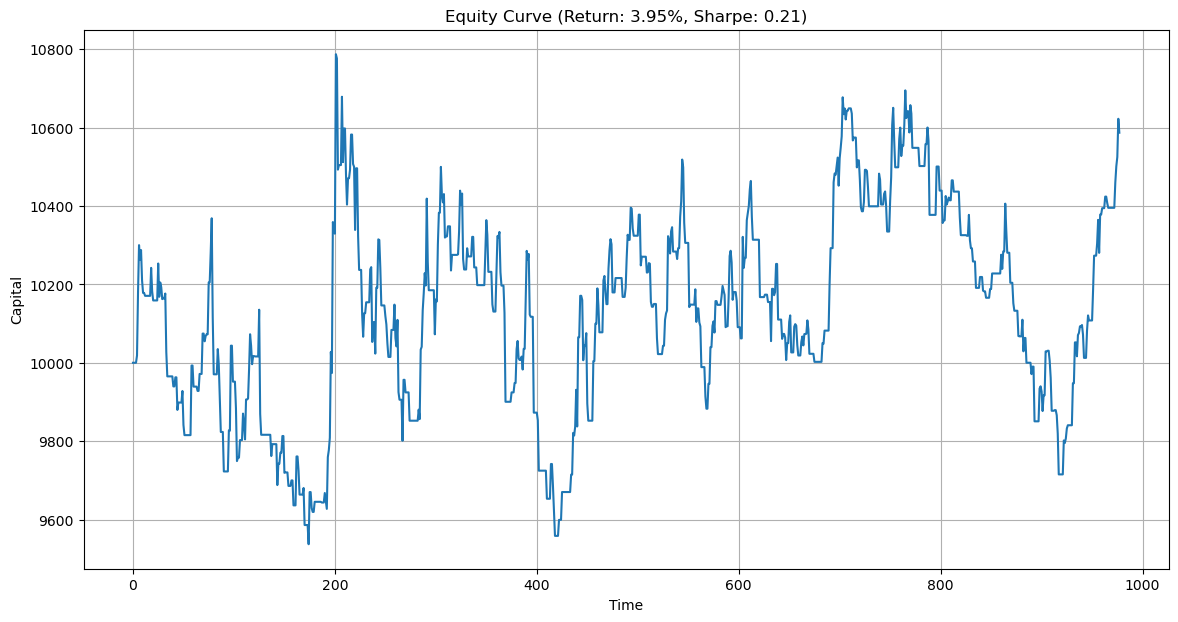

Final capital: $10395.41
Return: 3.95%
Sharpe Ratio: 0.21
Number of trades: 192
RMSE: 34.18
Directional Accuracy: 48.11%


In [49]:
df = load_data()

# Run the complete backtesting process
results = run_gold_price_backtesting(
    df,                     # Your dataframe with gold prices and features
    features = ["Price", "DXY", "VIX", "EMA30", "EMA252", "RSI", "Exponential_Weighted_Score"],
    seq_length=60,          # Length of sequence/window for predictions
    test_size=0.2,          # Proportion of data to use for testing
    d_model=256,            # Dimension of transformer model
    num_heads=8,            # Number of attention heads
    num_layers=4,           # Number of transformer layers
    dropout_rate=0.2,       # Dropout rate for regularization
    batch_size = 64,        # Batch size for training
    epochs=100,              # Maximum number of training epochs
    directional_loss_weight=0.7
)

# Access results
model = results['model']                   # The trained model
metrics = results['metrics']               # Performance metrics
feature_importance = results['feature_importance']  # Feature importance scores
trading_results = results['trading_results']        # Trading backtest results

# Print key metrics
print(f"RMSE: {metrics['rmse']:.2f}")
print(f"Directional Accuracy: {metrics['directional_accuracy']:.2f}%")

# Save model if needed
# model.save('gold_price_transformer.tf')

## Directional Loss

Training data shape: (5587, 60, 1)
Testing data shape: (1397, 60, 1)
Epoch 1/100
70/70 [==============================] - 9s 59ms/step - loss: 1.8793 - val_loss: 0.6081
Epoch 2/100
70/70 [==============================] - 3s 40ms/step - loss: 0.5726 - val_loss: 0.6948
Epoch 3/100
70/70 [==============================] - 3s 41ms/step - loss: 0.5606 - val_loss: 0.5838
Epoch 4/100
70/70 [==============================] - 3s 41ms/step - loss: 0.2741 - val_loss: 0.4132
Epoch 5/100
70/70 [==============================] - 3s 41ms/step - loss: 0.1032 - val_loss: 0.3680
Epoch 6/100
70/70 [==============================] - 3s 41ms/step - loss: 0.0812 - val_loss: 0.3559
Epoch 7/100
70/70 [==============================] - 3s 41ms/step - loss: 0.0725 - val_loss: 0.3584
Epoch 8/100
70/70 [==============================] - 3s 40ms/step - loss: 0.0691 - val_loss: 0.3613
Epoch 9/100
70/70 [==============================] - 3s 41ms/step - loss: 0.0645 - val_loss: 0.3584
Epoch 10/100
70/70 [===========

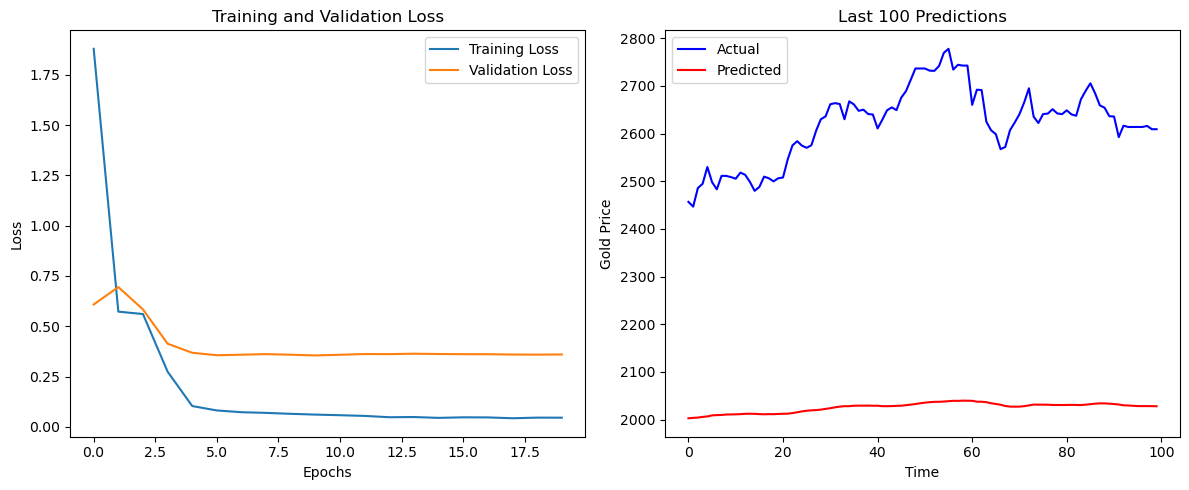


Analyzing feature importance...
44/44 [==============================] - 1s 14ms/step


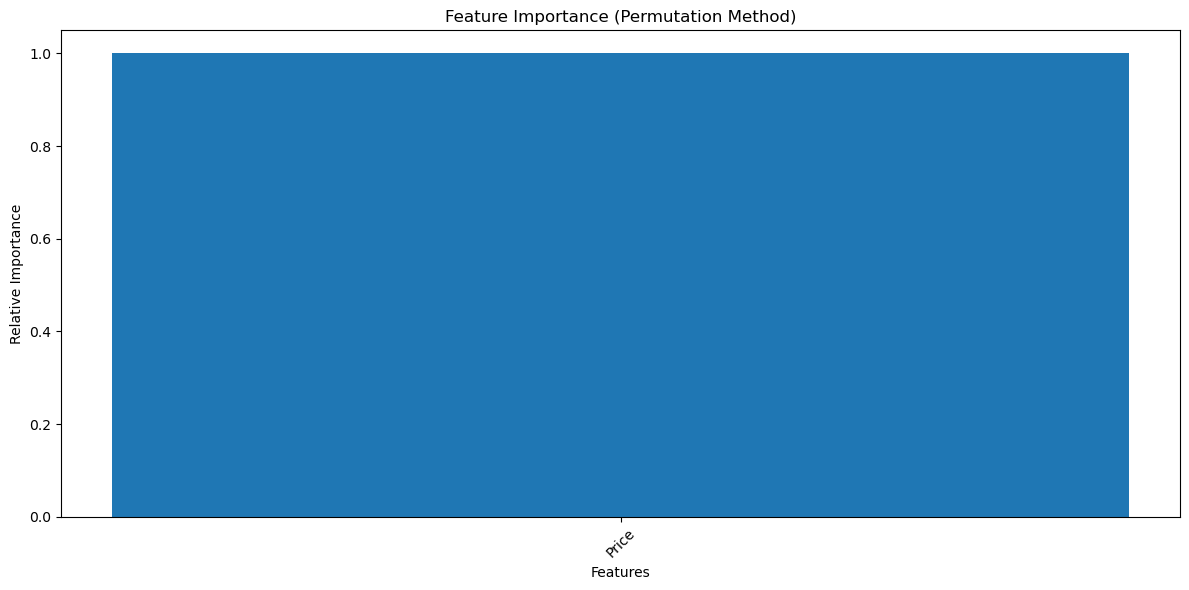


Visualizing attention over time...


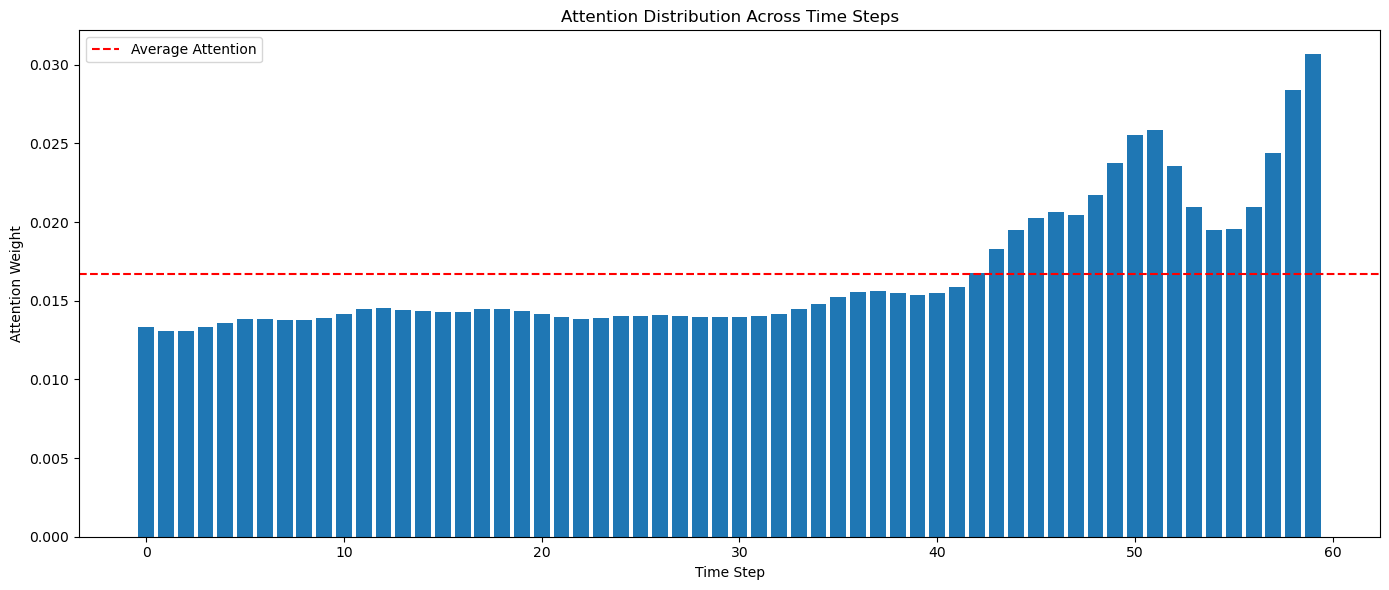

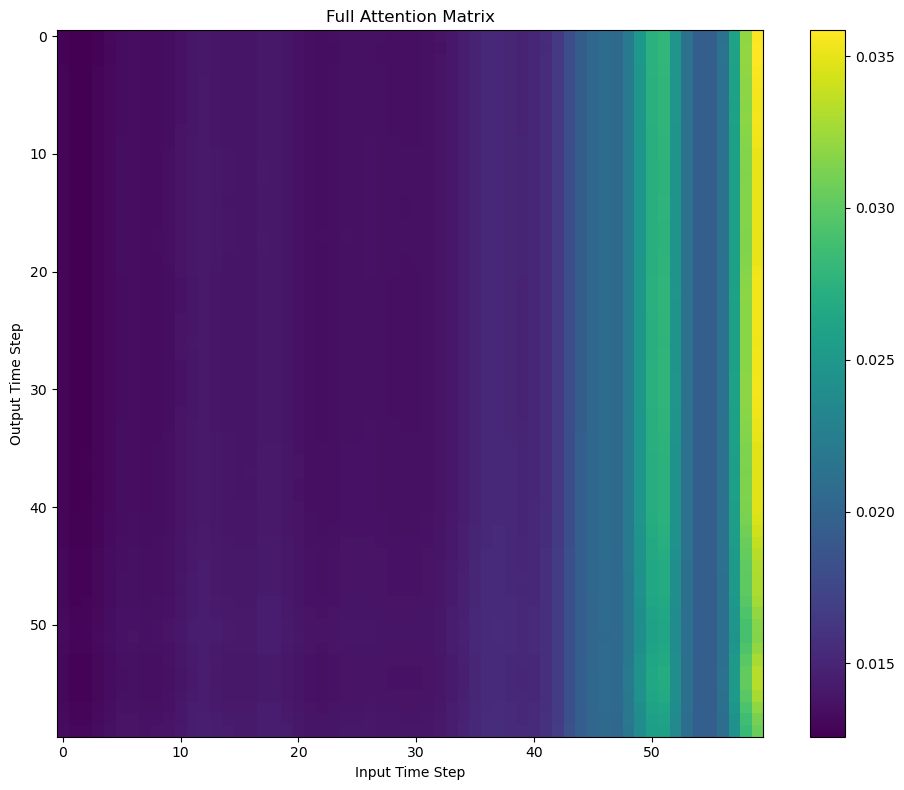


Running trading strategy backtest...


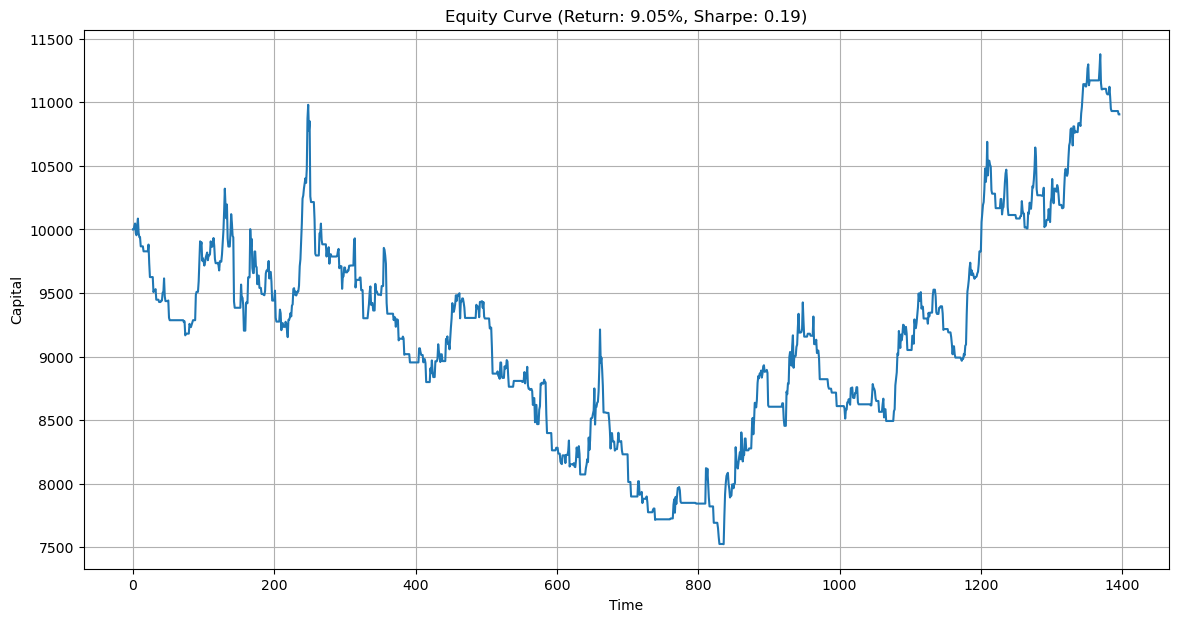

Final capital: $10905.15
Return: 9.05%
Sharpe Ratio: 0.19
Number of trades: 174
RMSE: 196.35
Directional Accuracy: 47.99%


In [42]:
df = load_data()

# Run the complete backtesting process
results = run_gold_price_backtesting(
    df,                     # Your dataframe with gold prices and features
    features = ["Price"],
    seq_length=60,          # Length of sequence/window for predictions
    test_size=0.2,          # Proportion of data to use for testing
    d_model=256,            # Dimension of transformer model
    num_heads=8,            # Number of attention heads
    num_layers=4,           # Number of transformer layers
    dropout_rate=0.2,       # Dropout rate for regularization
    batch_size = 64,        # Batch size for training
    epochs=100,              # Maximum number of training epochs
    directional_loss_weight=0.7
)

# Access results
model = results['model']                   # The trained model
metrics = results['metrics']               # Performance metrics
feature_importance = results['feature_importance']  # Feature importance scores
trading_results = results['trading_results']        # Trading backtest results

# Print key metrics
print(f"RMSE: {metrics['rmse']:.2f}")
print(f"Directional Accuracy: {metrics['directional_accuracy']:.2f}%")

# Save model if needed
# model.save('gold_price_transformer.tf')

Training data shape: (5169, 60, 6)
Testing data shape: (1293, 60, 6)
Epoch 1/100
65/65 [==============================] - 8s 55ms/step - loss: 1.9454 - val_loss: 0.6294
Epoch 2/100
65/65 [==============================] - 3s 43ms/step - loss: 0.5848 - val_loss: 0.5256
Epoch 3/100
65/65 [==============================] - 3s 42ms/step - loss: 0.2128 - val_loss: 0.3651
Epoch 4/100
65/65 [==============================] - 3s 41ms/step - loss: 0.0856 - val_loss: 0.3767
Epoch 5/100
65/65 [==============================] - 3s 41ms/step - loss: 0.0663 - val_loss: 0.3710
Epoch 6/100
65/65 [==============================] - 3s 41ms/step - loss: 0.0477 - val_loss: 0.3756
Epoch 7/100
65/65 [==============================] - 3s 41ms/step - loss: 0.0464 - val_loss: 0.3652
Epoch 8/100
65/65 [==============================] - 3s 41ms/step - loss: 0.0406 - val_loss: 0.3756
Epoch 9/100
65/65 [==============================] - 3s 41ms/step - loss: 0.0373 - val_loss: 0.3672
Epoch 10/100
65/65 [===========

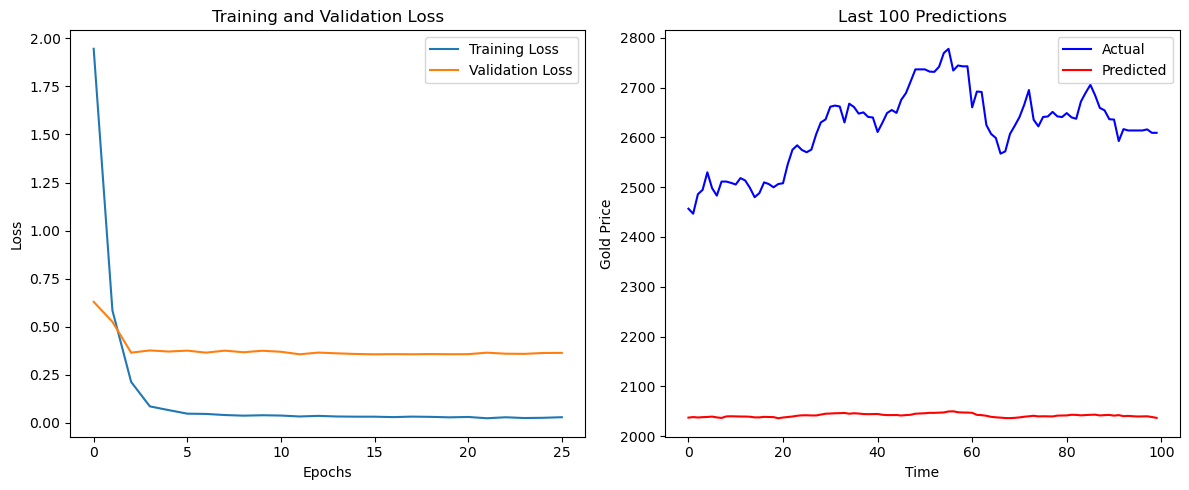


Analyzing feature importance...
41/41 [==============================] - 1s 14ms/step


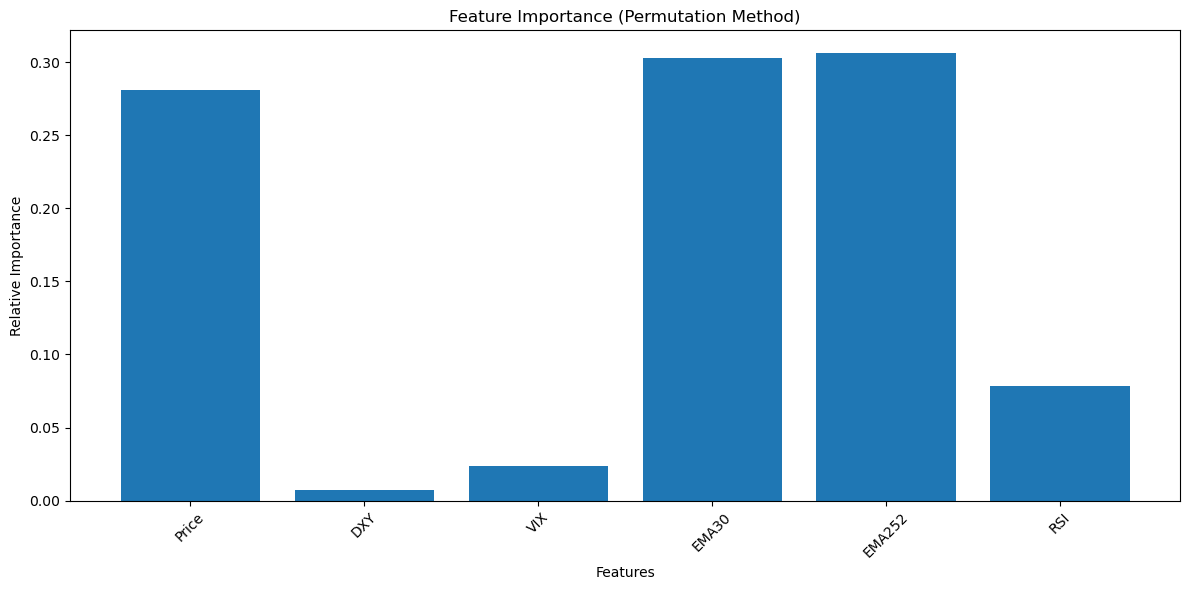


Visualizing attention over time...


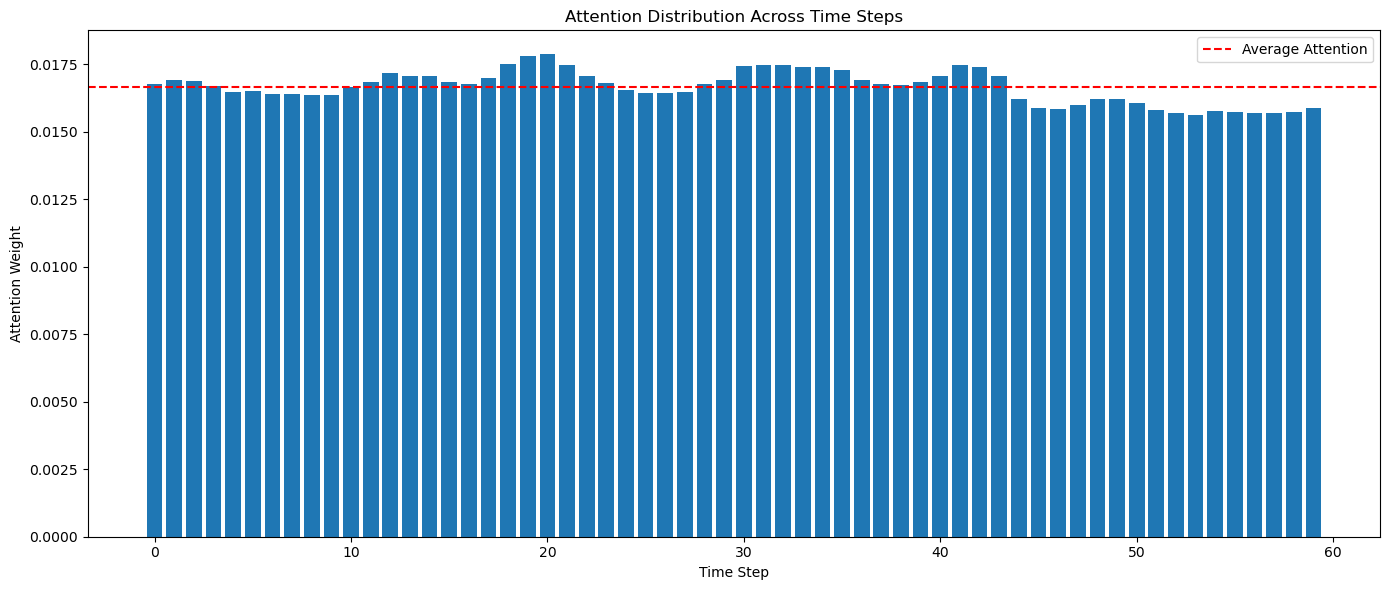

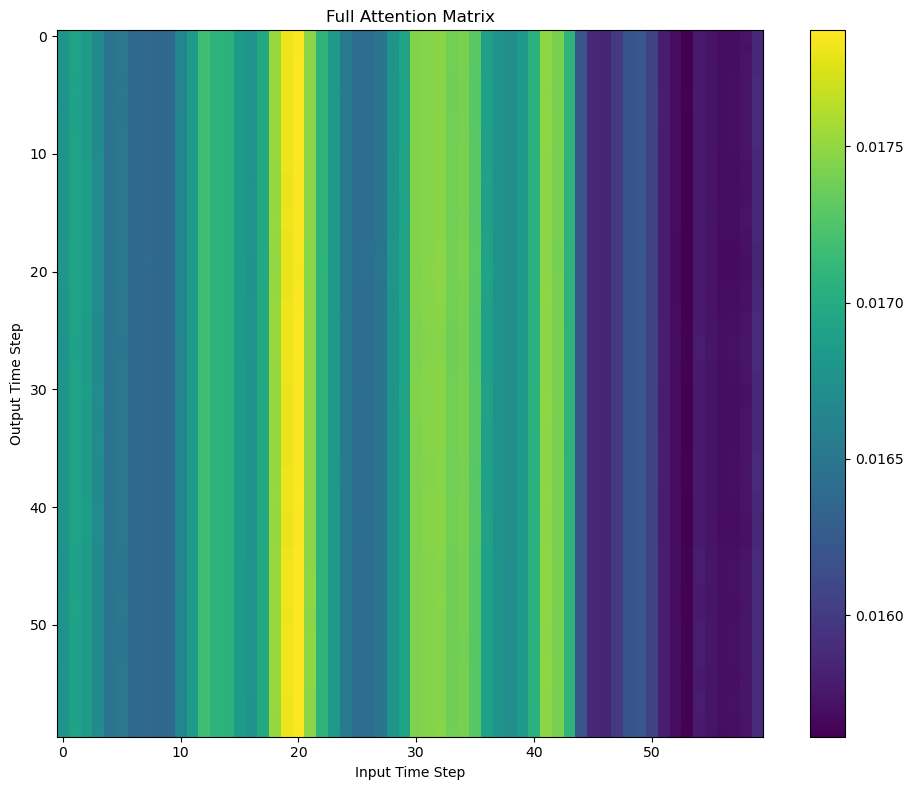


Running trading strategy backtest...


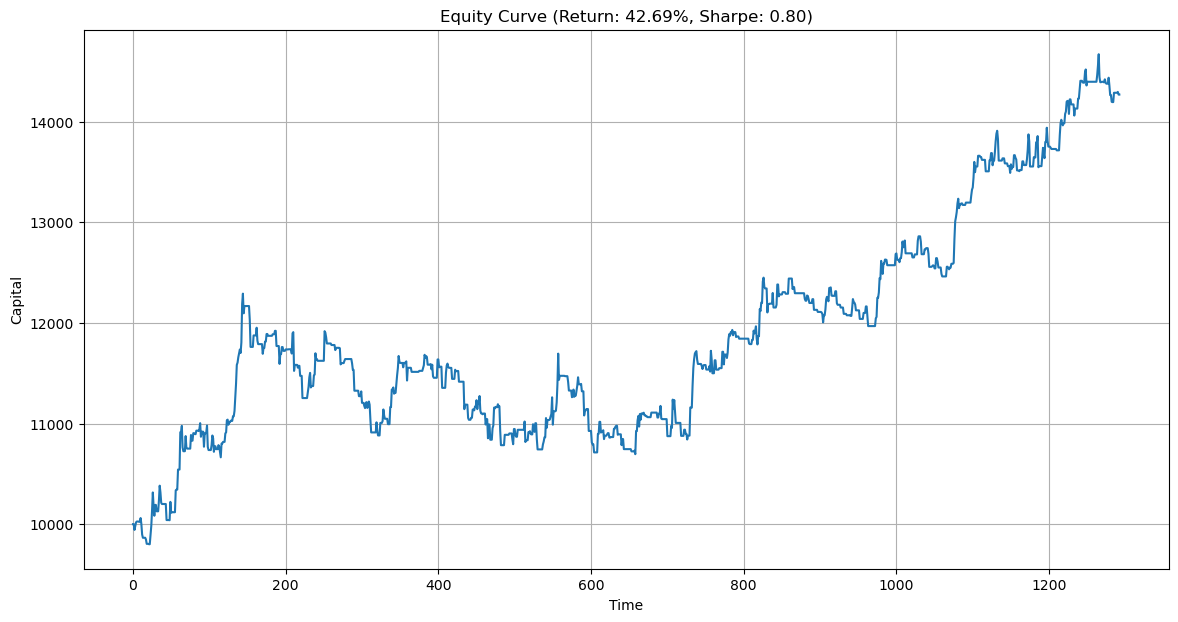

Final capital: $14269.20
Return: 42.69%
Sharpe Ratio: 0.80
Number of trades: 254
RMSE: 232.51
Directional Accuracy: 46.98%


In [43]:
df = load_data()

# Run the complete backtesting process
results = run_gold_price_backtesting(
    df,                     # Your dataframe with gold prices and features
    features = ["Price", "DXY", "VIX", "EMA30", "EMA252", "RSI"],
    seq_length=60,          # Length of sequence/window for predictions
    test_size=0.2,          # Proportion of data to use for testing
    d_model=256,            # Dimension of transformer model
    num_heads=8,            # Number of attention heads
    num_layers=4,           # Number of transformer layers
    dropout_rate=0.2,       # Dropout rate for regularization
    batch_size = 64,        # Batch size for training
    epochs=100,              # Maximum number of training epochs
    directional_loss_weight=0.7
)

# Access results
model = results['model']                   # The trained model
metrics = results['metrics']               # Performance metrics
feature_importance = results['feature_importance']  # Feature importance scores
trading_results = results['trading_results']        # Trading backtest results

# Print key metrics
print(f"RMSE: {metrics['rmse']:.2f}")
print(f"Directional Accuracy: {metrics['directional_accuracy']:.2f}%")

# Save model if needed
# model.save('gold_price_transformer.tf')

Training data shape: (3911, 60, 7)
Testing data shape: (978, 60, 7)
Epoch 1/100
49/49 [==============================] - 8s 60ms/step - loss: 2.6020 - val_loss: 1.0864
Epoch 2/100
49/49 [==============================] - 2s 43ms/step - loss: 0.6499 - val_loss: 1.1076
Epoch 3/100
49/49 [==============================] - 2s 43ms/step - loss: 0.5528 - val_loss: 0.7037
Epoch 4/100
49/49 [==============================] - 2s 42ms/step - loss: 0.1500 - val_loss: 0.4910
Epoch 5/100
49/49 [==============================] - 2s 42ms/step - loss: 0.1083 - val_loss: 0.4050
Epoch 6/100
49/49 [==============================] - 2s 43ms/step - loss: 0.0920 - val_loss: 0.3966
Epoch 7/100
49/49 [==============================] - 2s 42ms/step - loss: 0.0763 - val_loss: 0.4433
Epoch 8/100
49/49 [==============================] - 2s 43ms/step - loss: 0.0694 - val_loss: 0.3889
Epoch 9/100
49/49 [==============================] - 2s 41ms/step - loss: 0.0598 - val_loss: 0.4149
Epoch 10/100
49/49 [============

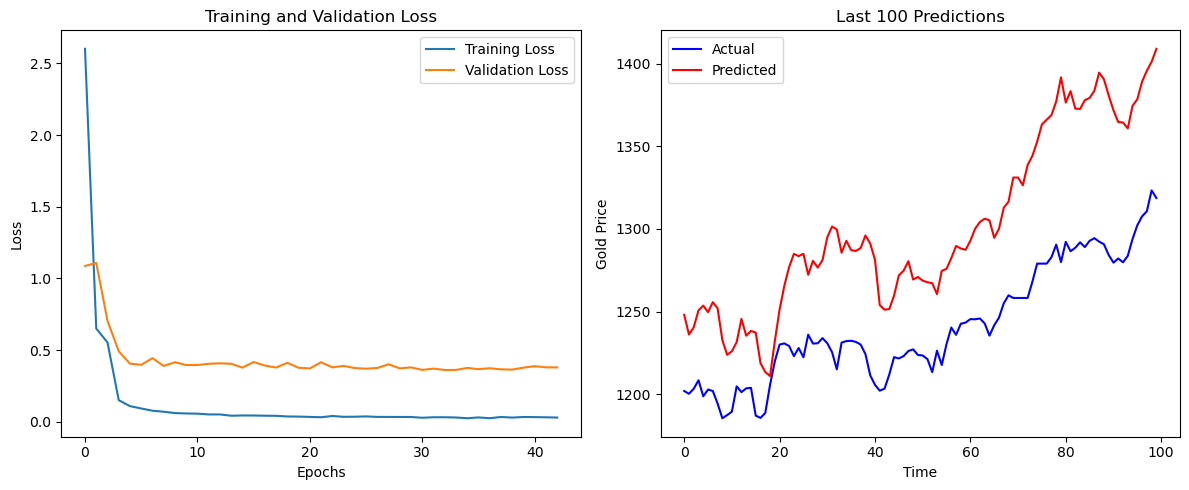


Analyzing feature importance...
31/31 [==============================] - 0s 14ms/step


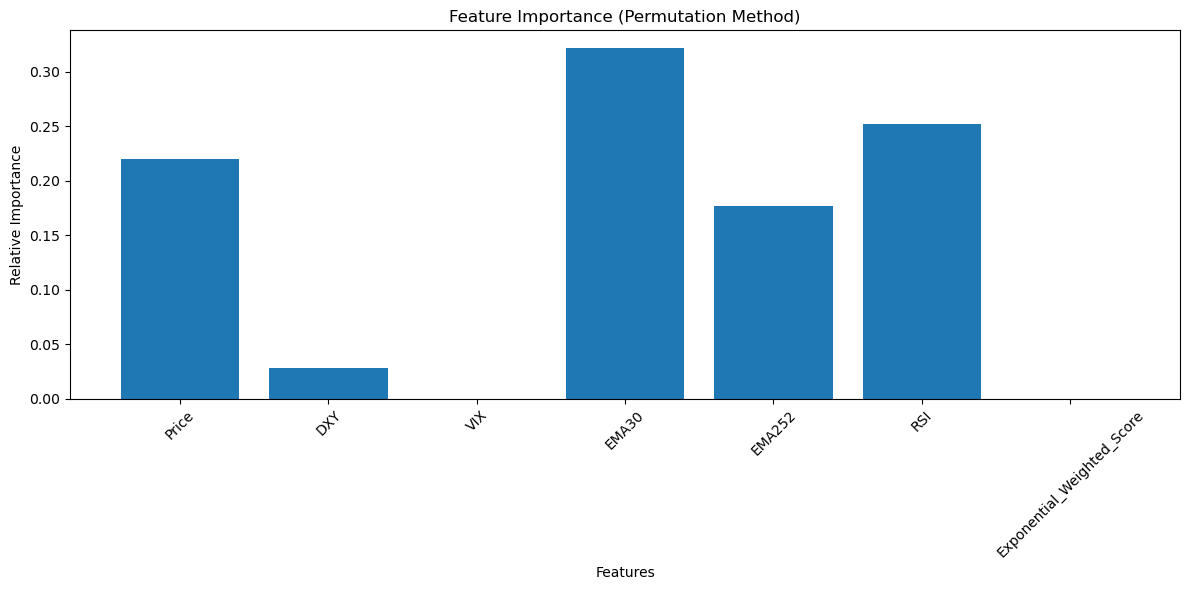


Visualizing attention over time...


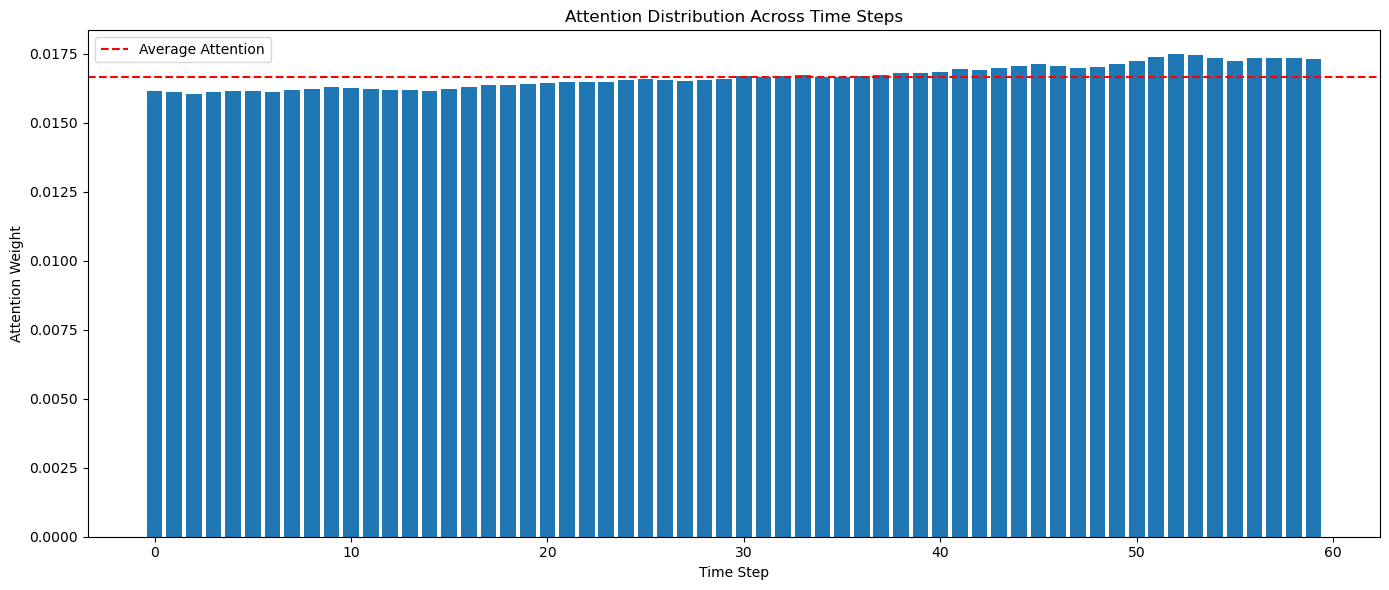

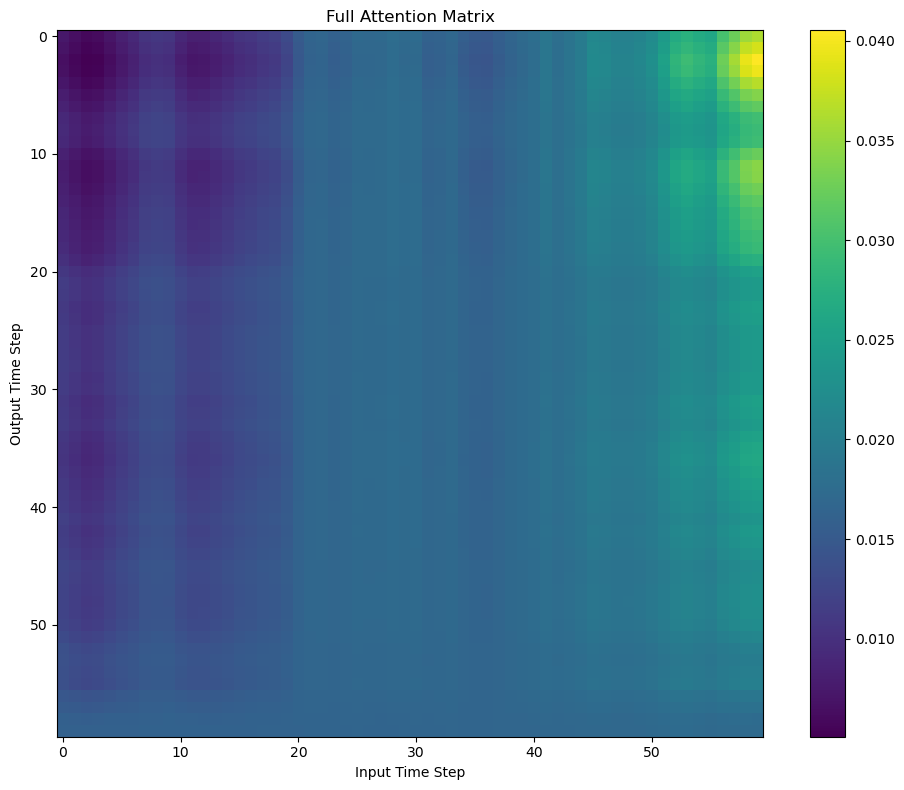


Running trading strategy backtest...


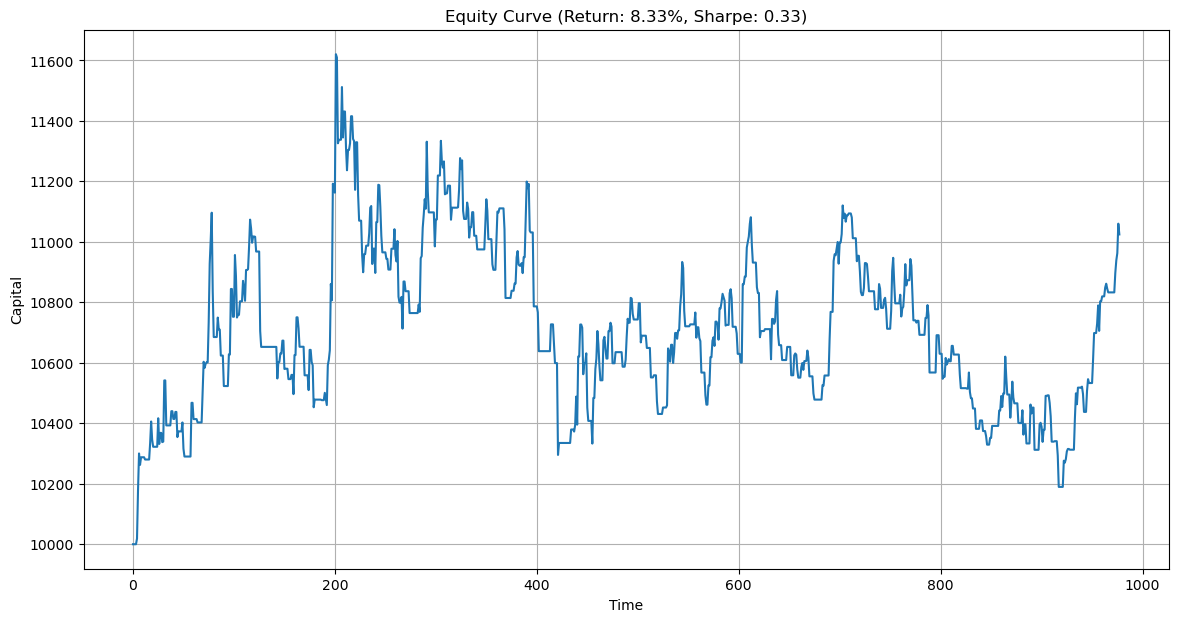

Final capital: $10832.81
Return: 8.33%
Sharpe Ratio: 0.33
Number of trades: 193
RMSE: 49.77
Directional Accuracy: 46.98%


In [44]:
df = load_data()

# Run the complete backtesting process
results = run_gold_price_backtesting(
    df,                     # Your dataframe with gold prices and features
    features = ["Price", "DXY", "VIX", "EMA30", "EMA252", "RSI", "Exponential_Weighted_Score"],
    seq_length=60,          # Length of sequence/window for predictions
    test_size=0.2,          # Proportion of data to use for testing
    d_model=256,            # Dimension of transformer model
    num_heads=8,            # Number of attention heads
    num_layers=4,           # Number of transformer layers
    dropout_rate=0.2,       # Dropout rate for regularization
    batch_size = 64,        # Batch size for training
    epochs=100,              # Maximum number of training epochs
    directional_loss_weight=0.7
)

# Access results
model = results['model']                   # The trained model
metrics = results['metrics']               # Performance metrics
feature_importance = results['feature_importance']  # Feature importance scores
trading_results = results['trading_results']        # Trading backtest results

# Print key metrics
print(f"RMSE: {metrics['rmse']:.2f}")
print(f"Directional Accuracy: {metrics['directional_accuracy']:.2f}%")

# Save model if needed
# model.save('gold_price_transformer.tf')

## Summary
Without regularisation there is significant overfitting, for using MSE and directional loss, the shape of the predicted values are similar, hence it could suggest that using directional loss might not have that much of a beneficial effect. In fact the difference in the equity curve might actually be due to random errors.

Exponential Weighted Score helps with decreasing the RMSE.

If we use regularisation, both L1 and L2 will help to produce good RMSE (about 40) with good returns.

Standard = Price, DXY, VIX, EMA30, EMA252, RSI

| Loss Function | Regularisation | Features | RMSE | Return | Directional Accuracy |
| ------------- | -------------- | -------- | ---- | ------ | -------------------- |
| Directional | None | Price | 196.35 | 9.05% | 47.99% |
| Directional | None | Standard | 232.51 | 42.69% | 46.98% |
| Directional | None | Standard + Exp Sentiment | 49.77 | 8.33% | 46.98% |
| ------------- | -------------- | -------- | ---- | ------ | -------------------- |
| Directional | L2 | Standard | 144.65 | 45.31% | 47.21% |
| Directional | L2 | Standard + Exp Sentiment | 50.37 | 3.83% | 47.80% |
| ------------- | -------------- | -------- | ---- | ------ | -------------------- |
| Directional | L1 & L2 | Standard | 44.22 | 38.16% | 47.21% |
| Directional | L1 & L2 | Standard + Exp Sentiment | **26.30** | -2.12% | **48.93%** |
| ------------- | -------------- | -------- | ---- | ------ | -------------------- |
| MSE | None | Price | 211.88 | 16.41% | 48.57% |
| MSE | None | Standard | 231.21 | 49.43% | 46.83% |
| MSE | None | Standard + Exp Sentiment | 34.18 | 3.95% | 48.11% |
| ------------- | -------------- | -------- | ---- | ------ | -------------------- |
| MSE | L2 | Standard | 33.61 | 49.43% | 48.14% |
| MSE | L2 | Standard + Exp Sentiment | 39.41 | 2.77% | 48.93% |
| ------------- | -------------- | -------- | ---- | ------ | -------------------- |
| MSE | L1 & L2 | Standard | 48.76 | **51.24%** | 48.37% |
| MSE | L1 & L2 | Standard + Exp Sentiment | 57.89 | -5.27% | 47.70% |

